# deepBreaks applications
## Predicting the subtype of the HIV-1 virus based on its V3 amino-acid sequence   
PLACEHOLDER FOR DESCRIPTION
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1868395/
<p style="text-align:center;">
<figure>
  <img src="../img/HIV/v3.png" alt="V3" style="width: 400px;">
    <figcaption>Image from: <a size=10 href=https://doi.org/10.1371/journal.pcbi.0030058>Sander, Oliver, et al. "Structural descriptors of gp120 V3 loop for the prediction of HIV-1 coreceptor usage." PLoS computational biology 3.3 (2007): e58.</a> 
        </figcaption>
</figure>
</p>

In [1]:
#All neccessary packages to import for data process steps.
import mysql
import mysql.connector
import argparse
import re
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings
from pycaret.classification import *

In [ ]:
#STEP 0: Data Base Setup - Script 1 - Import heterologous.tsv into mySQL

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[11])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

In [ ]:
#STEP 0: Data Base Setup - Script 1 - Import opsindb.tsv into mySQL

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[11])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

In [ ]:
#STEP 1: Extract Data From Vizphiz
#Output = 5 different 'version' // 'splits' of the data. 
#Take outputs and run through MAFFT before moving on to STEP2
#Suggested parameters for 'mafft' alignment are...
wd_output = 'wds.txt'
sws_output = 'swd.txt'
mws_output = 'mwd.txt'
rod_output = 'rod.txt'
wh_metadata = 'wds_meta.txt'
sw_metadata = 'sws_meta.txt'
mw_metadata = 'mws_meta.txt'
rh_metadata = 'rod_meta.txt'
wd_ni_output = 'wds_noinverts.txt'
wd_ni_metadata = 'wds_ni_meta.txt'
class_ni_metadata = 'class_meta.txt'
class_metadata = 'class_ni_meta.txt'
m = 0
s = 0
l = 0
r = 0
c = 0
acc_list = []
duped = 0

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()


for x in myresult:       

  if (x[4] in range(340, 380)):
    opclass = 0
  
  elif (x[4] in range(380, 420)):
    opclass = 1 

  elif (x[4] in range(420, 460)):
    opclass = 2

  elif (x[4] in range(460, 500)):
    opclass = 3 

  elif (x[4] in range(500, 540)):
    opclass = 4  
  else:
    opclass = 5

  #Keep all accessions in a list -- don't print 
  if (x[3] in acc_list):
    #print ("\n\n\n****Accession Exists" + x[2] + "\n\n" )
    duped=1
  #First 2 of if statements ignore ancestral (pigment named) or mutated genes
  if (duped==1) :
    duped=0
  #do not print if contains the word "pigment" which is an ancestral sequence

  else :
#REG-DATA SECTION    
       with open(wd_output, 'a') as f:
          if(x[3]) == "NM_001014890.2":
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          else:
            m += 1 
            #This makes the fasta format file
            seq = ">S" + str(m)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

       with open(wd_ni_output, 'a') as f:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if (p.match(x[2])):
          pass
        else:
          if(x[3]) == "NM_001014890.2":
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          else:
            c += 1 
            #This makes the fasta format file
            seq = ">S" + str(c)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

       with open(sws_output, 'a') as f:
        p = re.compile('^SWS|^UVS')
        if p.match(x[2]):
          s+=1
          if s == 1:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")  
        #This makes the fasta format file
          seq = ">S" + str(s)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

       with open(mws_output, 'a') as f:
        p = re.compile('^MWS|^LWS')
        if p.match(x[2]):
          l+=1
          if l == 1:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          #This makes the fasta format file
          seq = ">S" + str(l)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

       with open(rod_output, 'a') as f:
        p = re.compile('Rh[0-2]|exoRh')
        if p.match(x[2]):
          if(x[3]) == "NM_001014890.2":
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          else:
            r+=1
            #This makes the fasta format file
            seq = ">S" + str(r)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

#METADATA SECTION
       with open(wh_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        if m == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
        if(x[3]) == "NM_001014890.2":
          g.write("Bovine\t500\tBos_tarus\tRh1\tNM_001014890\n")
        else:        
          md =  str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(wd_ni_metadata, 'a') as g:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if p.match(x[2]):
          pass
        #This makes the metadata formatted for a linear regression model.
        else:
          if c == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
          if(x[3]) == "NM_001014890.2":
            g.write("Bovine\t500\tBos_tarus\tRh1\tNM_001014890\n")
          else:  
            md =  str("S" + str(c) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)

       with open(sw_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('^SWS|^UVS')
        if p.match(x[2]):
          if s == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500\tBos_tarus\tRh1\tNM_001014890\n")  
          md =  str("S" + str(s) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(mw_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('^MWS|^LWS')
        if p.match(x[2]):
          if l == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
            g.write("Bovine\t500\tBos_tarus\tRh1\tNM_001014890\n")  
          md =  str("S" + str(l) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(rh_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('Rh[0-3]|exoRh')
        if p.match(x[2]):
          if r == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
          if(x[3]) == "NM_001014890.2":
            g.write("Bovine\t500\tBos_tarus\tRh1\tNM_001014890\n")
          else:  
            md =  str("S" + str(r) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)

       with open(class_metadata, 'a') as h:
          #This makes the metadata formatted for a classification model. 
        if m == 1:
          h.write("\tOpsin_Class\n")
        if(x[3]) == "NM_001014890.2":
          h.write("Bovine\t" + str(opclass) + "\n")
        else:  
          md = "S" + str(m) + "\t" + str(opclass) + "\n"
          h.write(md)

       with open(class_ni_metadata, 'a') as h:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if p.match(x[2]):
          pass
          #This makes the metadata formatted for a classification model. 
        else:
          if c == 1:
            h.write("\tOpsin_Class\n")
          if(x[3]) == "NM_001014890.2":
            h.write("Bovine\t" + str(opclass) + "\n")
          else:    
            md = "S" + str(c) + "\t" + str(opclass) + "\n"
            h.write(md)

In [ ]:
#STEP 2: Format Alignments for 'deepBreaks'
#REMINDER - Take outputs from STEP 1 and run through MAFFT before moving on to STEP2
#Suggested parameters for 'mafft' alignment are...
#enter list of aligned text files here.
inputs = []
##enter list of names for desired formatted fasta files here.
output = []
for files in inputs:
    file1 = open(inputs, 'r') 
    file2 = open(output, 'a+')
    lines = file1.readlines()
    line_count = len(lines)
    tab_entry = ""
    i = 0
    k = 0
    m = 0
    call = input("How Many Lines Per Alignment?: ")
    count = int(call)
    loop = range(int(count))

    for line in lines:

        for entries in loop:

            line1 = str(lines[k])
            line1.replace("\n","").lstrip
            if k == i:
                tab_entry += line1 

            else:
                tab_entry += str(line1).replace("\n", "")
                tab_entry.rstrip()
            k+=1

        file2.write(tab_entry + "\n")
            
        tab_entry = ""
        #I want code to read two lines at a time, replace any ">" with empty sapce and any new lines with a tab instead
        i+=count
        k = i 

        if i >= line_count:
            break
    file1.close()
    file2.close()

In [2]:
#STEP 3: deepBreaks - THIS IS A LONG SECTION! STEP 4 doesn't start until box 59
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = 'wds_ni_fmt.fasta' 
meta_data = 'class_noinverts_meta.tsv'
# name of the phenotype
mt = 'Opsin_Class'

# type of the sequences
seq_type = 'amino-acid'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)
metaData = prp.read_data(meta_data, is_main=False)
positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading fasta file
Done
Shape of data is:  (690, 480)
CPU times: total: 188 ms
Wall time: 201 ms


In [6]:
df.head()

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10  ... p471 p472 p473 p474  \
S1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
S2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
S4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
S5  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
S6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   

   p475 p476 p477 p478 p479 p480  
S1  NaN  NaN  NaN  NaN  NaN  NaN  
S2  NaN  NaN  NaN  NaN  NaN  NaN  
S4  NaN  NaN  NaN  NaN  NaN  NaN  
S5  NaN  NaN  NaN  NaN  NaN  NaN  
S6  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 480 columns]

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [7]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


Opsin_Class
S1            4
S2            4
S3            3
S4            3
S5            3

In [8]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [9]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (690, 480)
Shape of data after missing/constant care:  (690, 298)
CPU times: total: 109 ms
Wall time: 115 ms


In [10]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (690, 298)
Shape of data after imbalanced care:  (690, 278)
CPU times: total: 656 ms
Wall time: 663 ms


In [11]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  278
number of columns of main data after:  278
CPU times: total: 1.91 s
Wall time: 1.91 s


In [12]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)



one-hot encoding the dataset
CPU times: total: 141 ms
Wall time: 125 ms


In [13]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(730, 730)
CPU times: total: 703 ms
Wall time: 698 ms


In [14]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


p62_L     p62_M  p62_NGTVIYAPD     p63_K     p63_N  \
p62_L          0.000000  0.797365       0.860364  0.863663  0.955498   
p62_M          0.797365  0.000000       0.659924  0.667959  0.975737   
p62_NGTVIYAPD  0.860364  0.659924       0.000000  0.790320  0.754344   
p63_K          0.863663  0.667959       0.790320  0.000000  0.887490   
p63_N          0.955498  0.975737       0.754344  0.887490  0.000000   

                  p63_Q     p63_S     p63_V     p65_I     p65_K  ...  \
p62_L          0.922909  0.719073  0.908567  0.828636  0.643023  ...   
p62_M          0.812249  0.837787  0.634353  0.589670  0.892034  ...   
p62_NGTVIYAPD  0.870620  0.968518  0.949185  0.959385  0.741602  ...   
p63_K          0.873677  0.532792  0.850176  0.477772  0.747708  ...   
p63_N          0.936382  0.764707  0.924546  0.946492  0.888428  ...   

               p419_INQP    p419_S    p419_T    p419_V    p420_D    p420_E  \
p62_L           0.931339  0.910983  0.898518  0.930469  0.817054  0.852736   
p62_M           0.846456  0.783204  0.752845  0.657604  0.602519  0.522370   
p62_NGTVIYAPD   0.672324  0.876835  0.841489  0.853349  0.822125  0.996944   
p63_K           0.887490  0.506837  0.411418  0.856814  0.662506  0.718145   
p63_N           0.685402  0.926540  0.916253  0.724326  0.748254  0.688574   

                 p421_E  p421_SGPQAT    p422_E    p422_S  
p62_L          0.801280     0.917651  0.862711  0.795371  
p62_M          0.848143     0.834459  0.405250  0.501637  
p62_NGTVIYAPD  0.900293     0.564247  0.749878  0.930648  
p63_K          0.814450     0.865061  0.567961  0.341685  
p63_N          0.996667     0.956414  0.937553  0.844766  

[5 rows x 730 columns]

In [15]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.3,
                       needs_pivot=False)

finding colinear groups
CPU times: total: 453 ms
Wall time: 739 ms


In [16]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


feature group
0          p62_L    g0
1          p62_M    g1
2  p62_NGTVIYAPD    g2
3          p63_K    g1
5          p63_Q    g3

Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [17]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)
file2 = open('dc_cols.txt', 'a+')
training = str(dc)
file2.write(training)
file2.close()                      

grouping features
CPU times: total: 78.1 ms
Wall time: 78 ms


In [18]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)
file2 = open('train_cols.txt', 'a+')
training = (df_cleaned.to_string())
file2.write(training)
file2.close()
#USE FOR TRAIN COLS! It's the correct format. Import into excel. 

training_col_list = df_cleaned.columns.tolist()

dropping correlated features
Shape of data before collinearity care:  (690, 730)
Shape of data after collinearity care:  (690, 194)


In [19]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

file2 = open('testing_cols.txt', 'a+')
raw_training = df.to_string()
training = df_cleaned.to_string()
file2.write(raw_training)
file2.write(training)
file2.close()

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [20]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned,
                                                    meta_var=mt,
                                                    model_type=anaType, 
                                                    models_to_select=models_to_select,
                                                    report_dir=report_dir)

CPU times: total: 21.9 s
Wall time: 25.8 s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

Light Gradient Boosting MachineDone
Light Gradient Boosting Machine  Done
Extreme Gradient BoostingDone
Extreme Gradient Boosting  Done
Gradient Boosting ClassifierDone
Gradient Boosting Classifier  Done


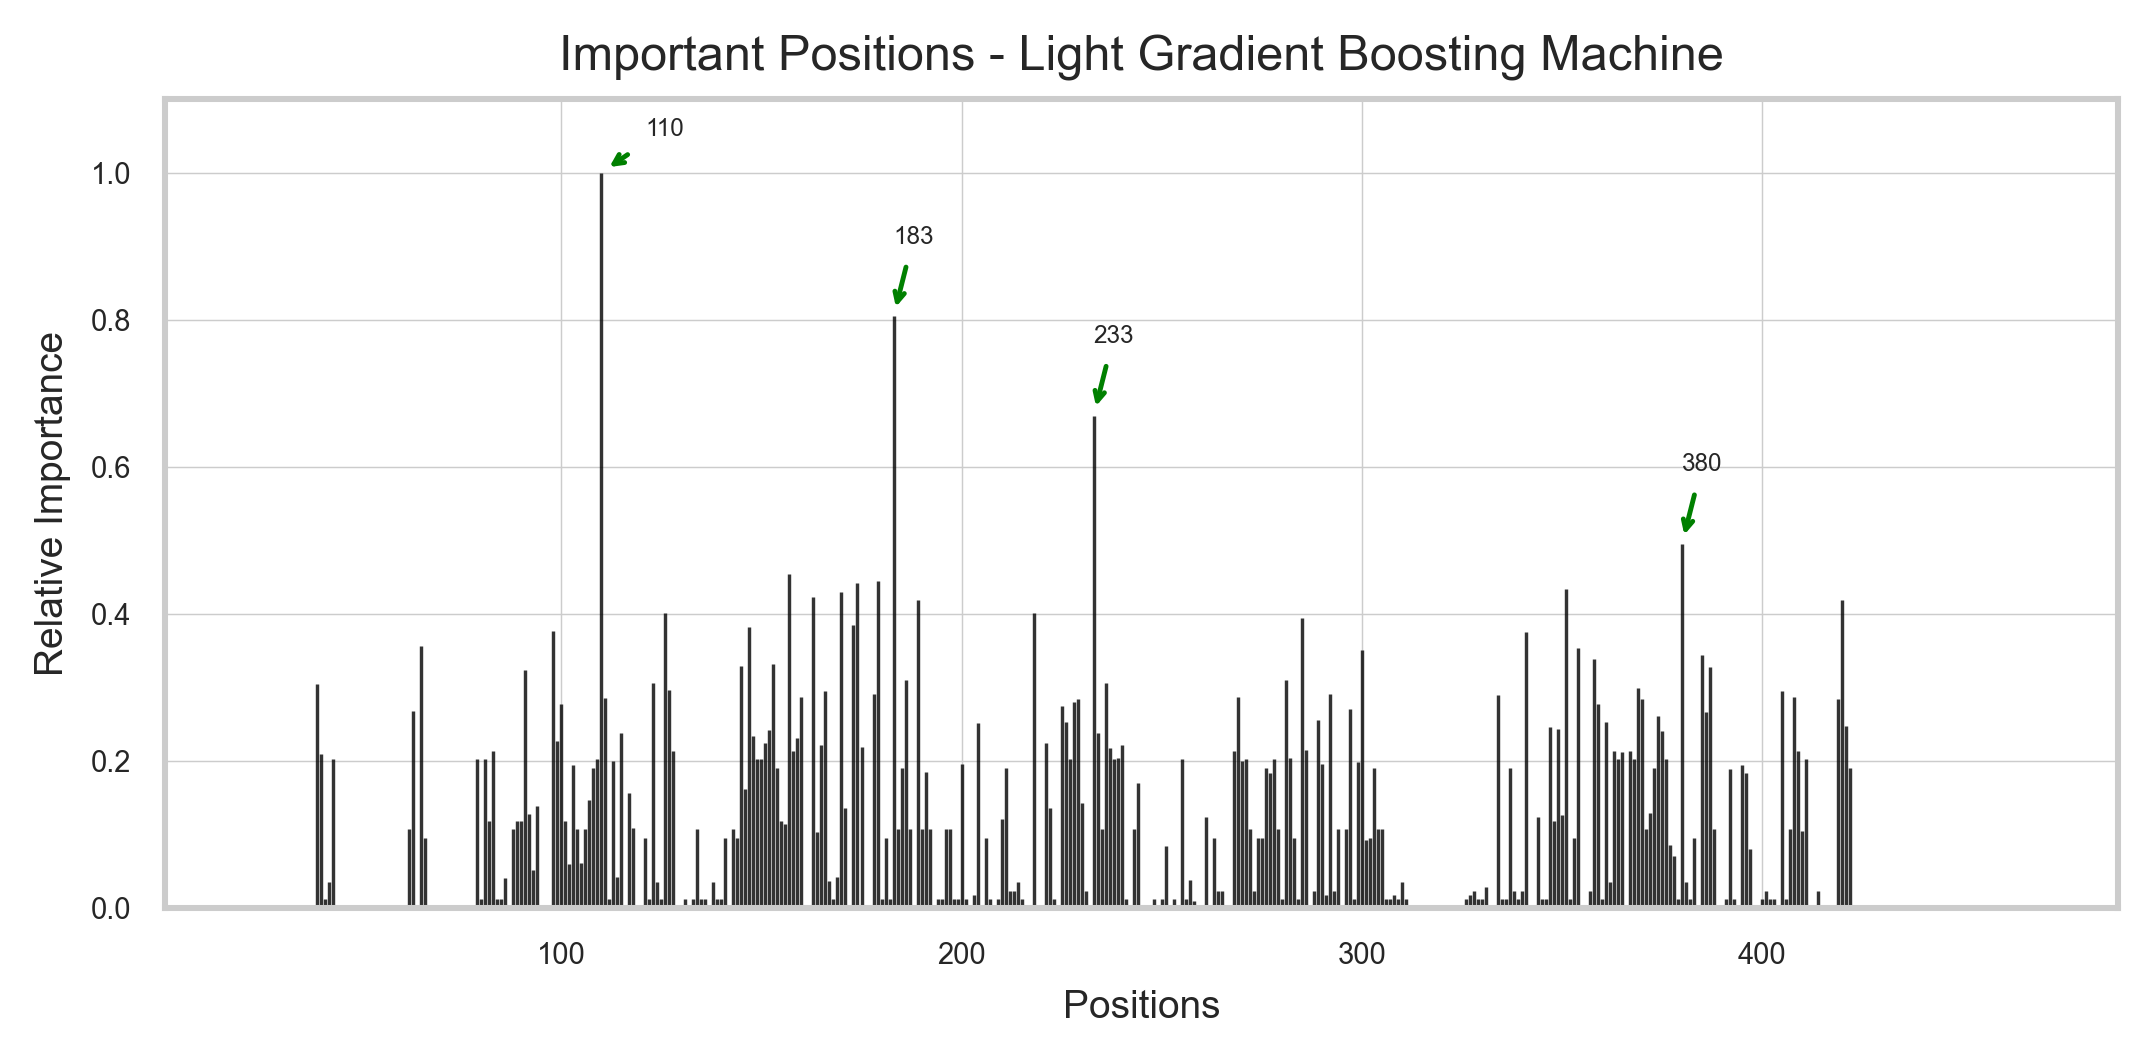

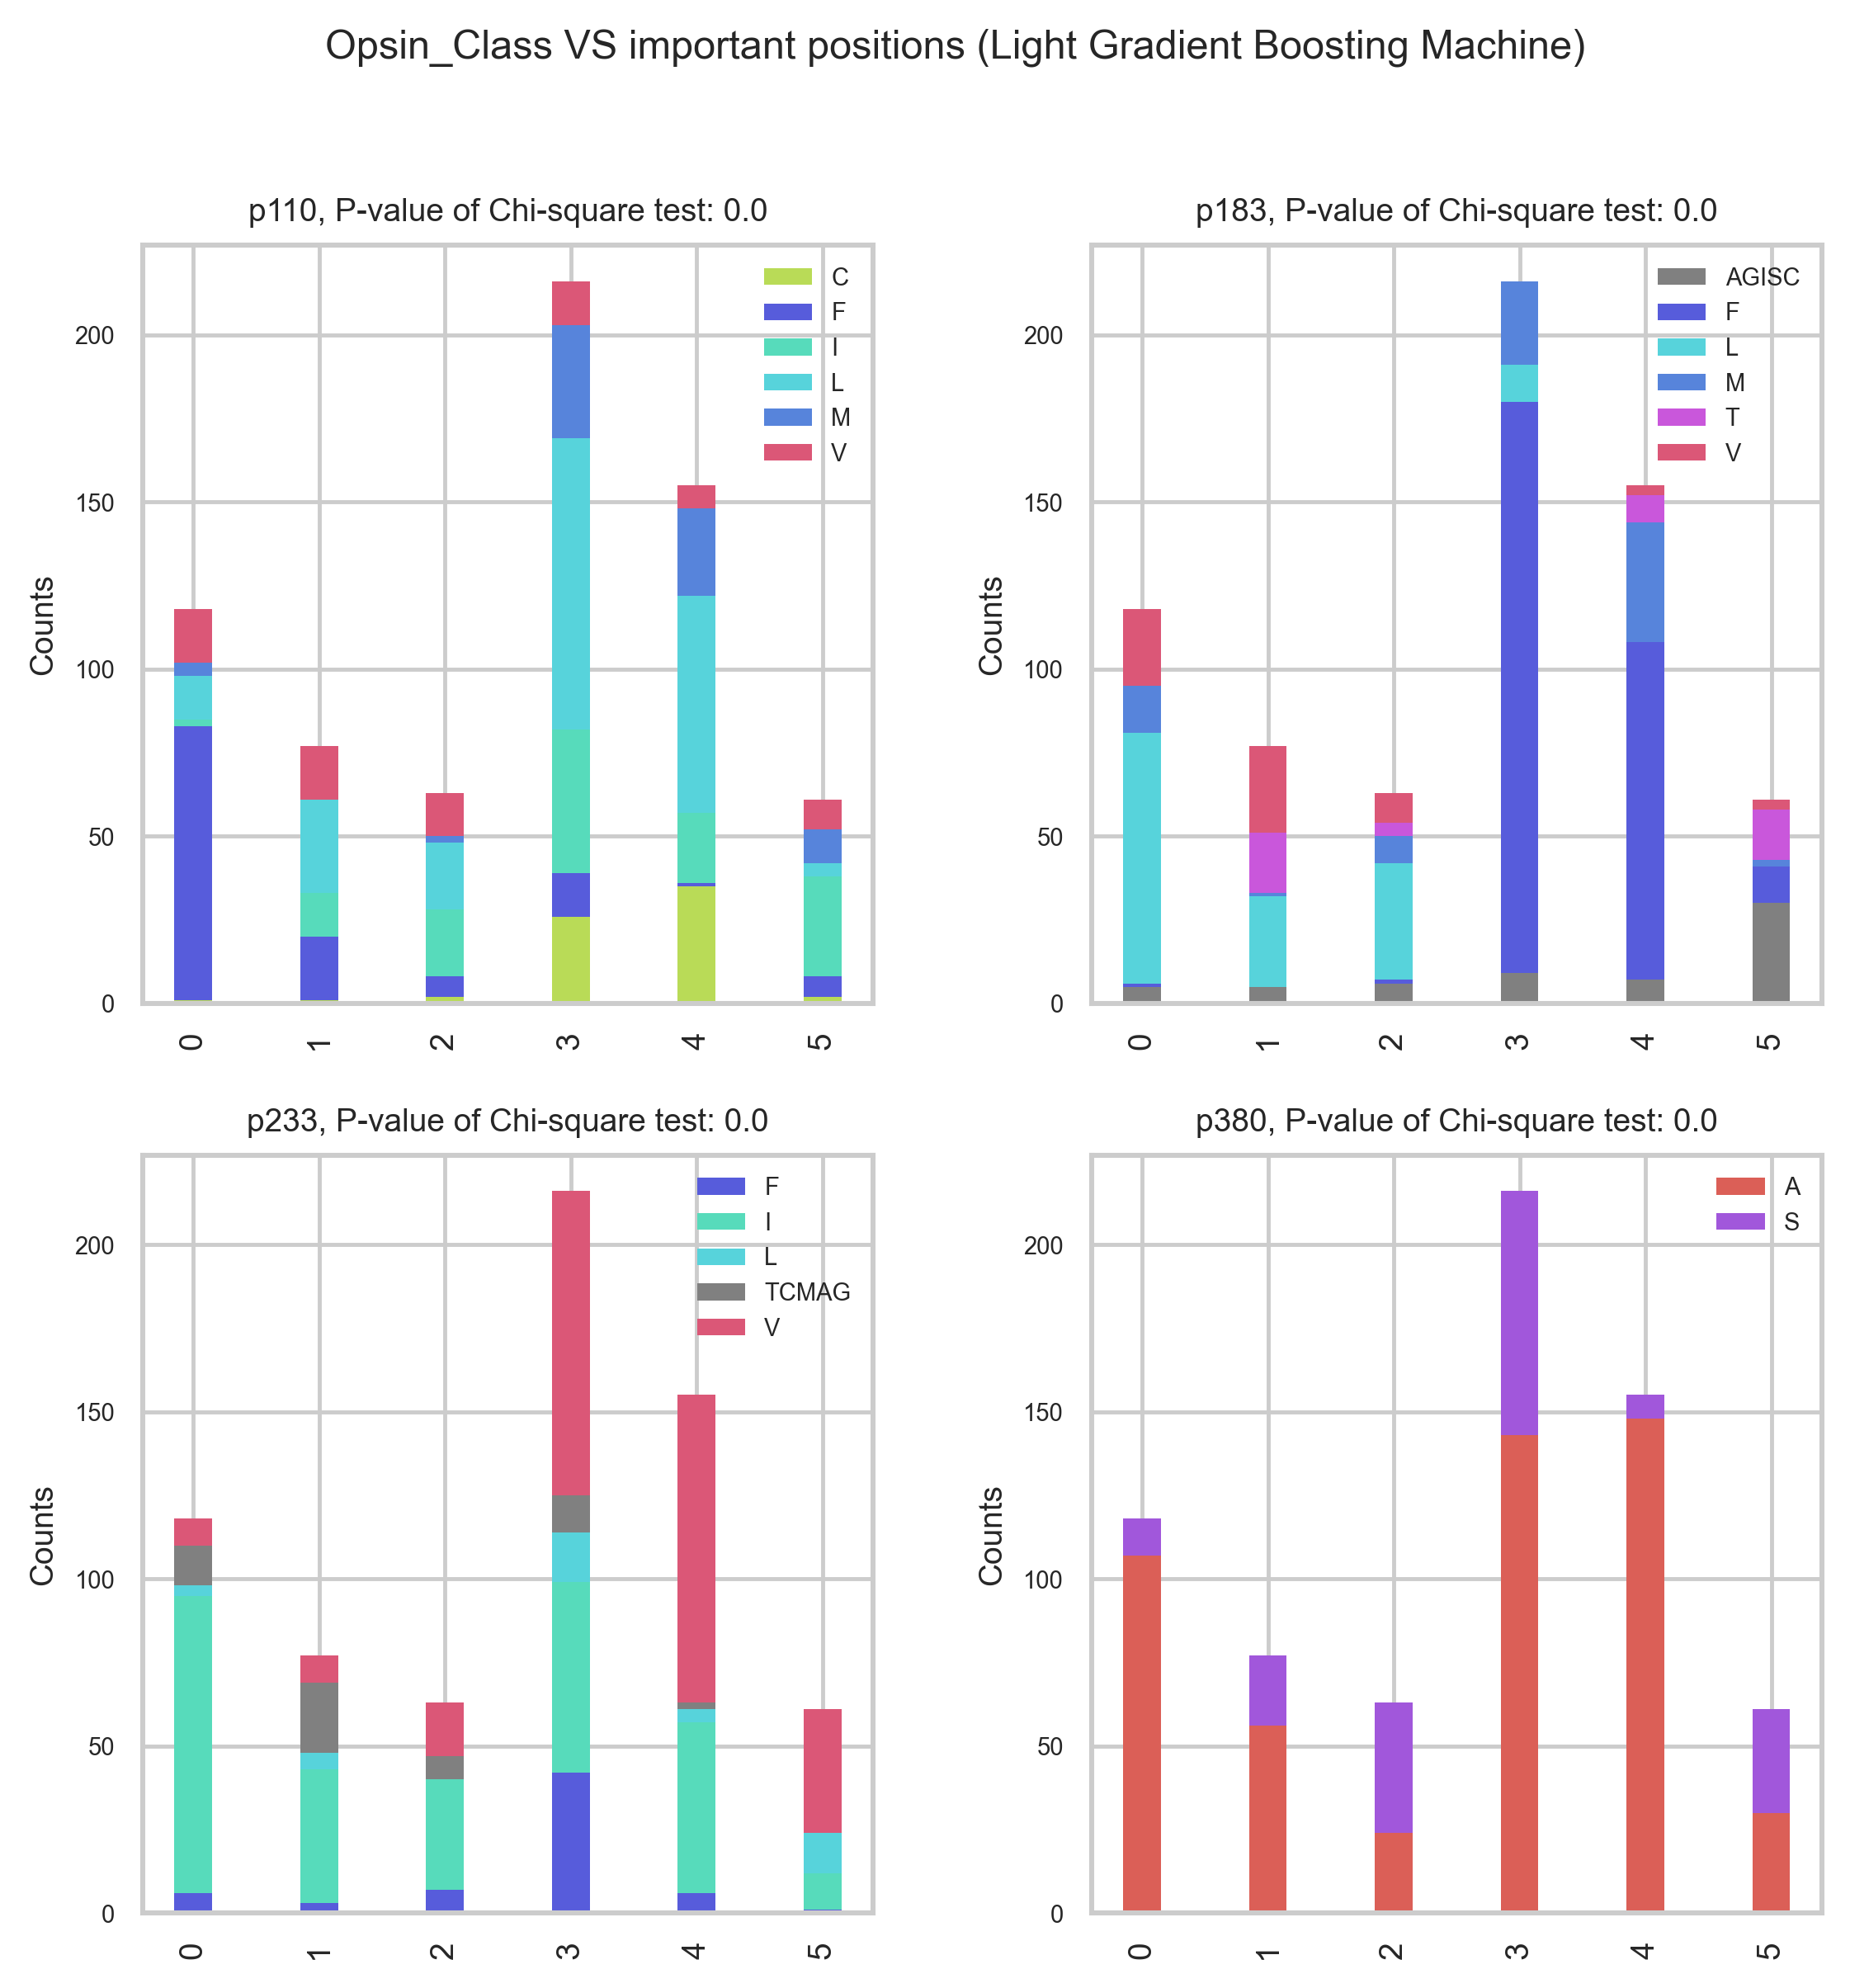

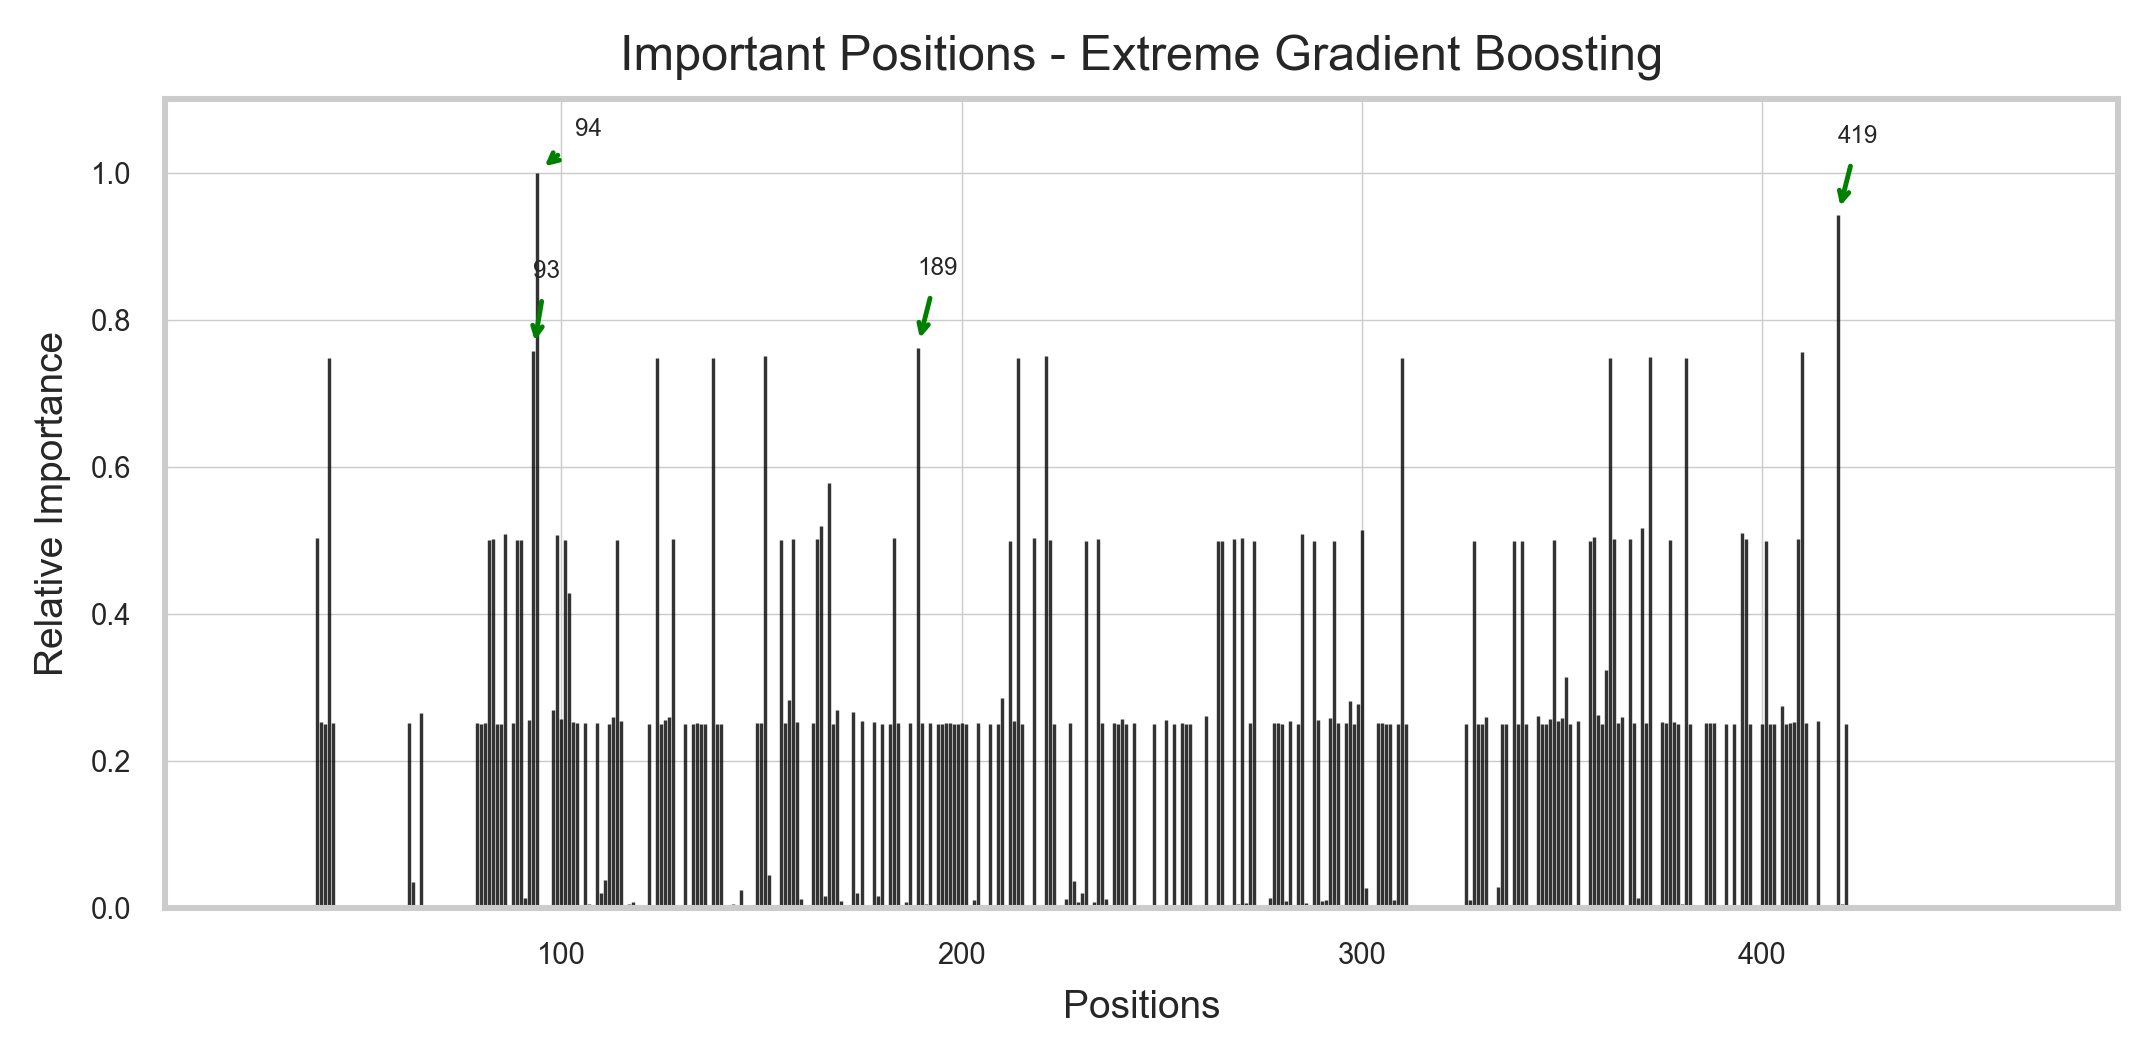

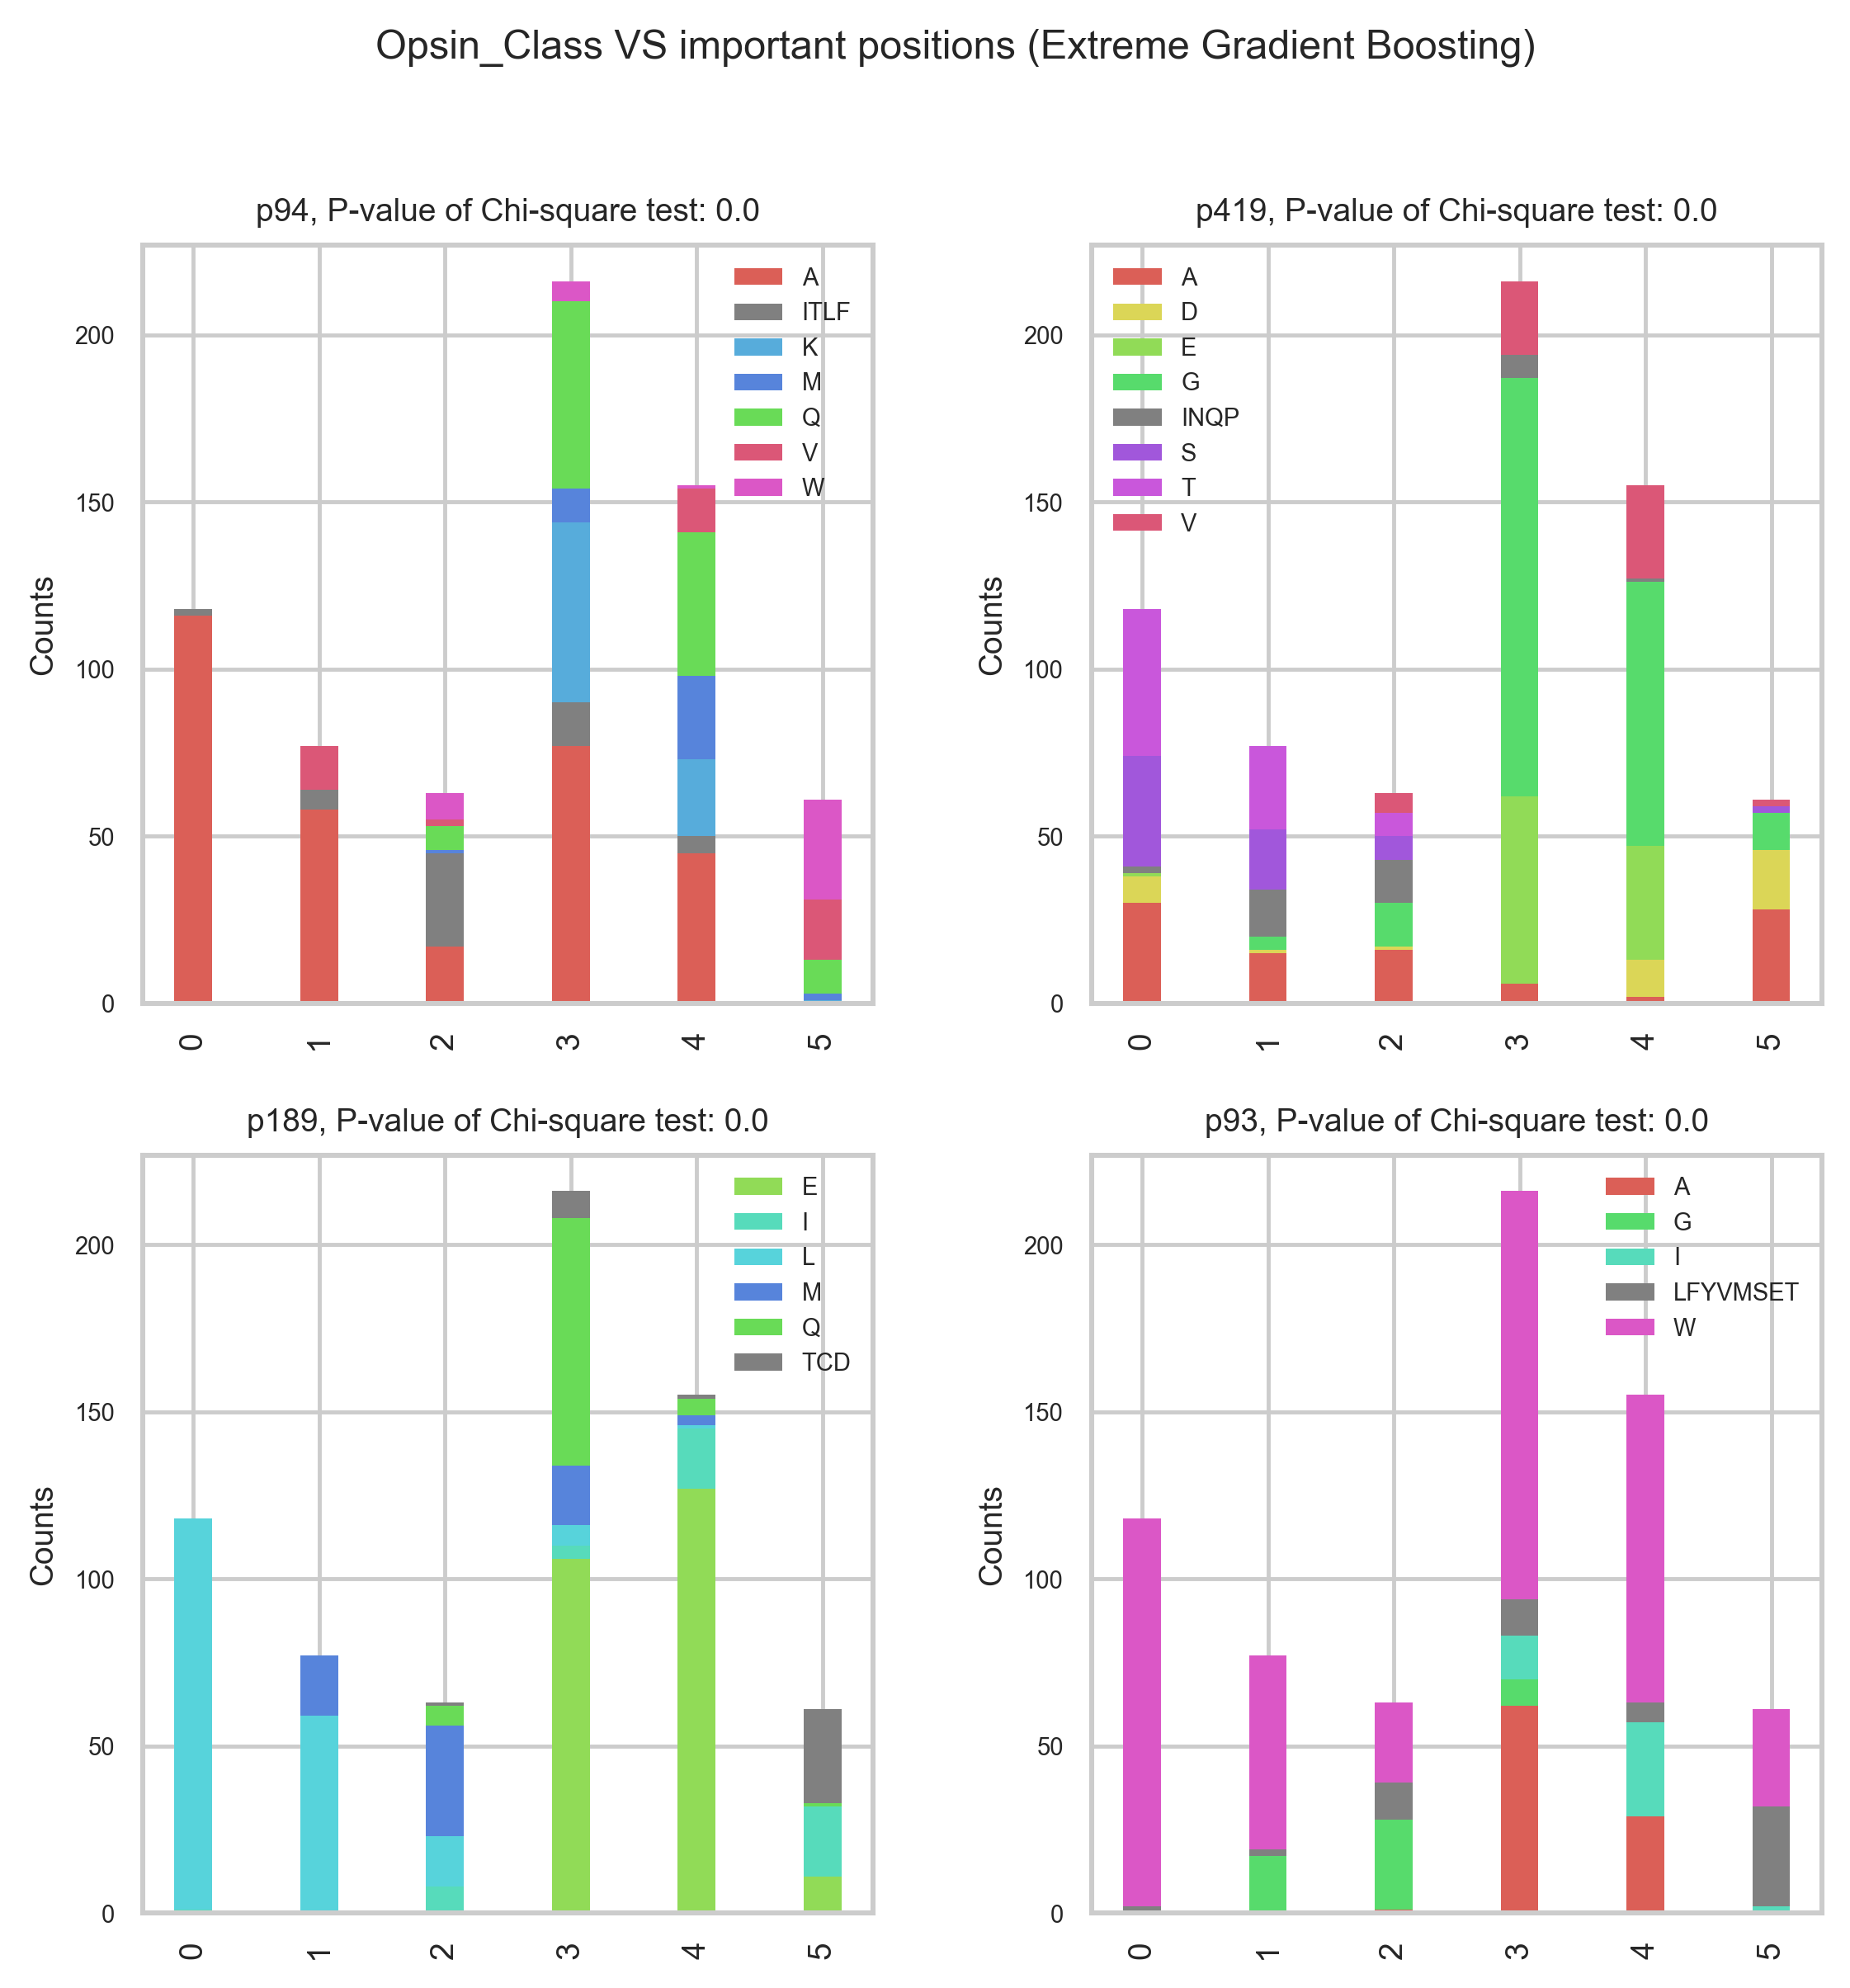

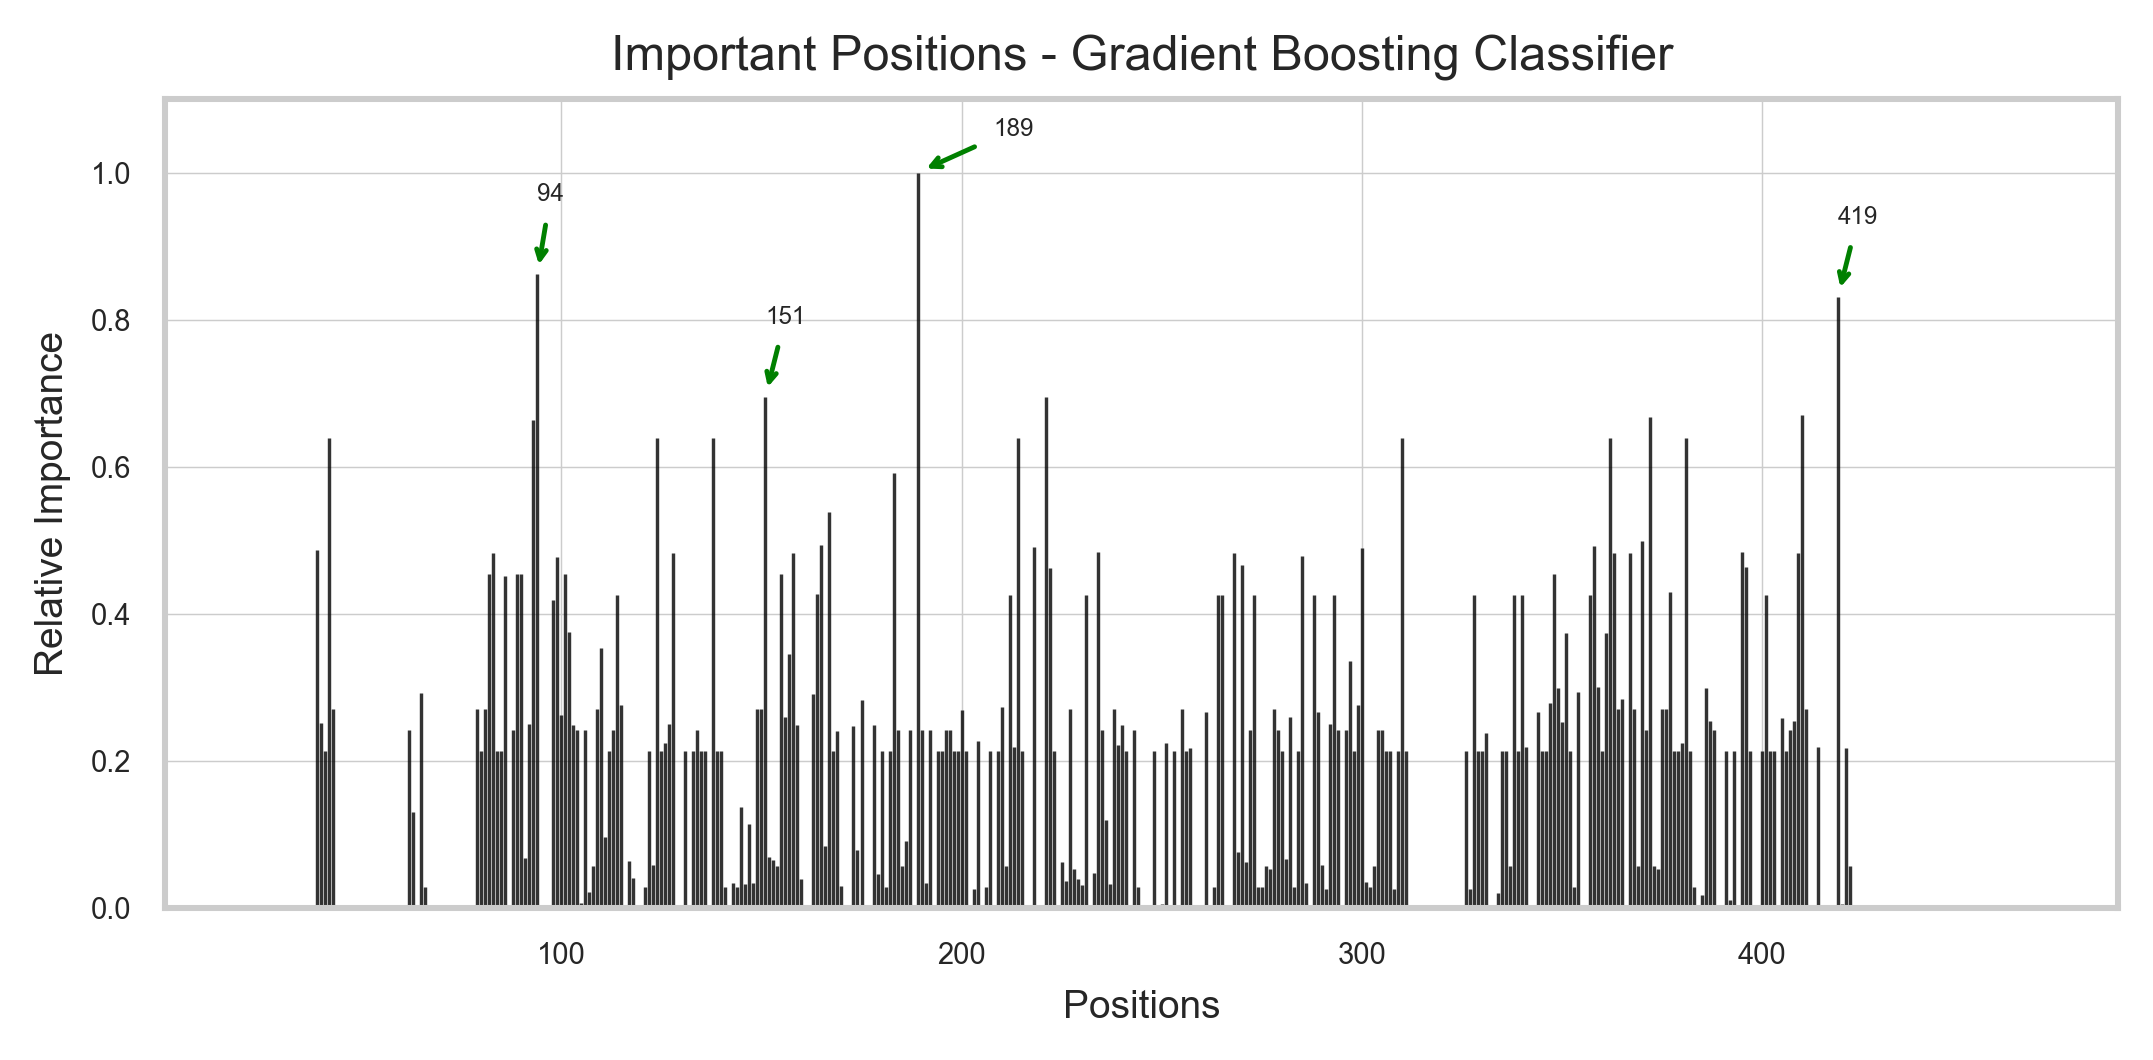

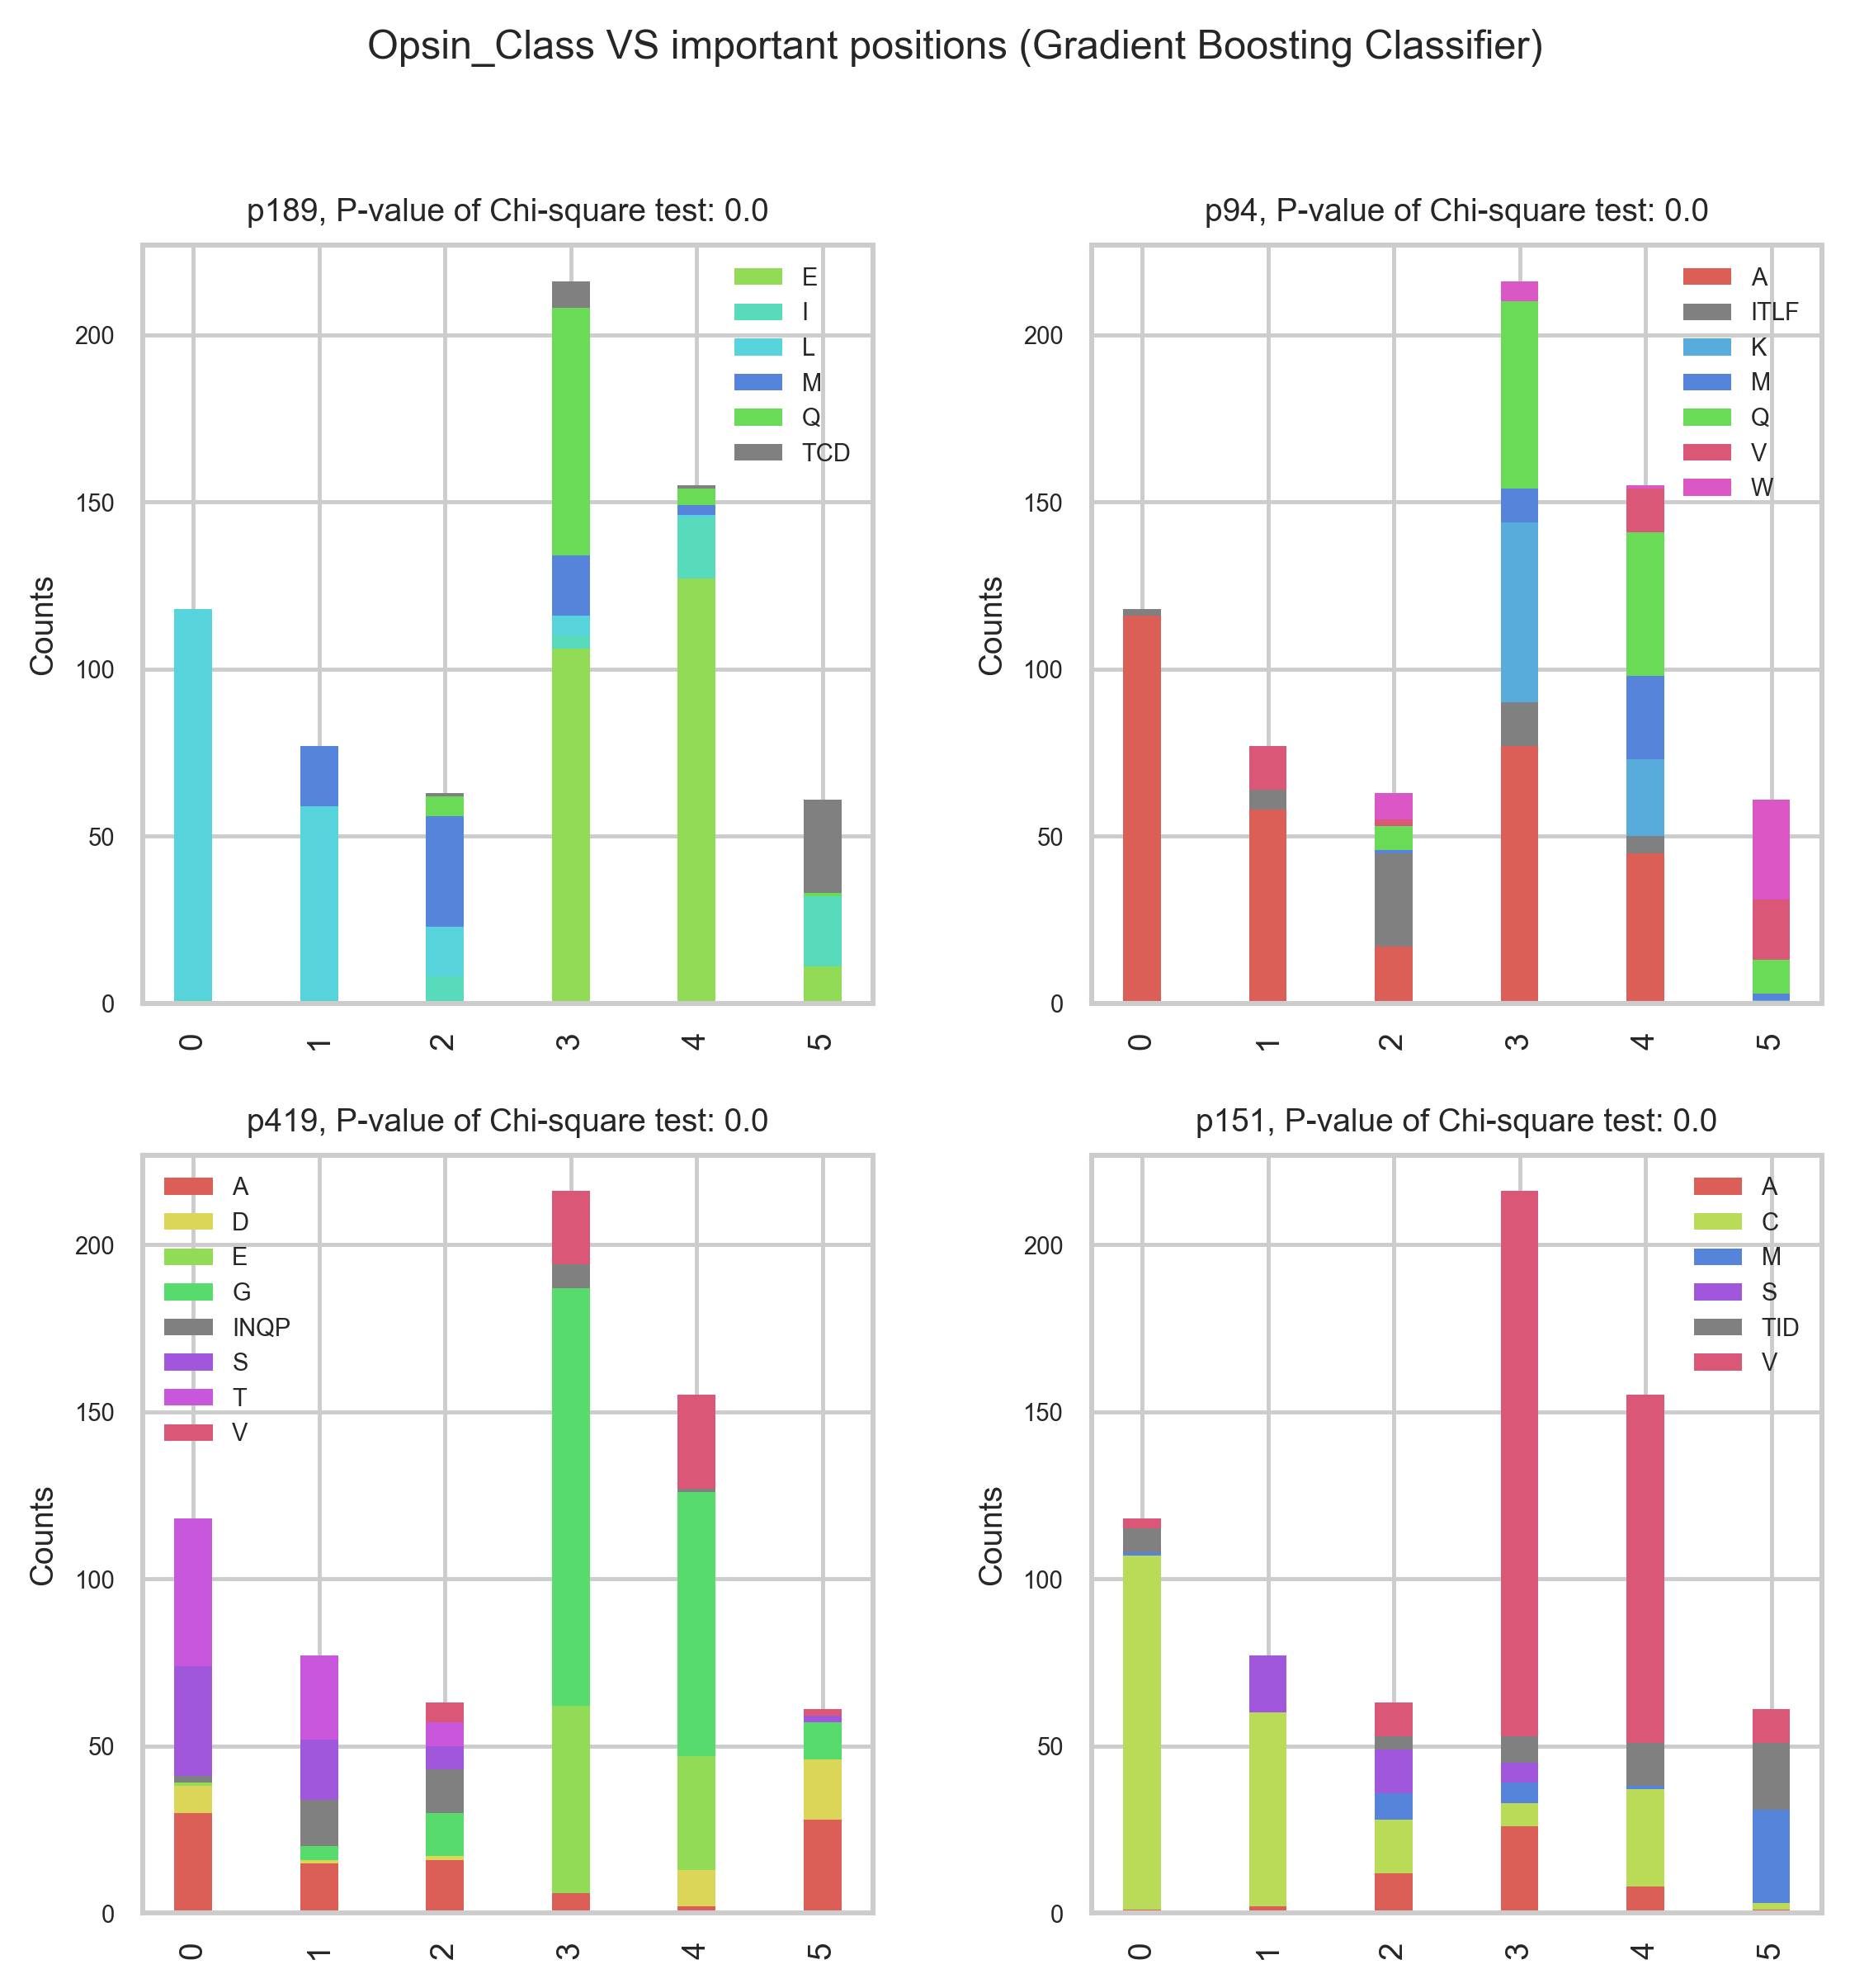

In [21]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i],
                         train_cols=train_cols, grouped_features=dc,
                         n_positions=positions, report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the boxplots for features based on each model
    viz.plot_imp_model(dat=df, trained_model=top_models[i],
                       model_name=model_names[i],
                       train_cols=train_cols, grouped_features=dc,
                       meta_var=mt, n_positions=positions,
                       model_type=anaType, report_dir=report_dir)

    file2 = open('interpret_cols.txt', 'a+')
    training = str(df.to_string)
    file2.write(training)
    file2.close()

meanDone


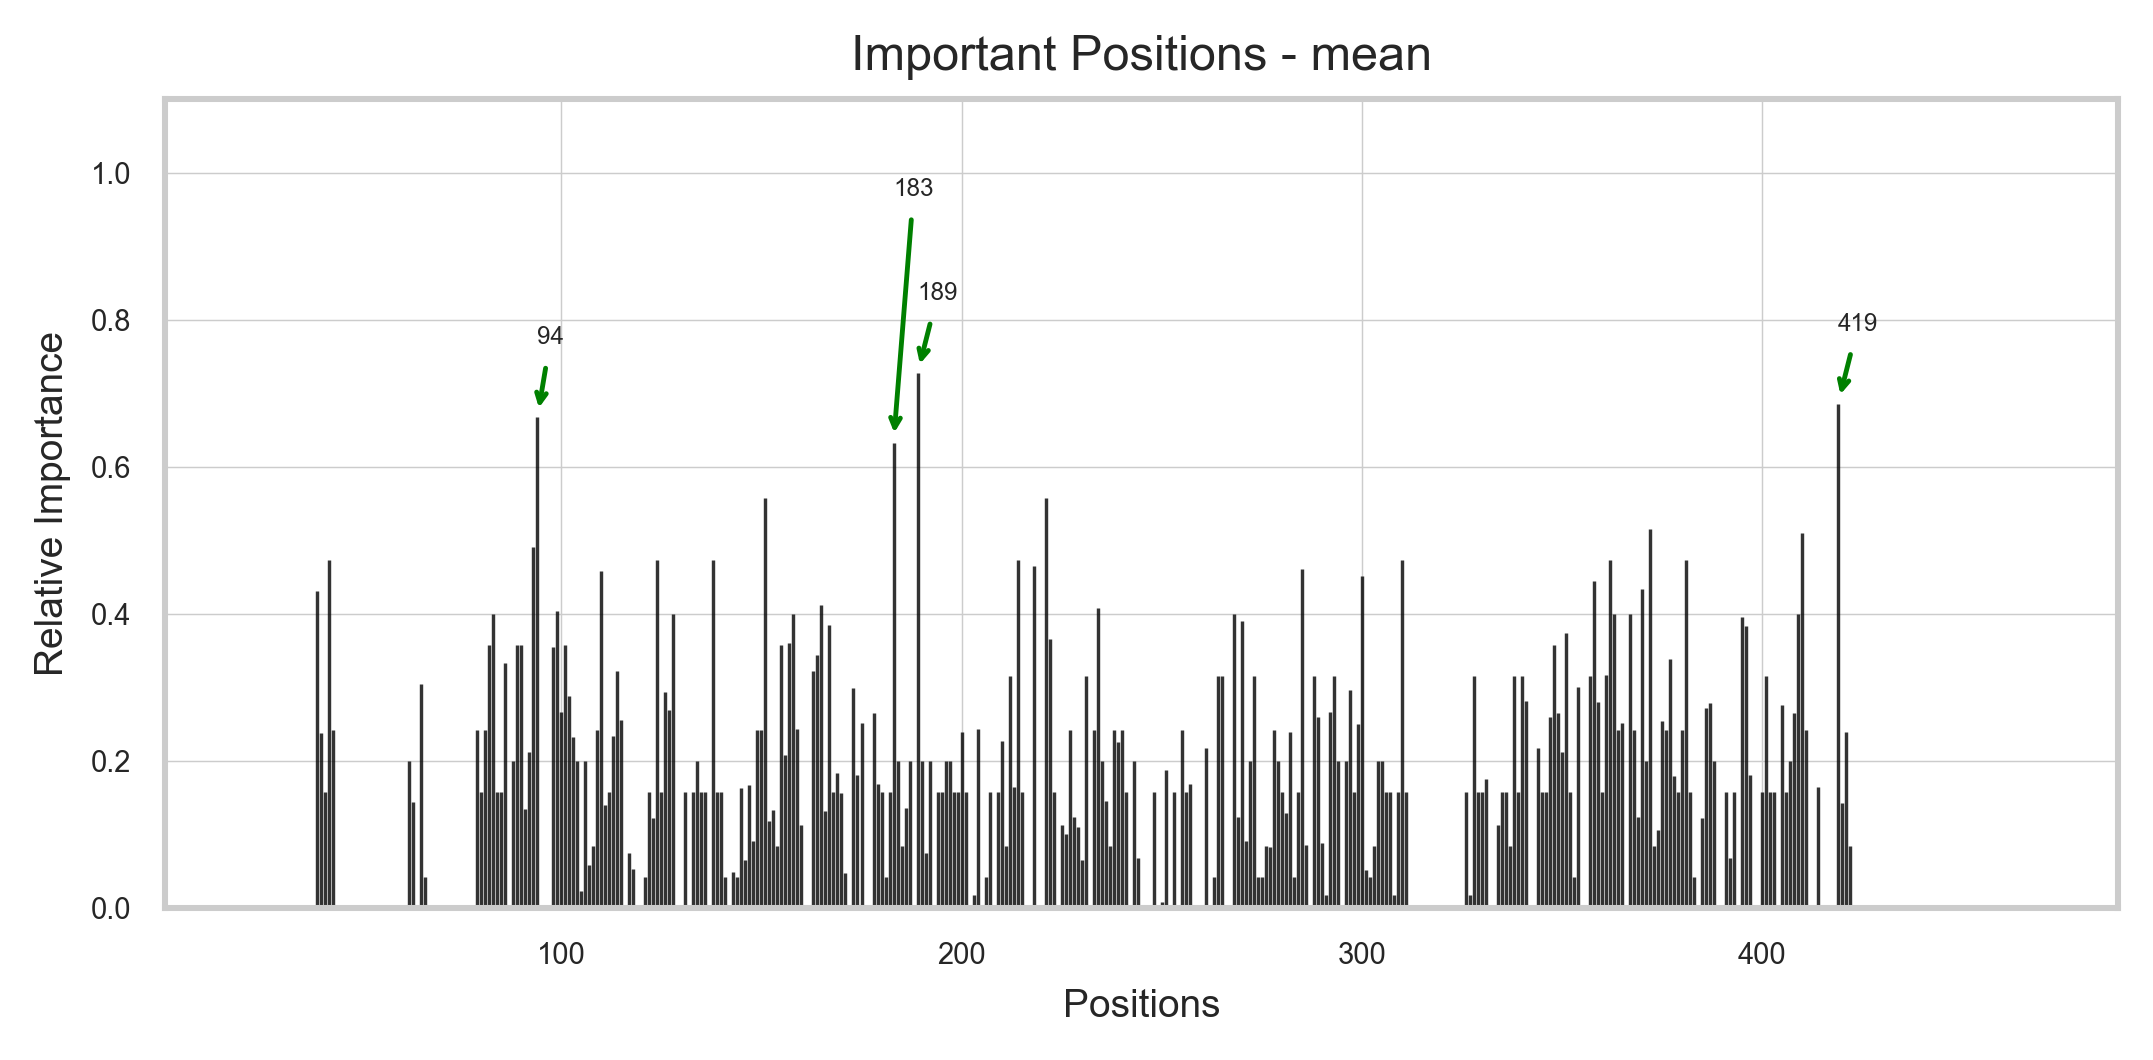

In [22]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc,
                              n_positions=positions,report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat=mean_imp,
            model_name= 'mean',
            imp_col='mean_imp', 
            report_dir=report_dir)

<span style="color:red">**Running the next cell will produce individual plots for all of the positions in you sequence.**</span>

{'p110': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p110, P-value: 0.0'}, ylabel='Counts'>),
 'p183': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p183, P-value: 0.0'}, ylabel='Counts'>),
 'p233': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p233, P-value: 0.0'}, ylabel='Counts'>),
 'p380': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p380, P-value: 0.0'}, ylabel='Counts'>),
 'p157': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p157, P-value: 0.0'}, ylabel='Counts'>),
 'p179': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p179, P-value: 0.0'}, ylabel='Counts'>),
 'p174': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p174, P-value: 0.0'}, ylabel='Counts'>),
 'p351': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p351, P-value: 0.0'}, ylabel='Counts'>),
 'p170': (<Figure size 700x1050 

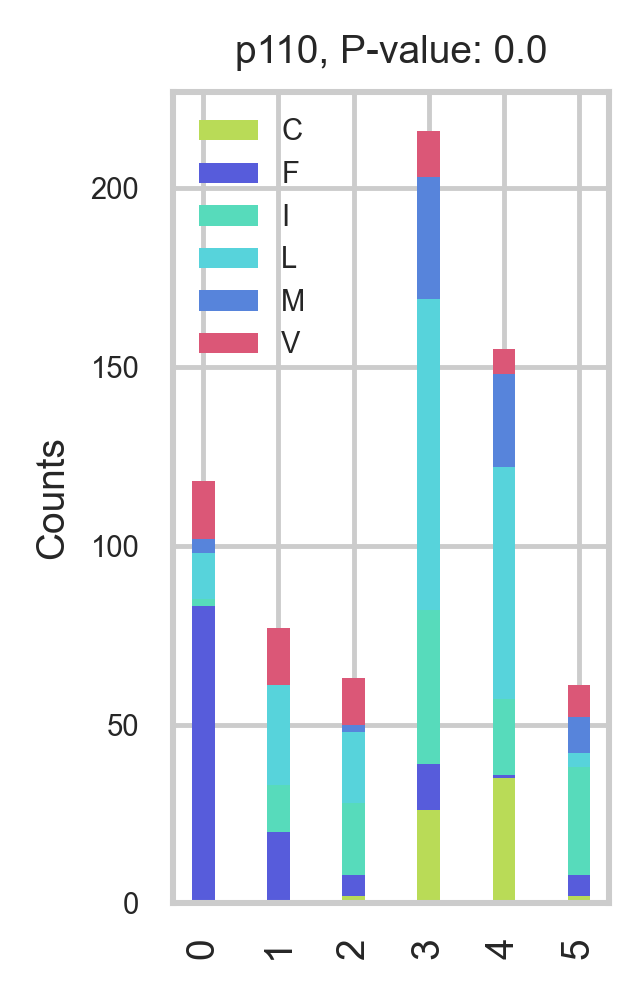

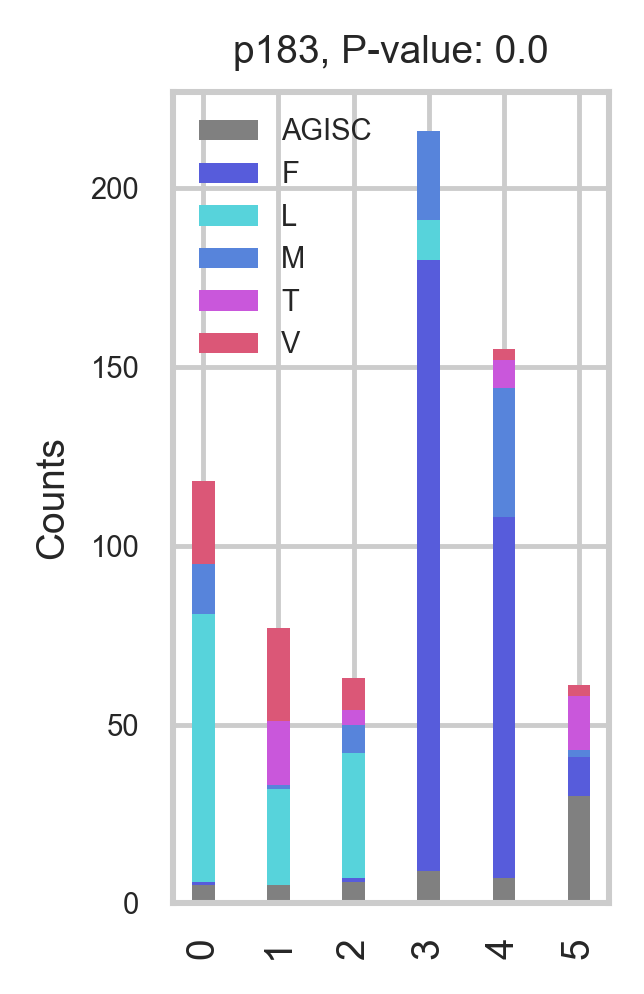

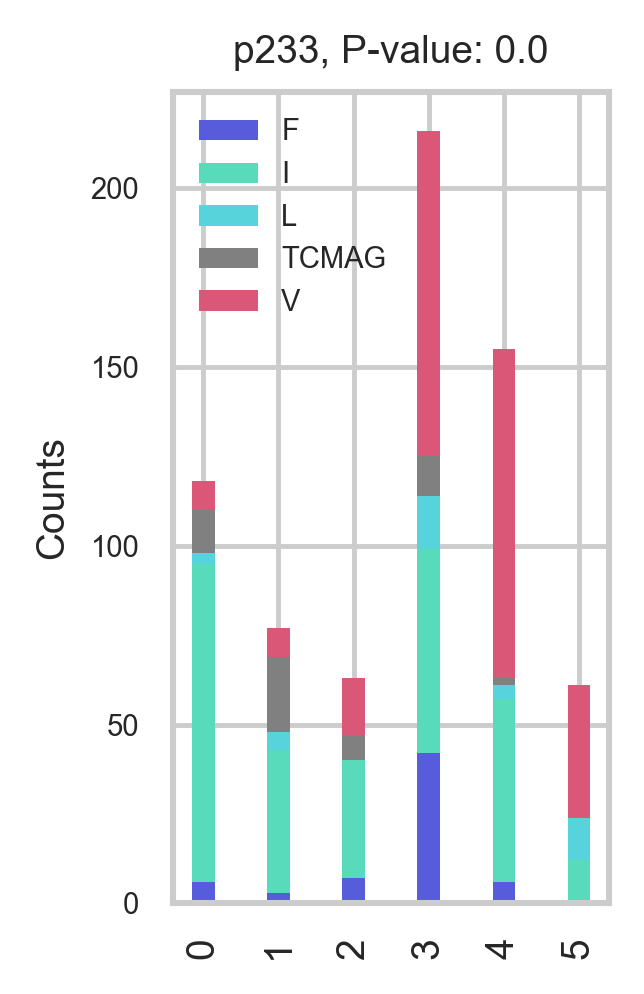

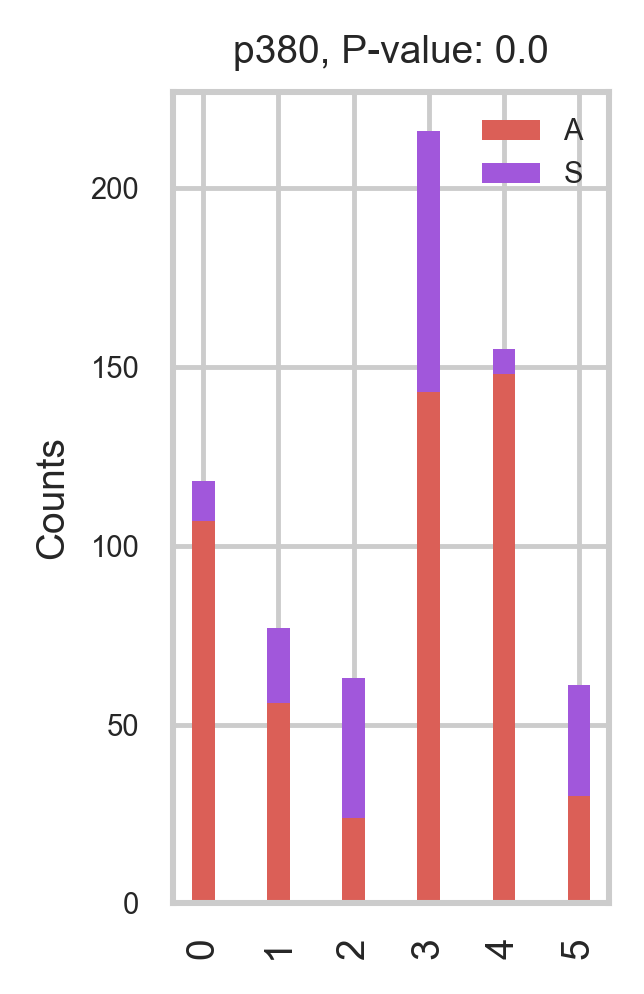

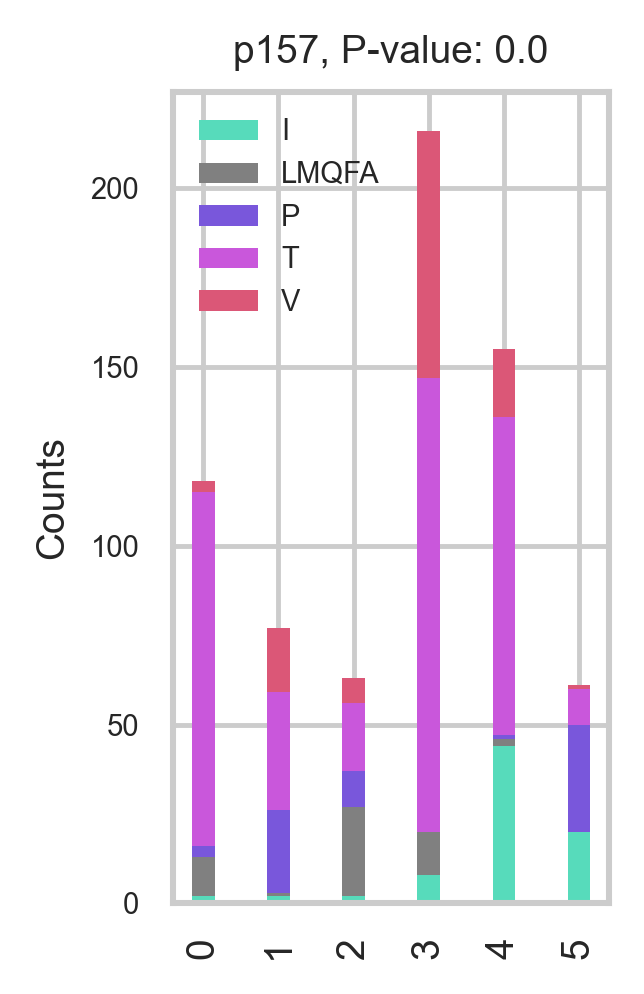

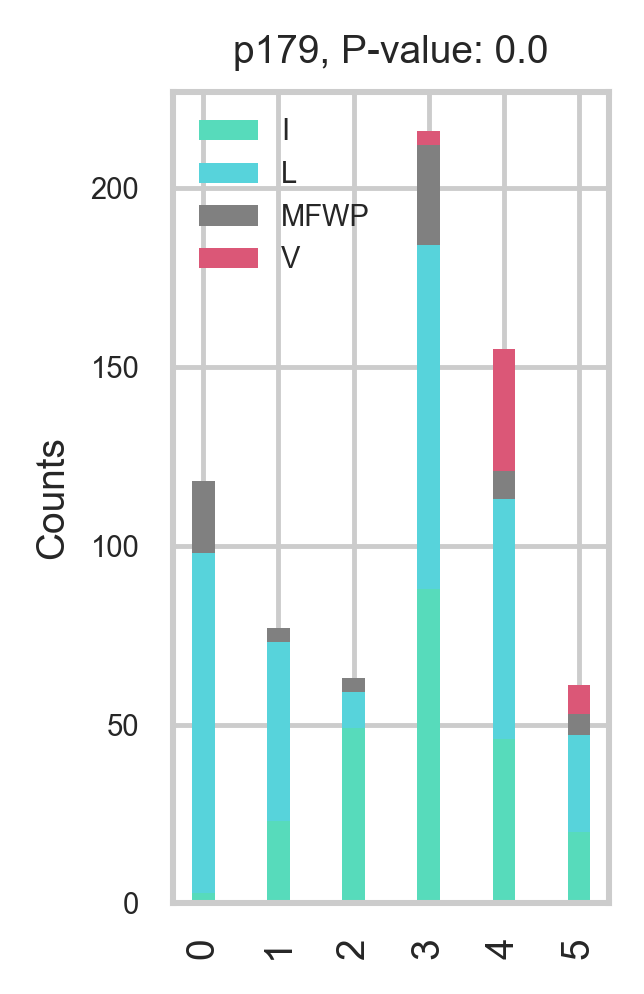

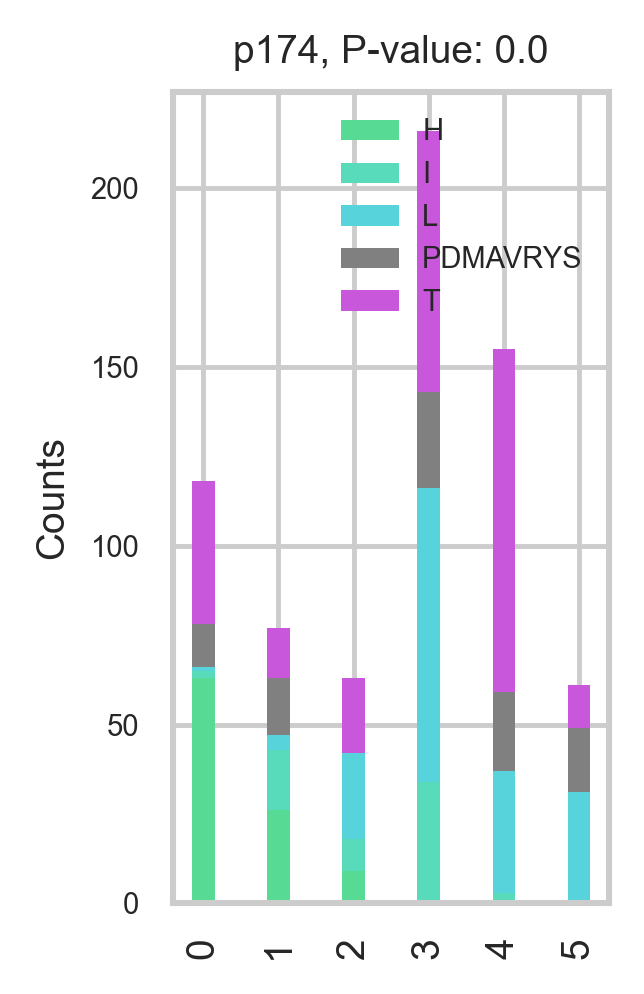

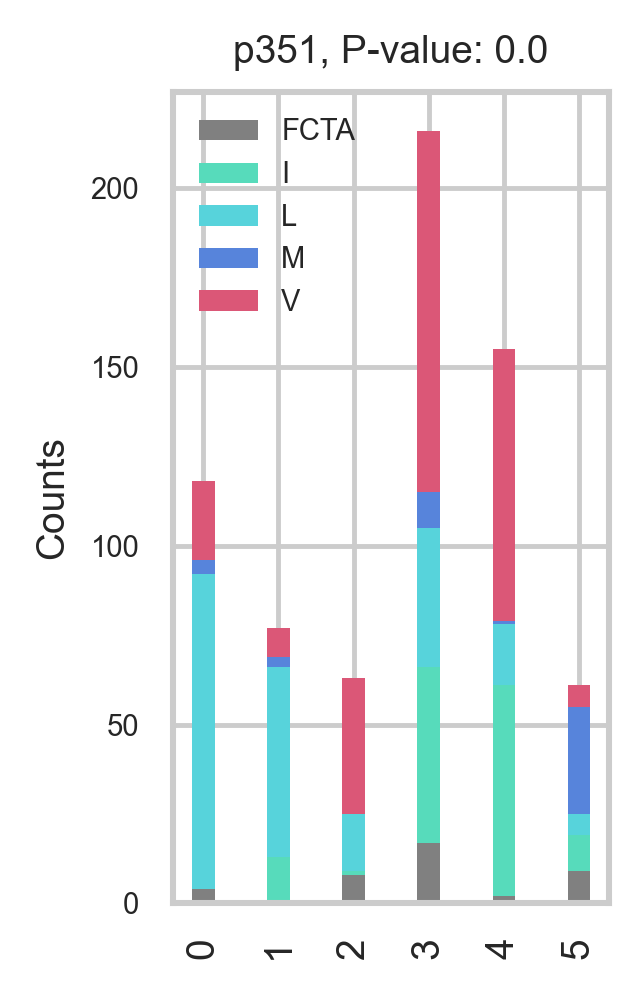

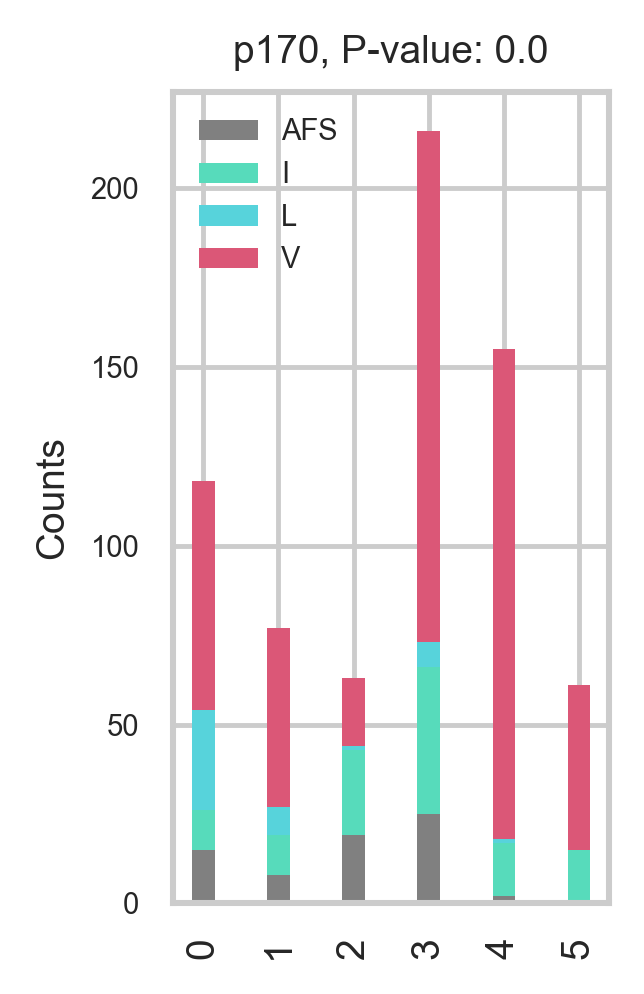

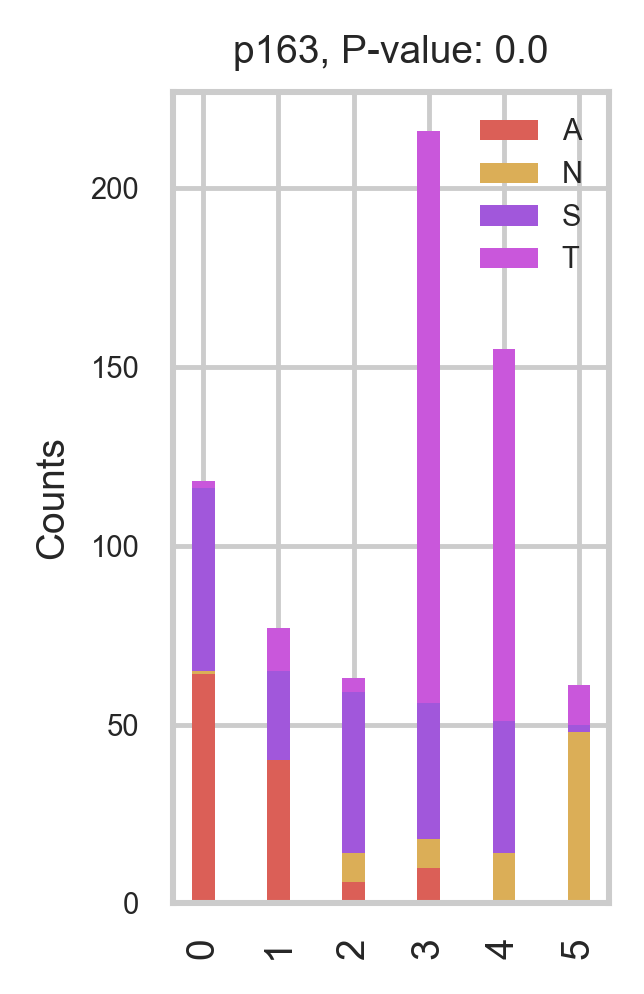

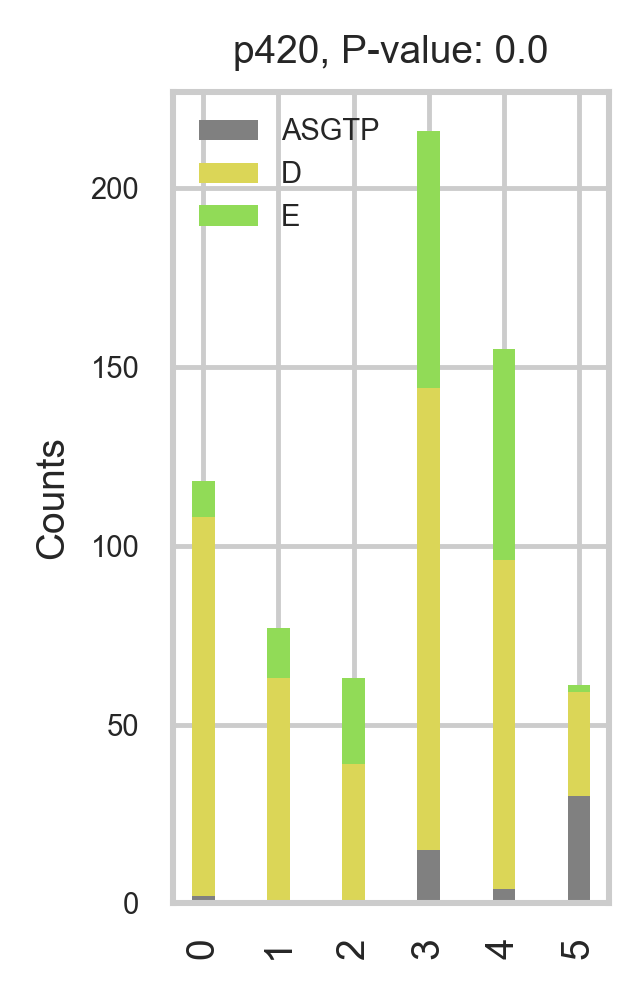

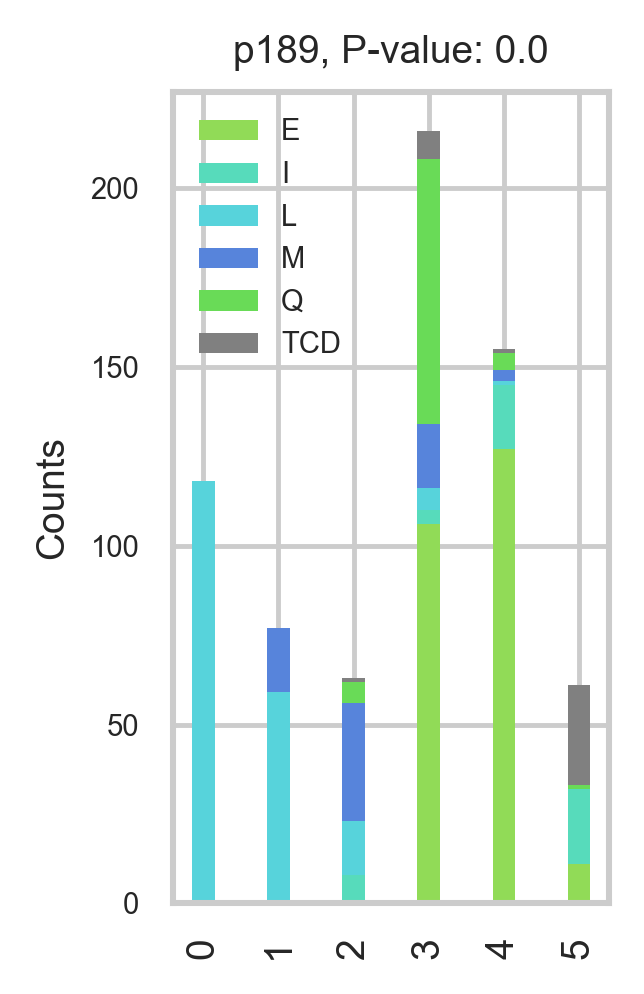

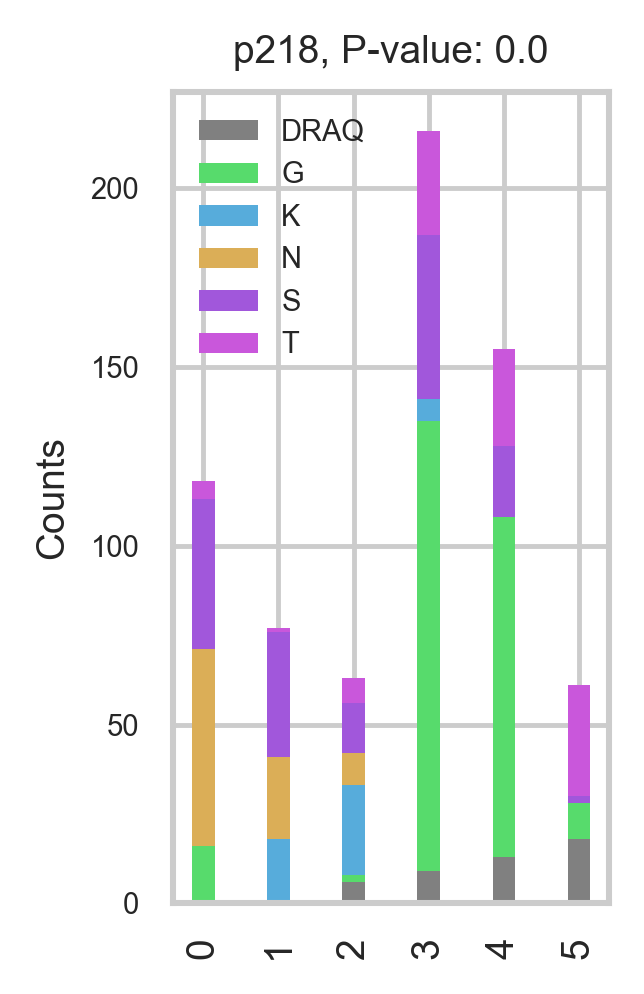

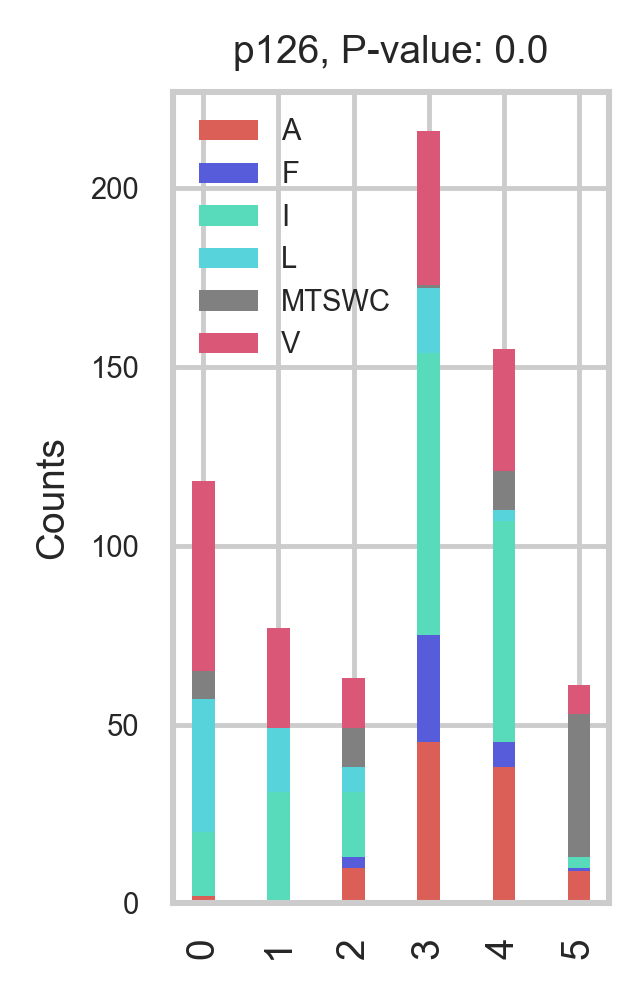

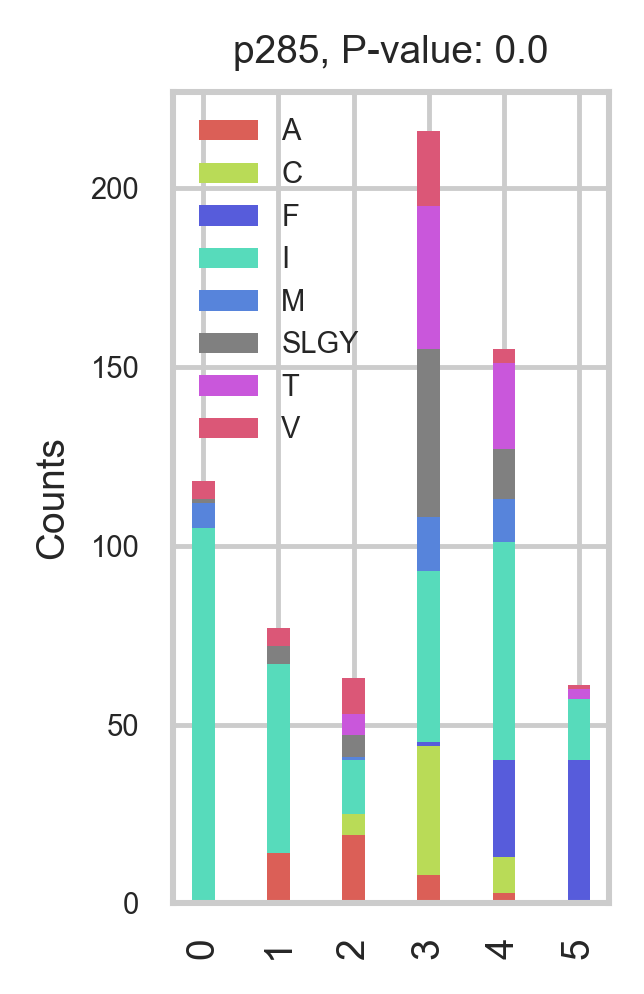

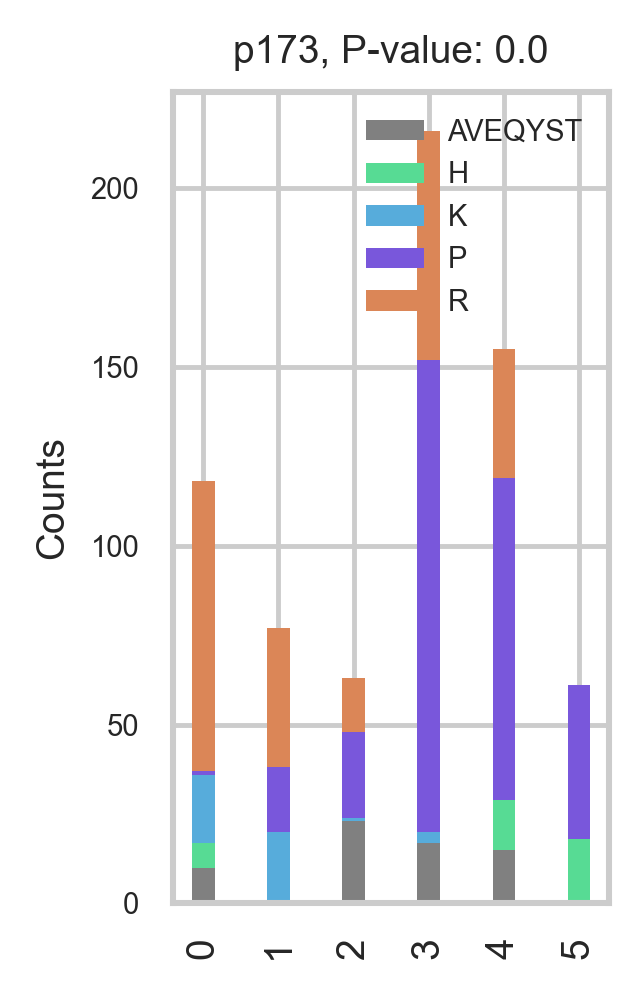

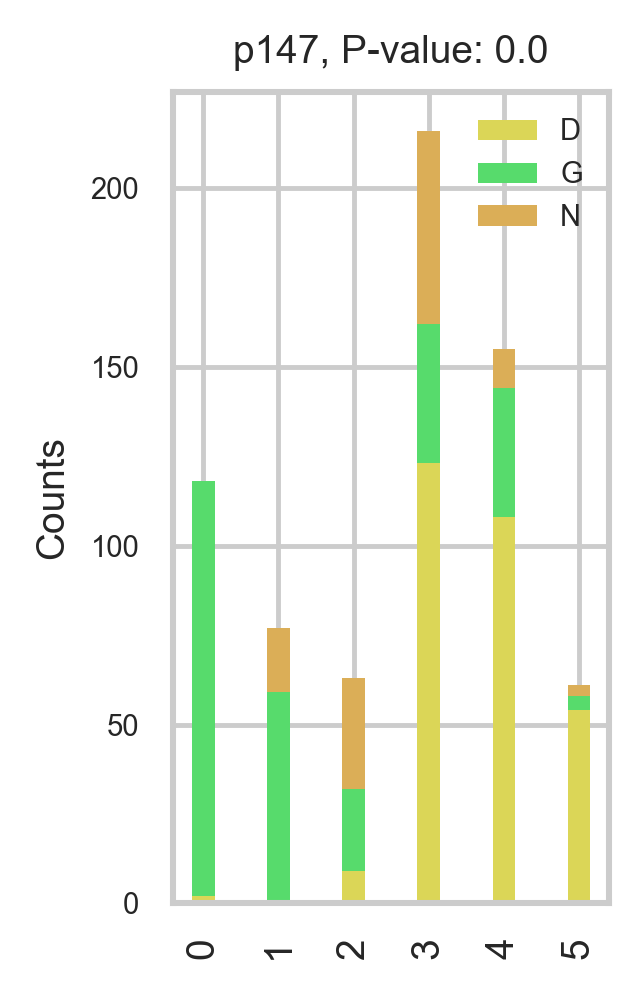

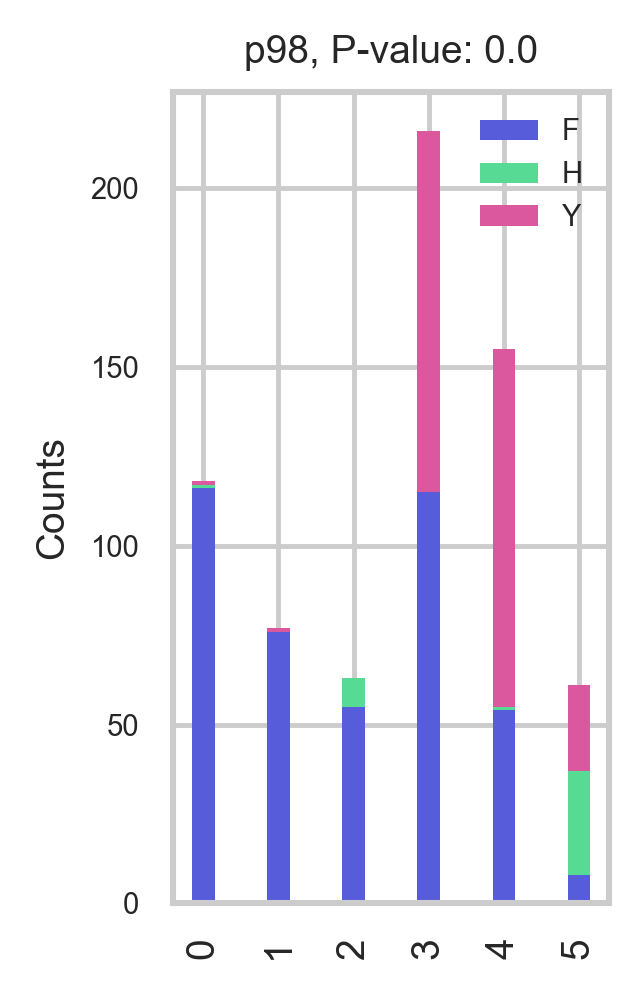

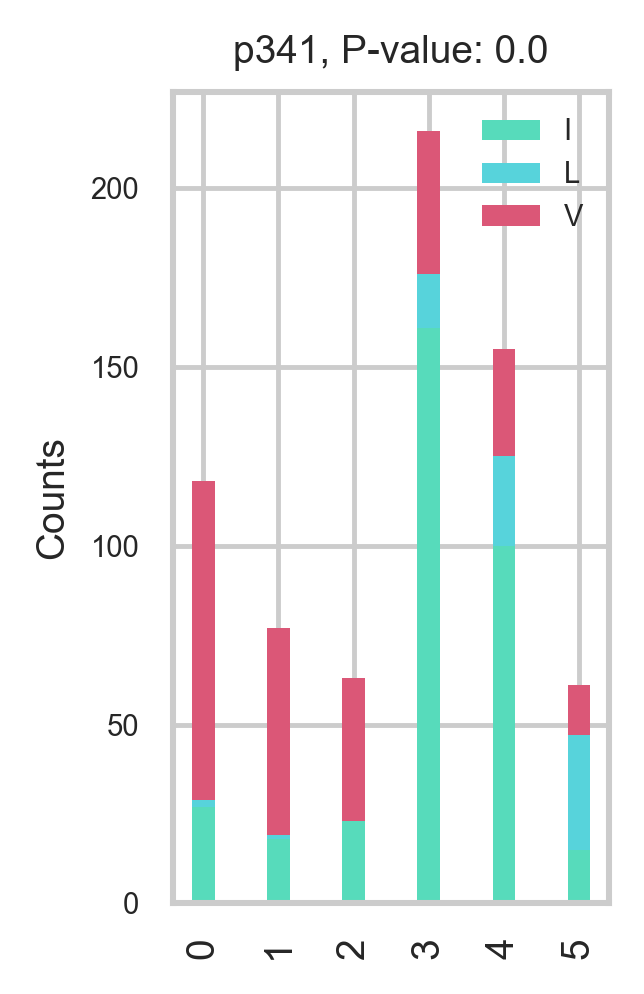

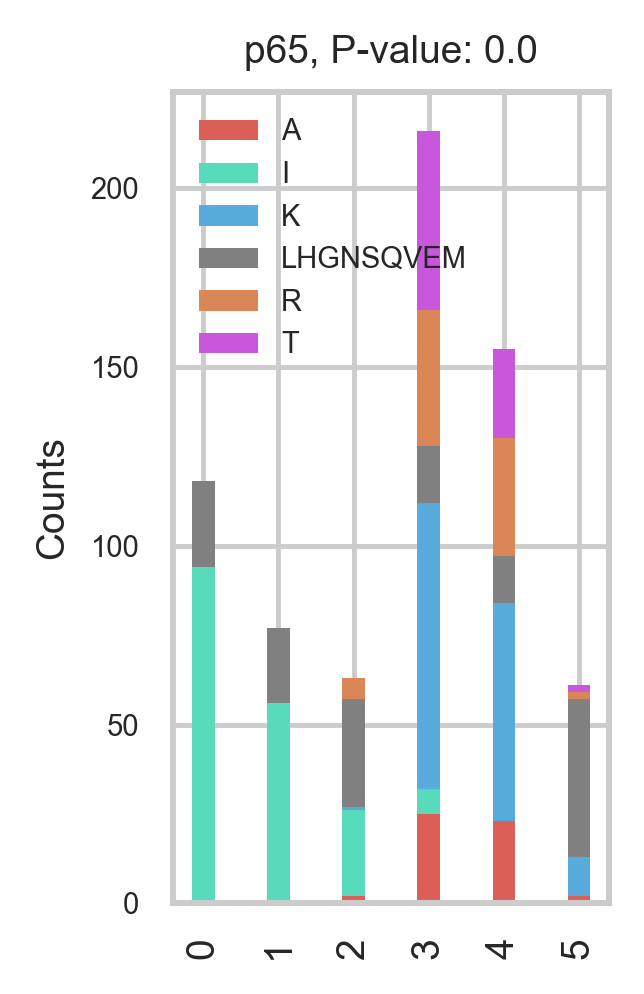

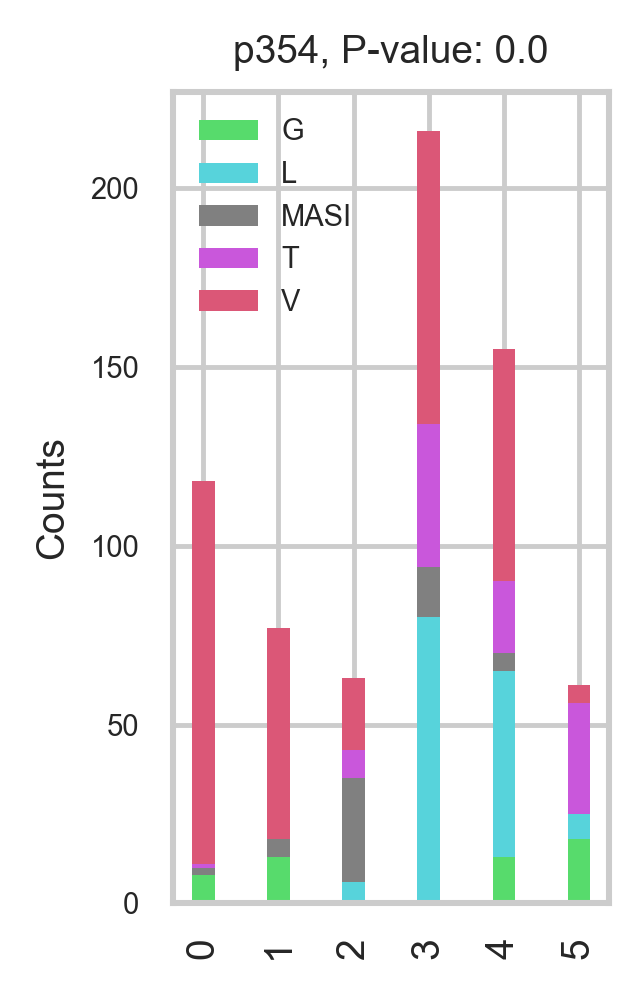

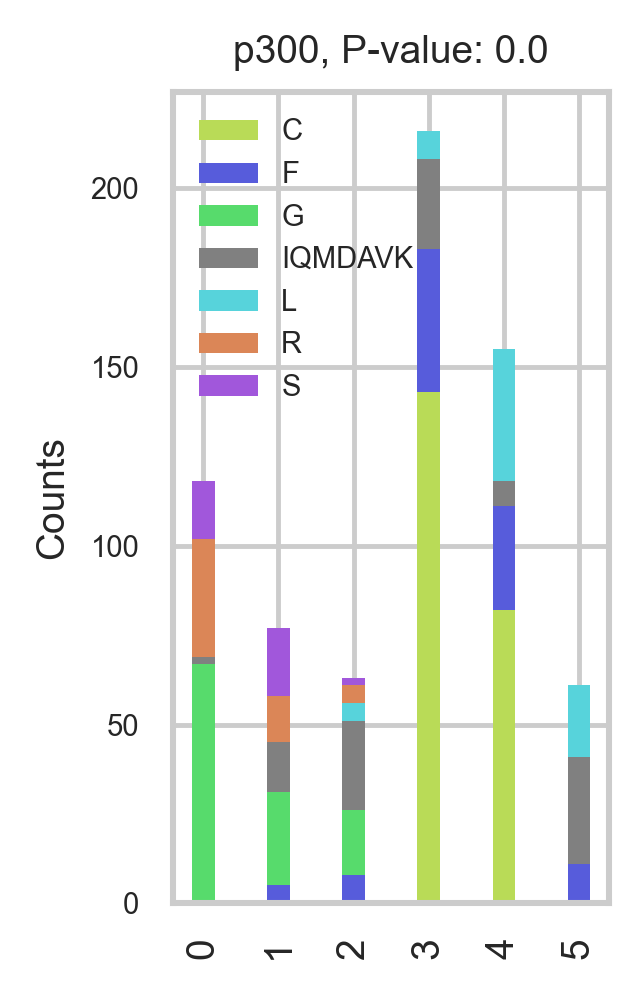

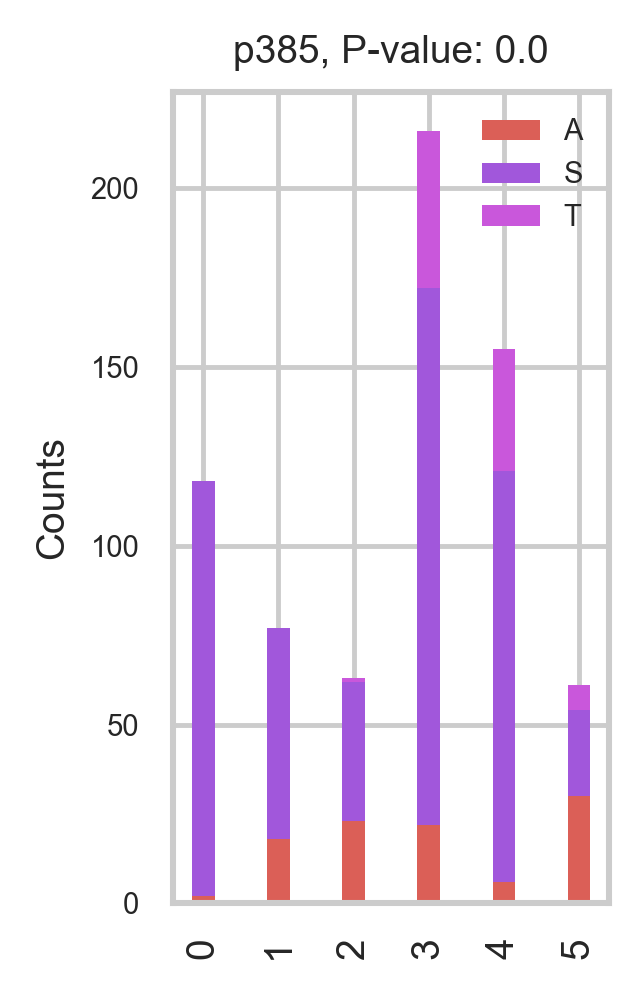

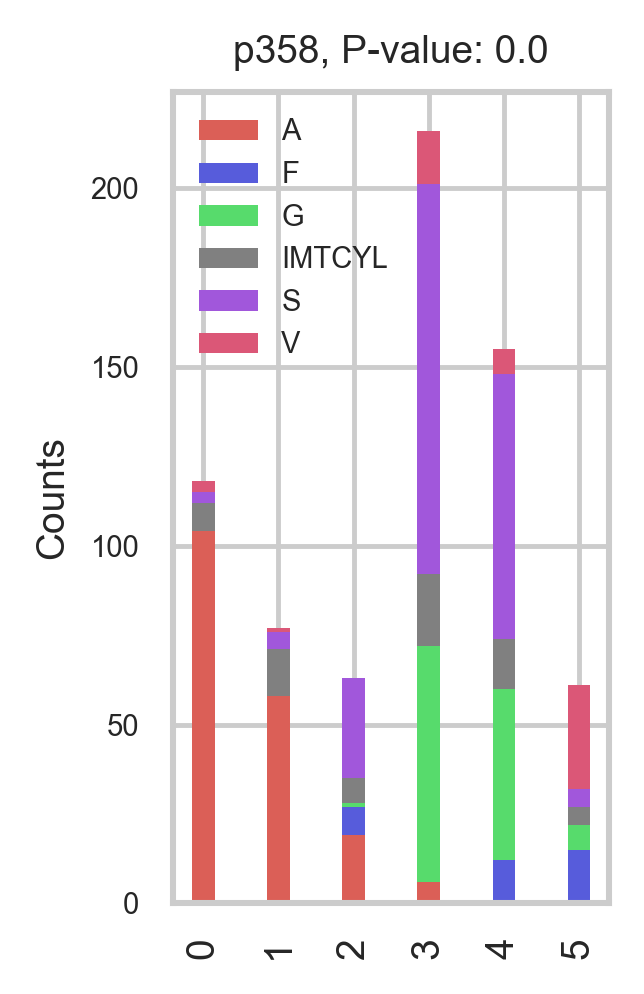

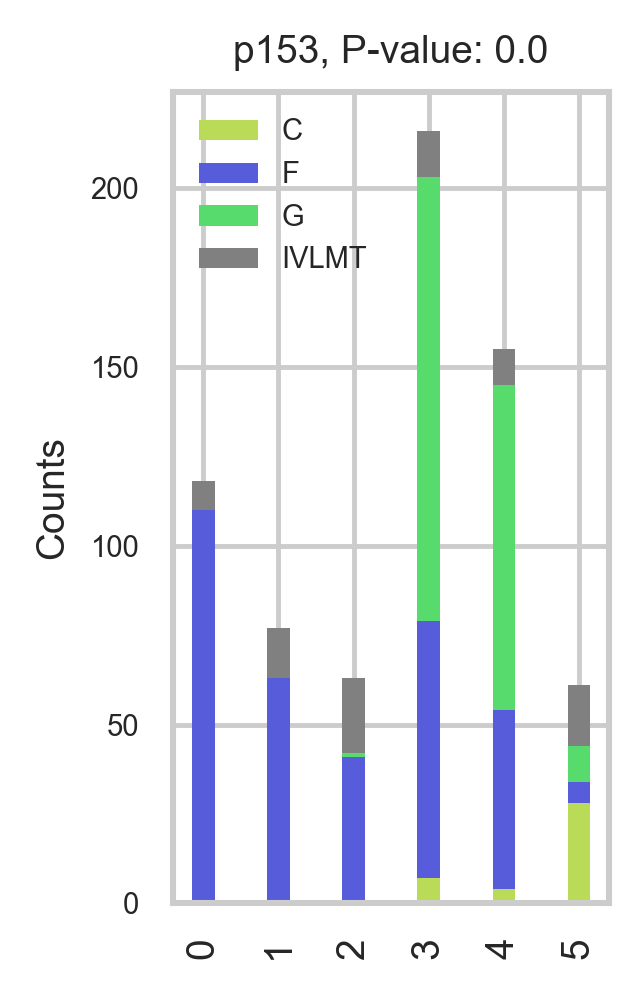

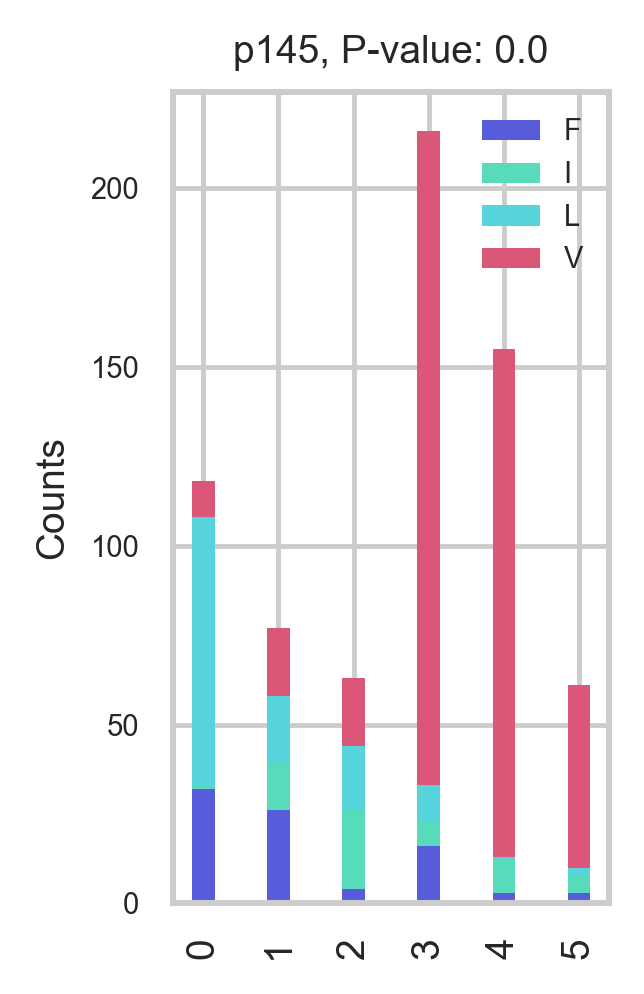

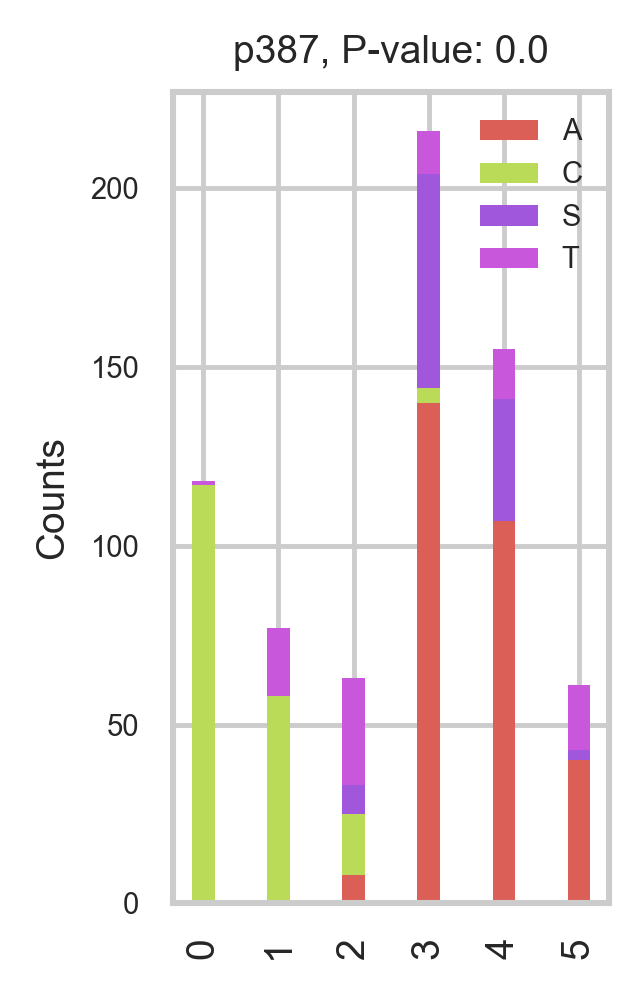

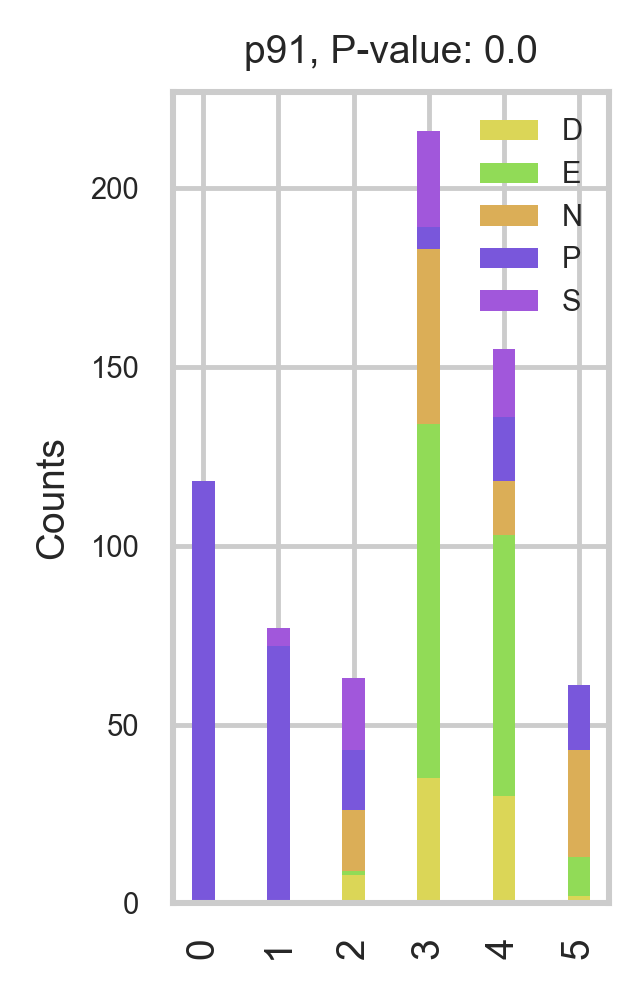

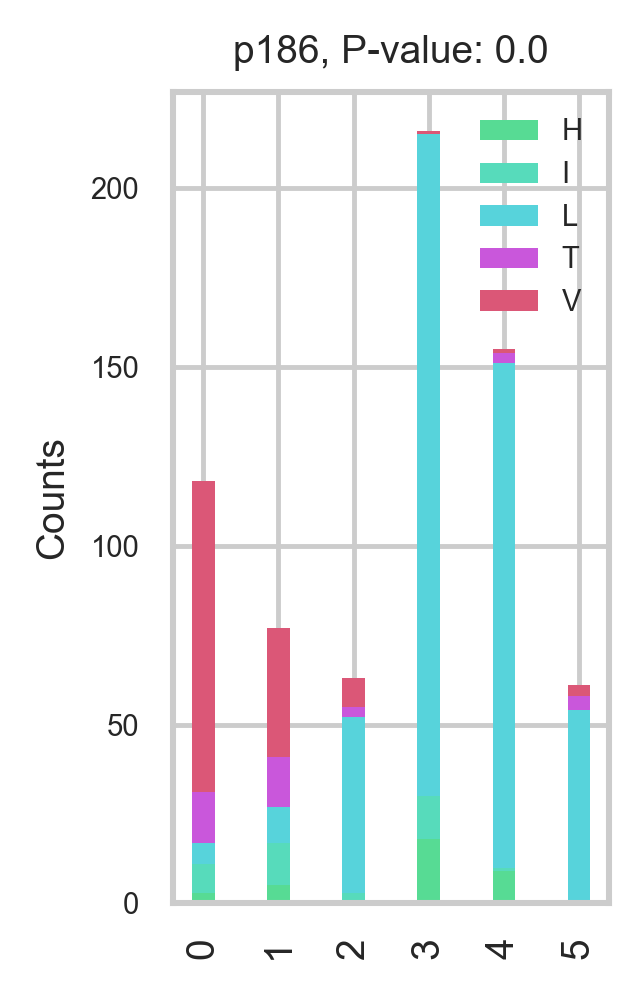

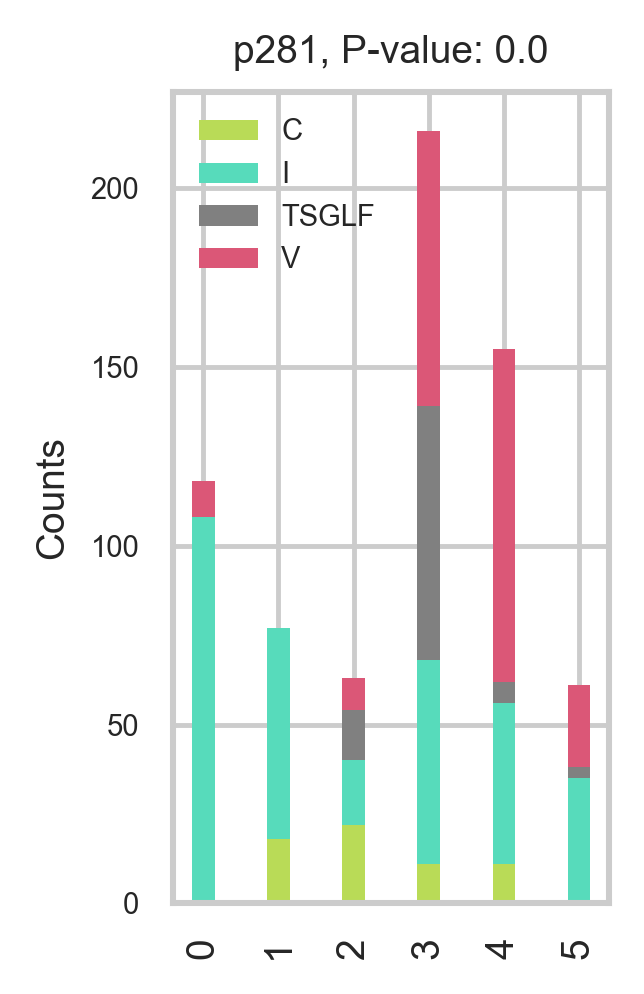

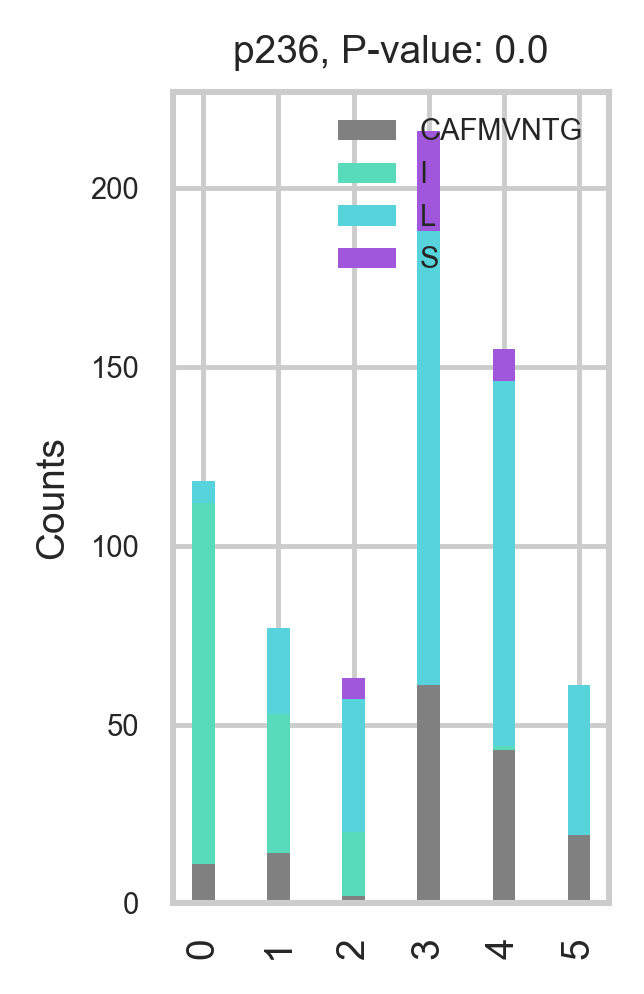

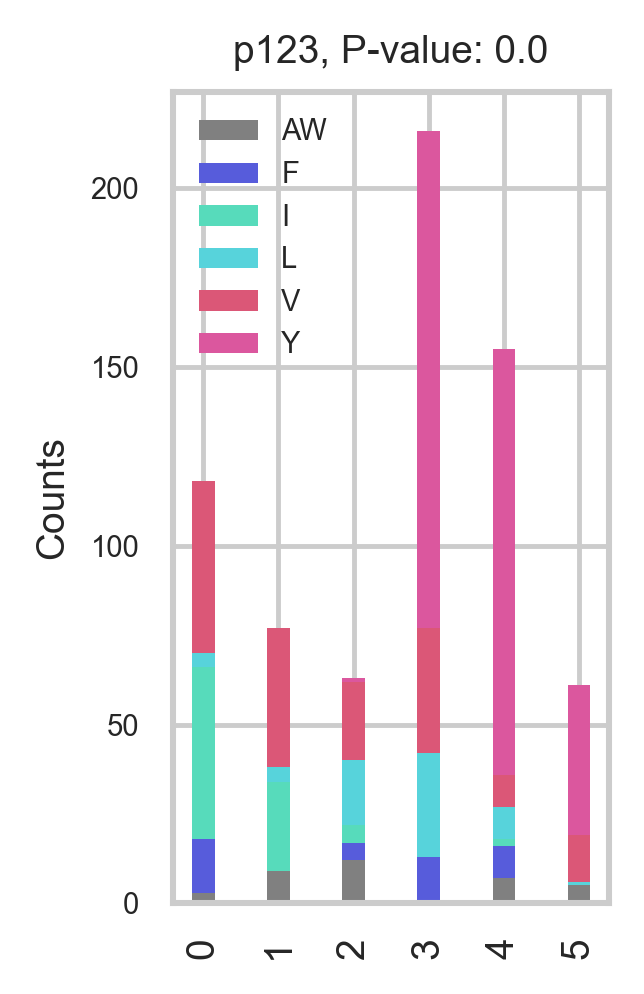

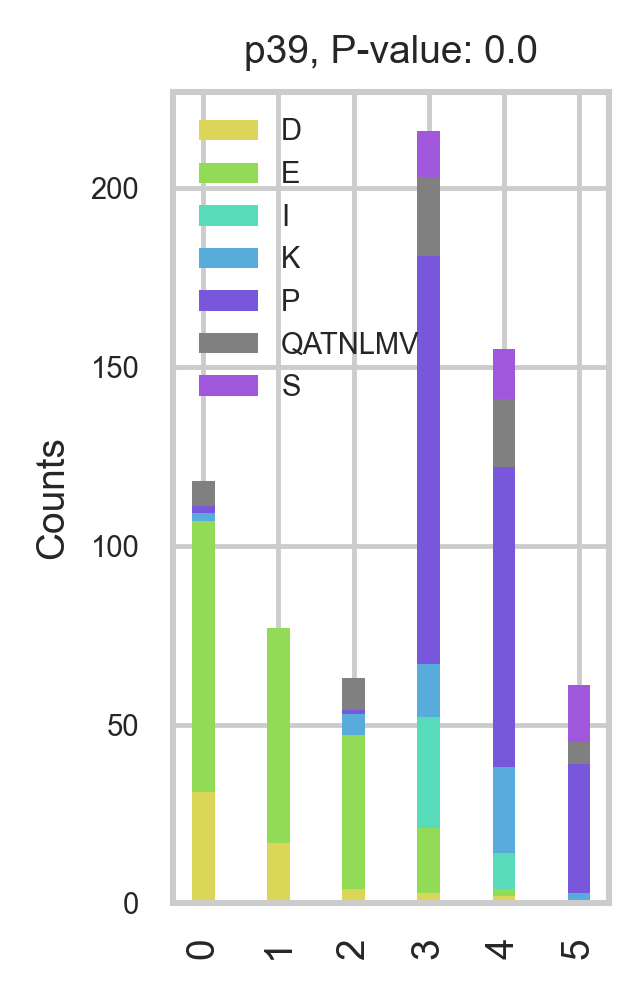

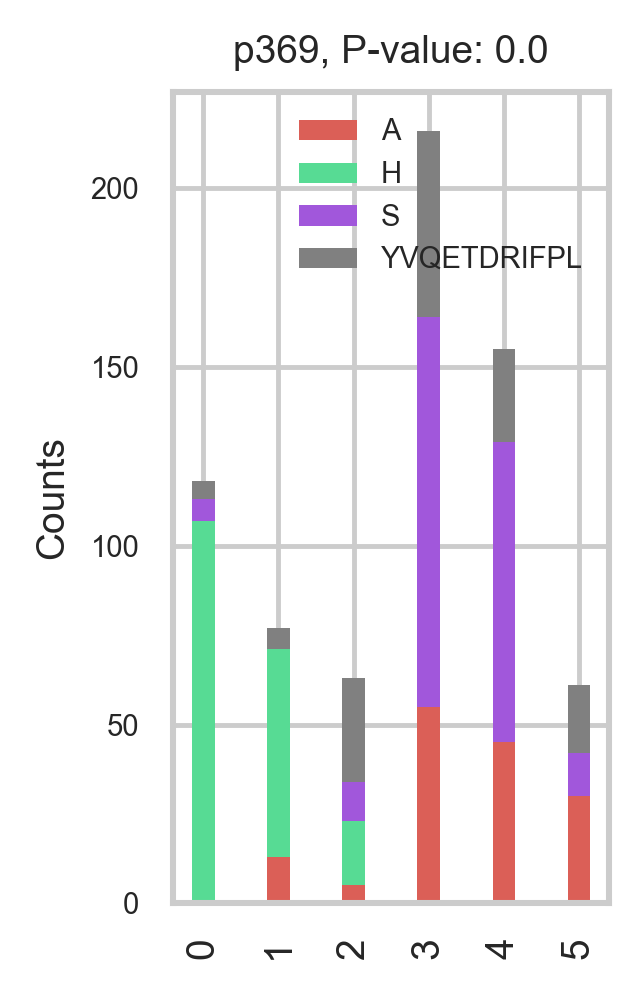

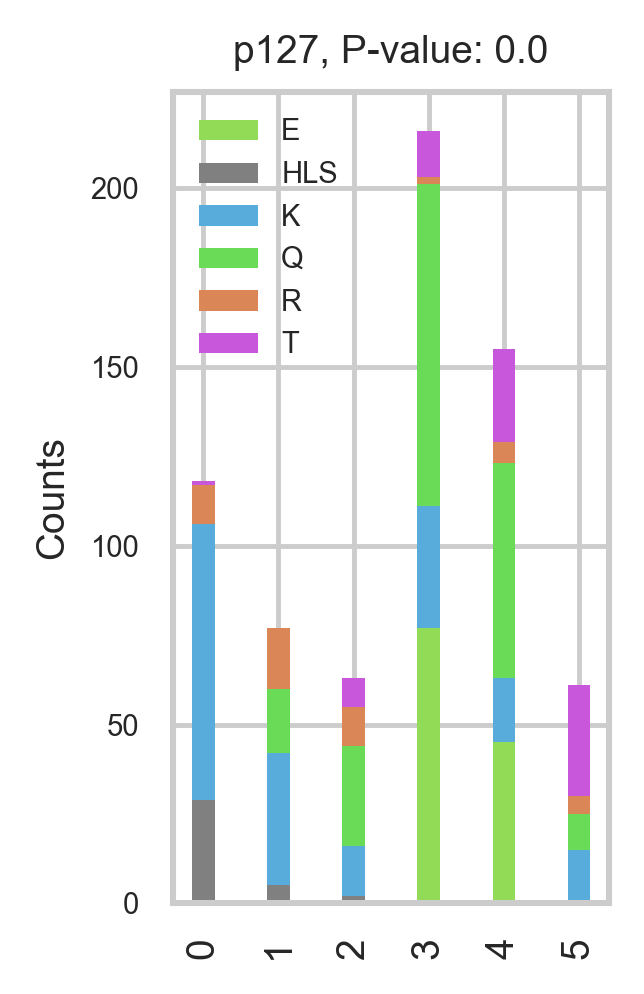

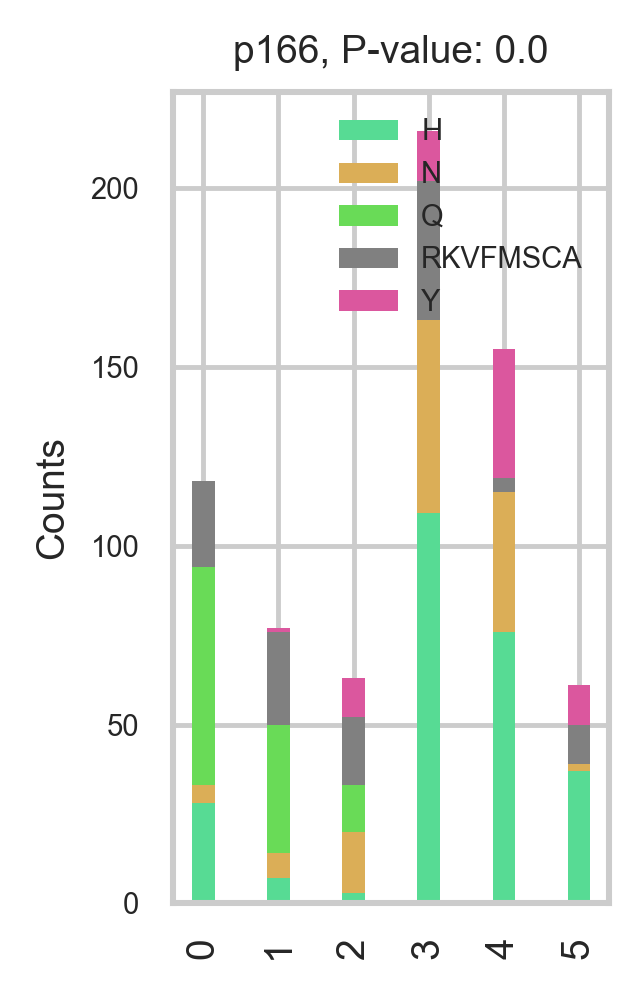

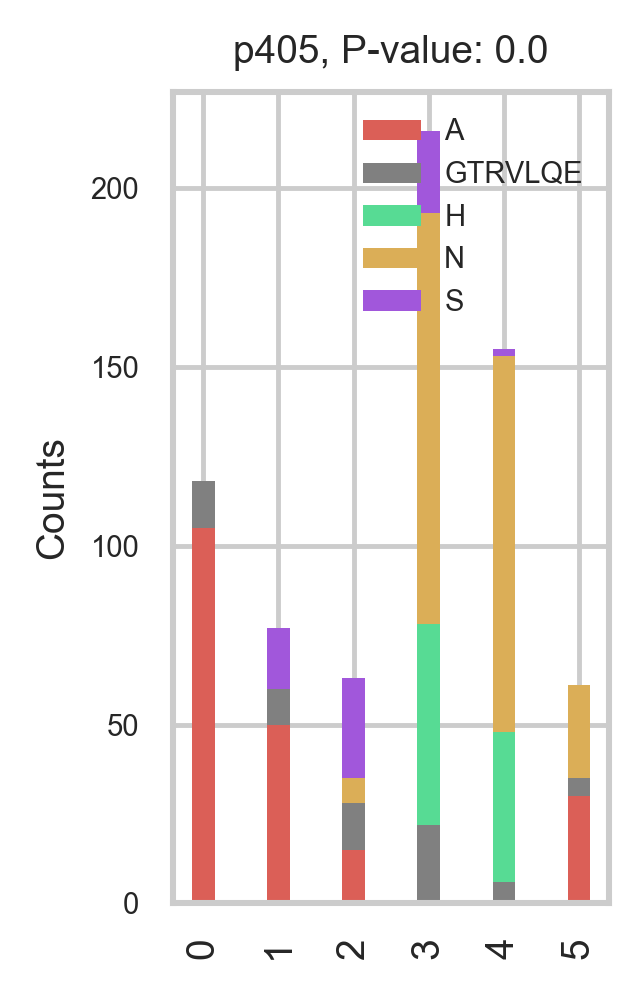

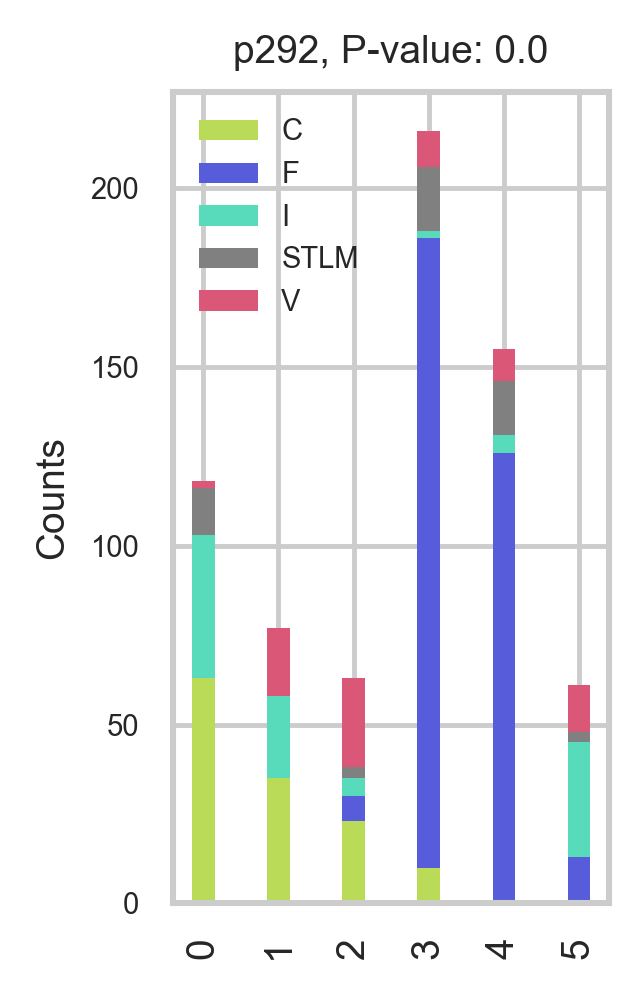

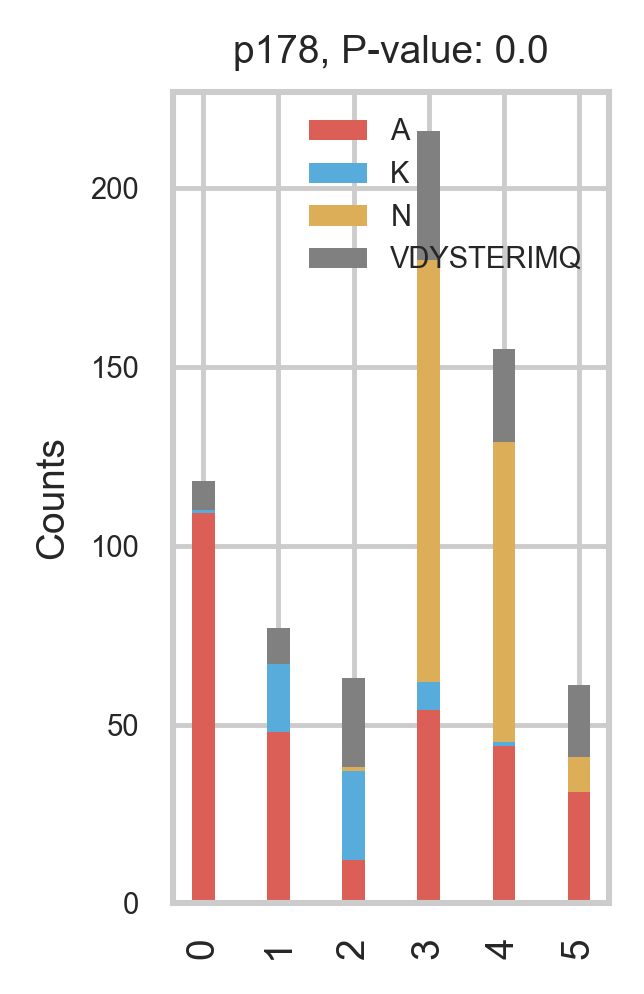

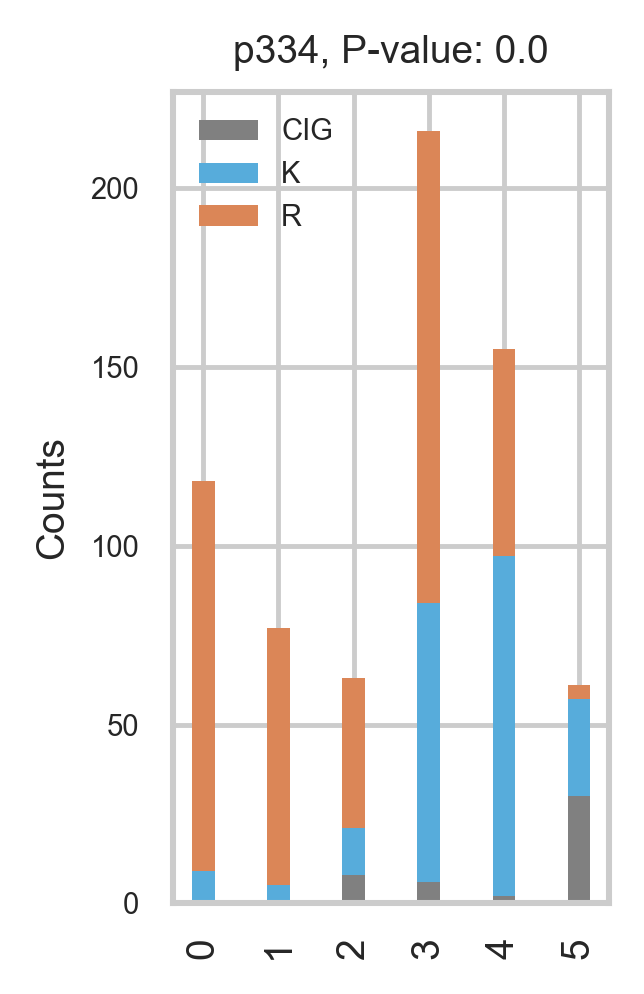

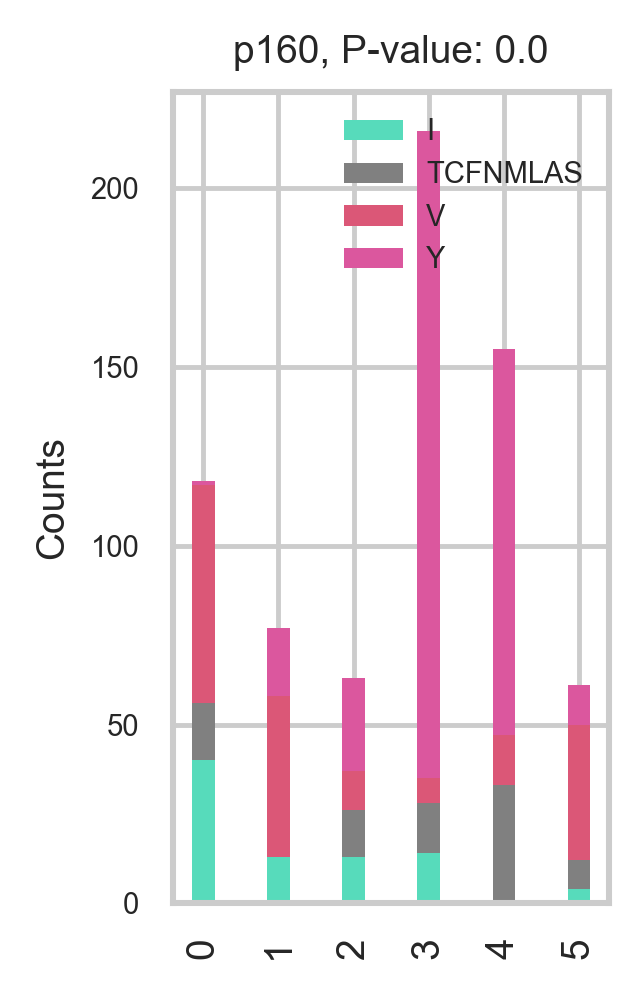

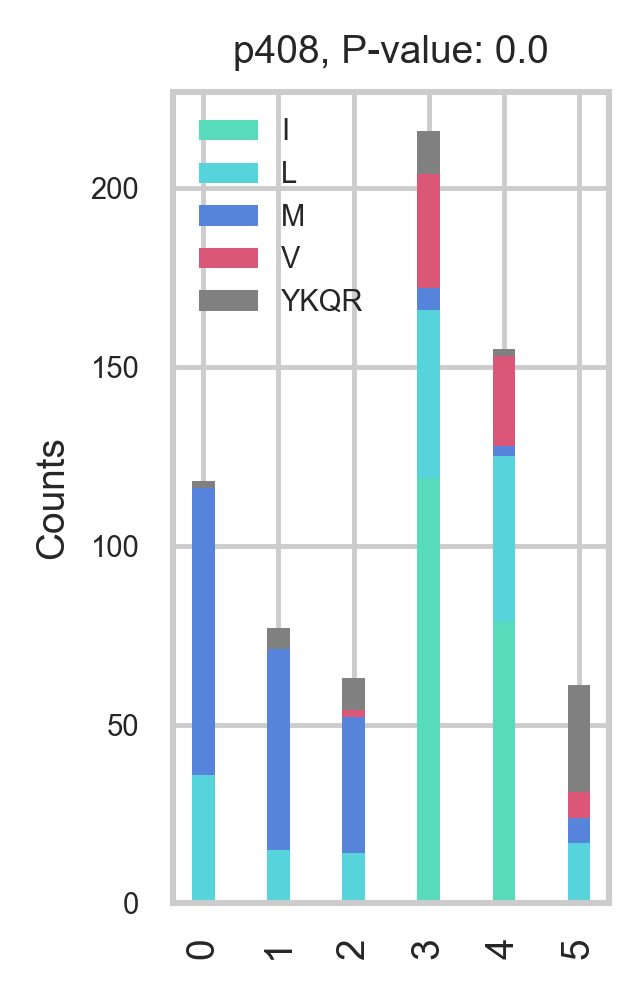

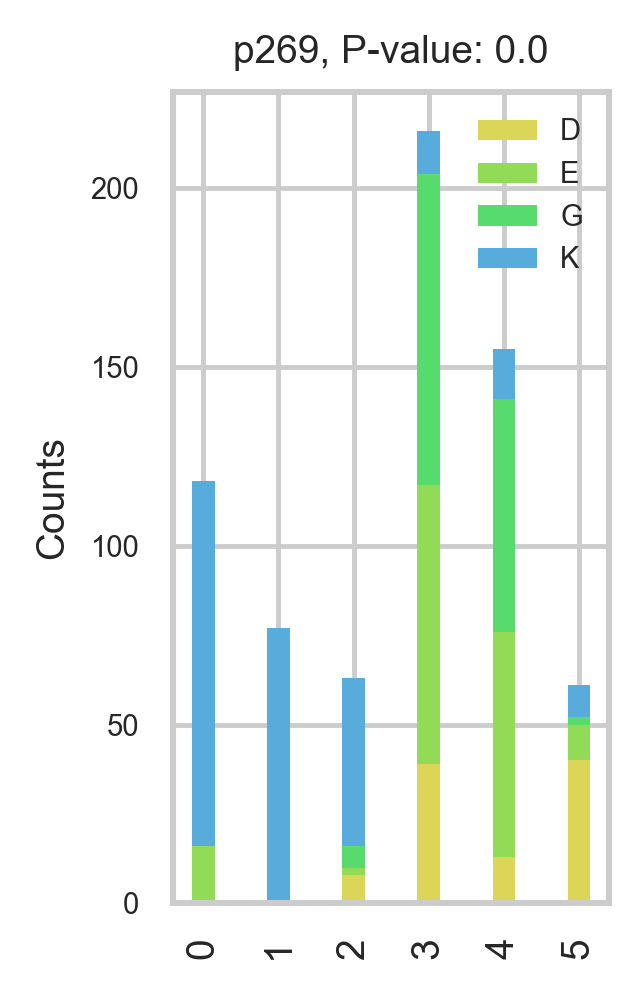

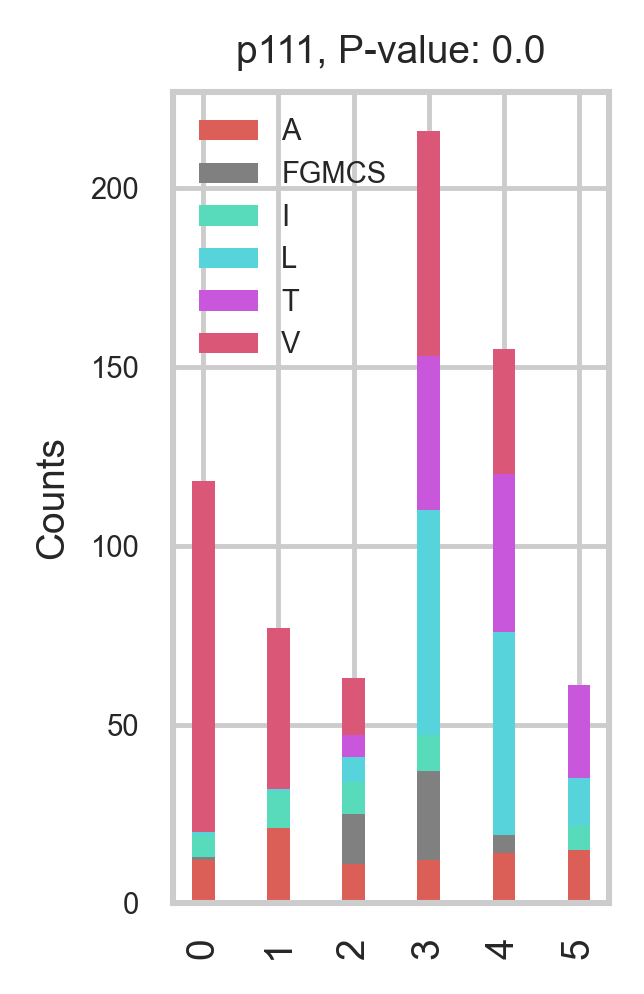

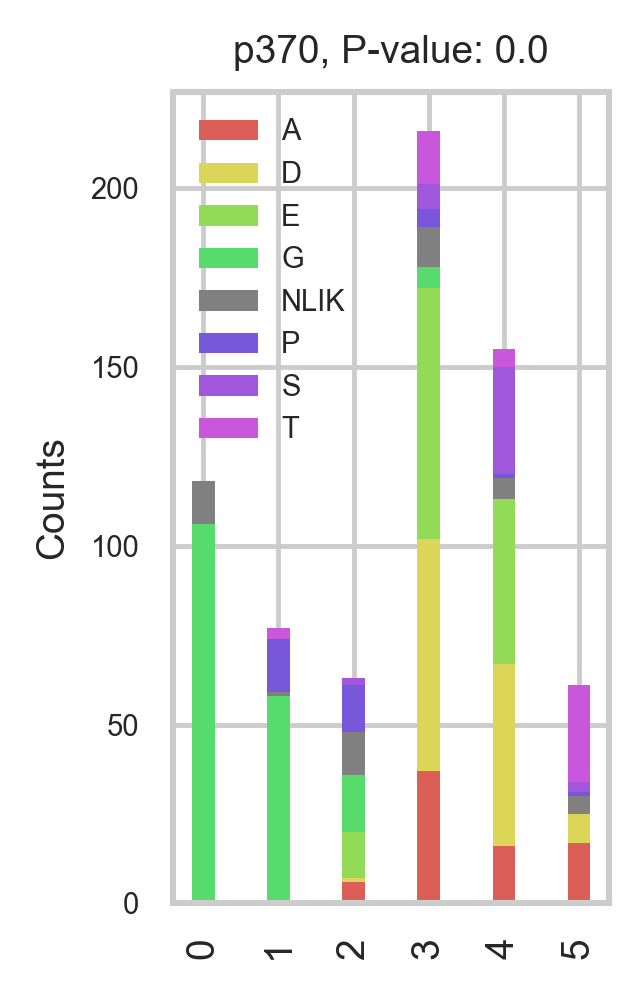

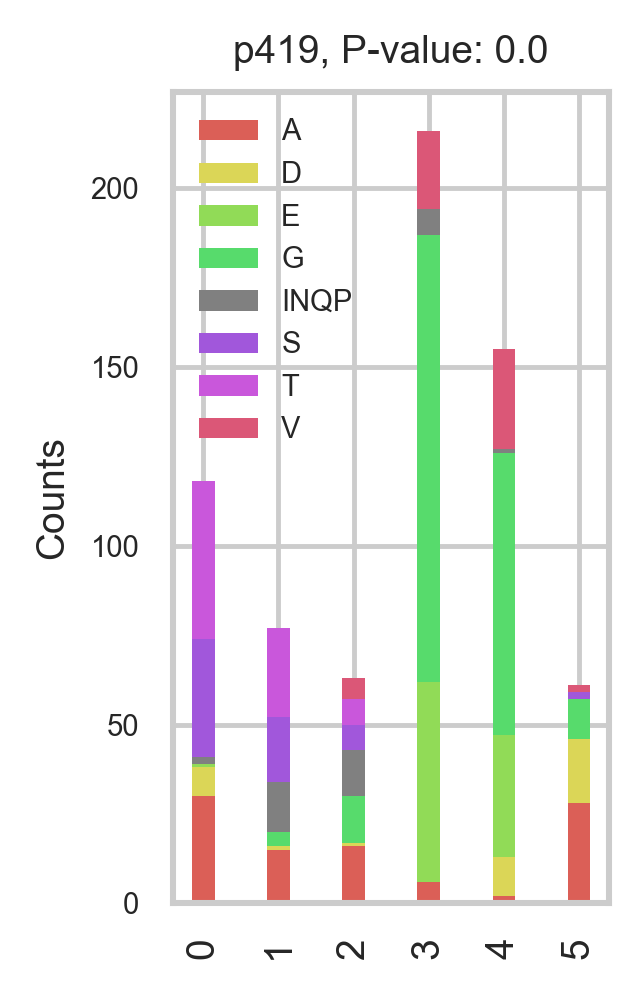

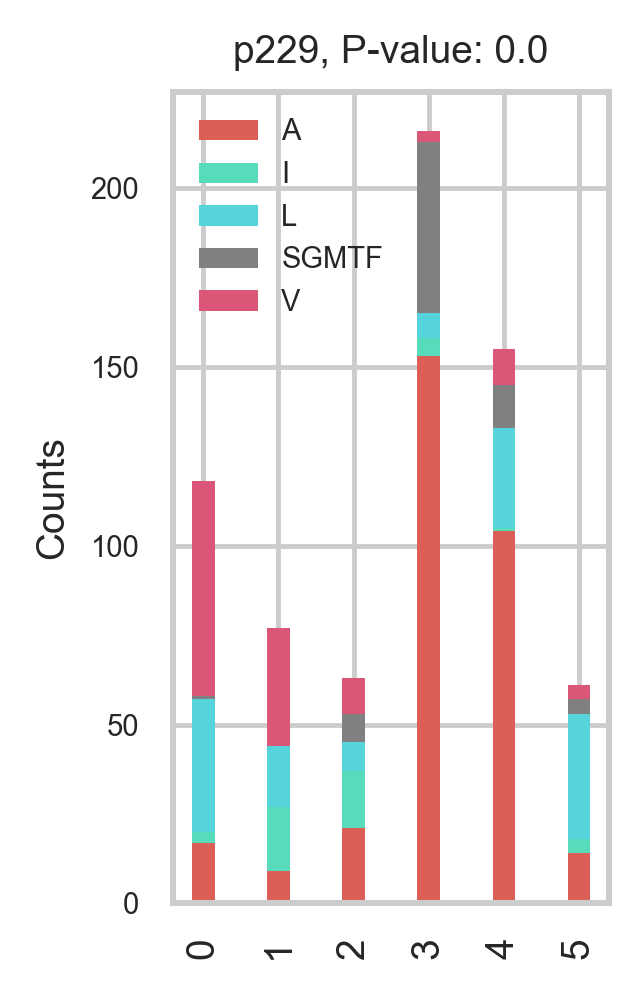

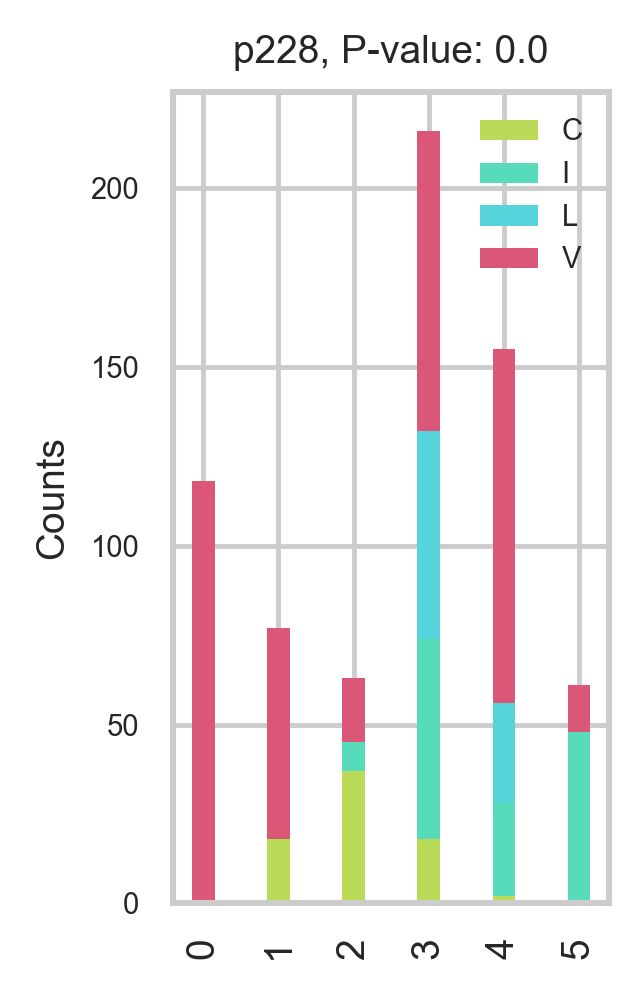

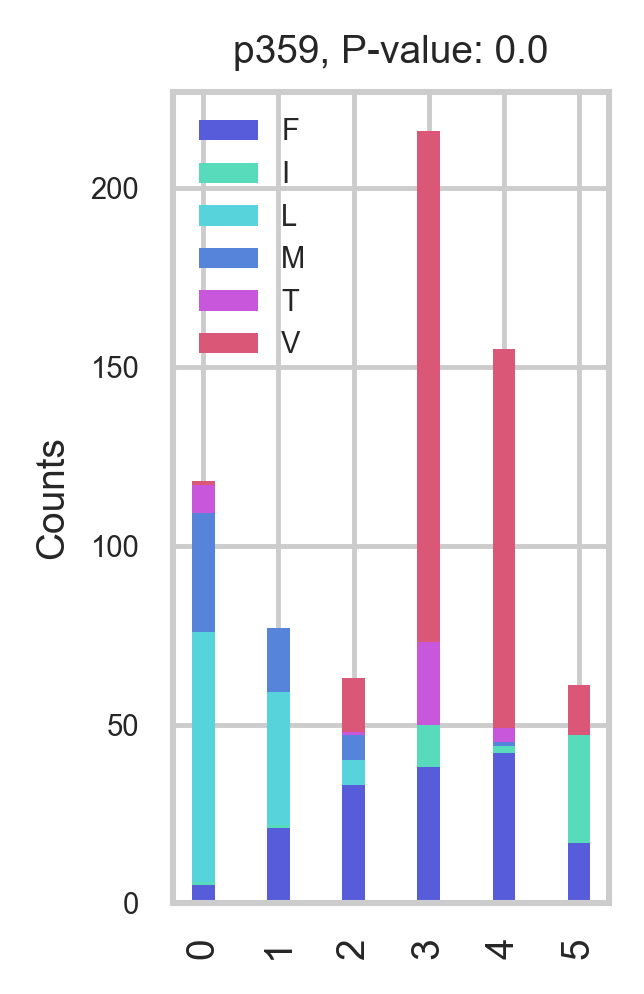

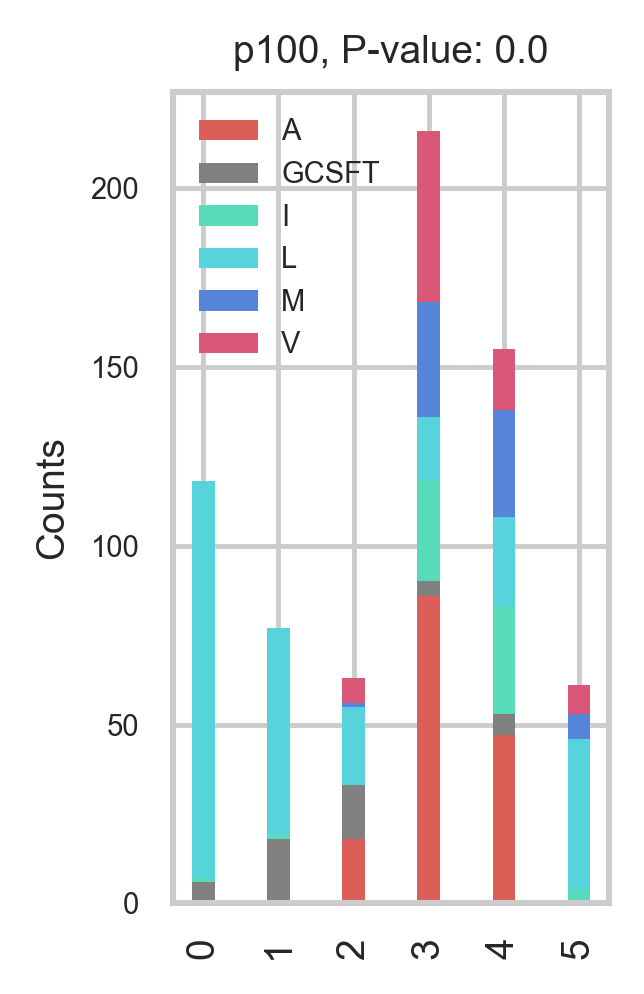

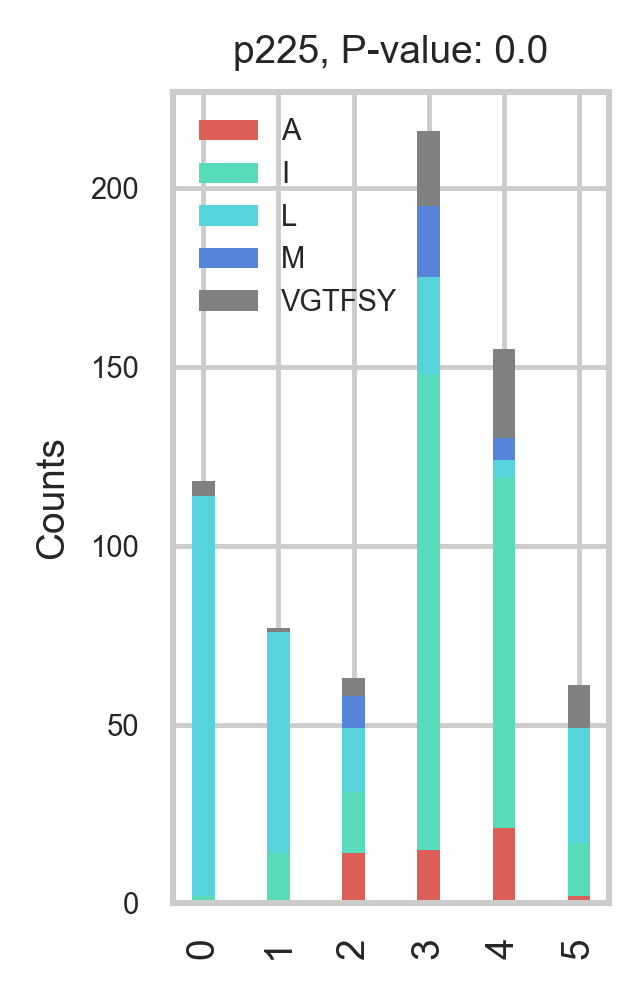

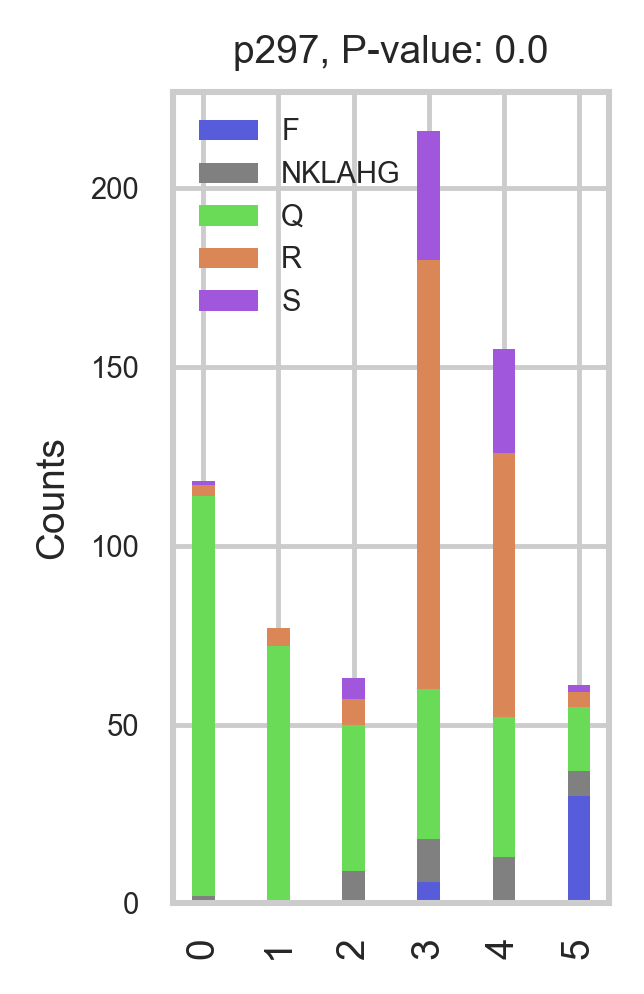

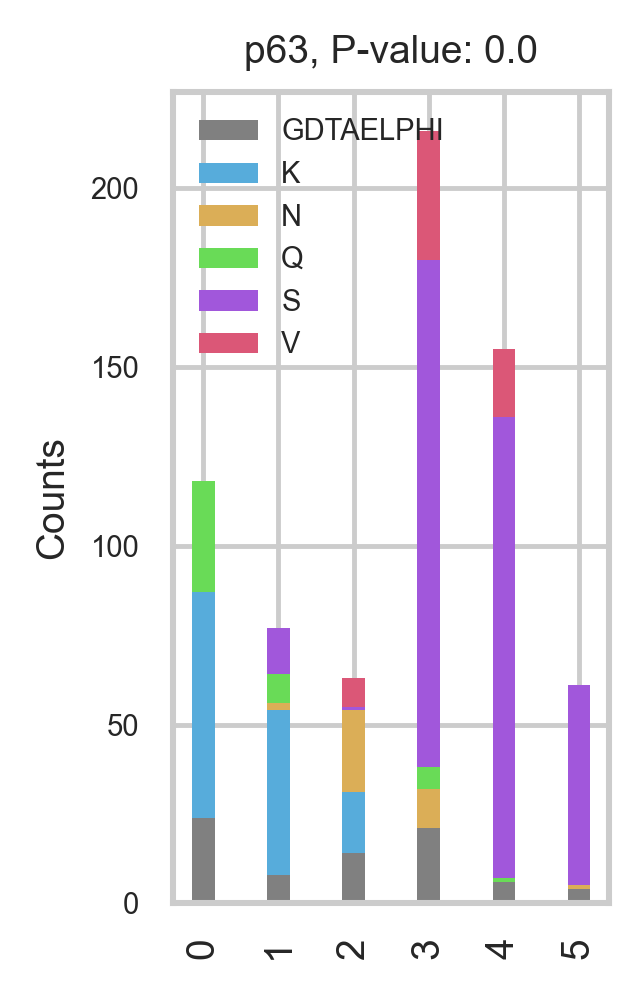

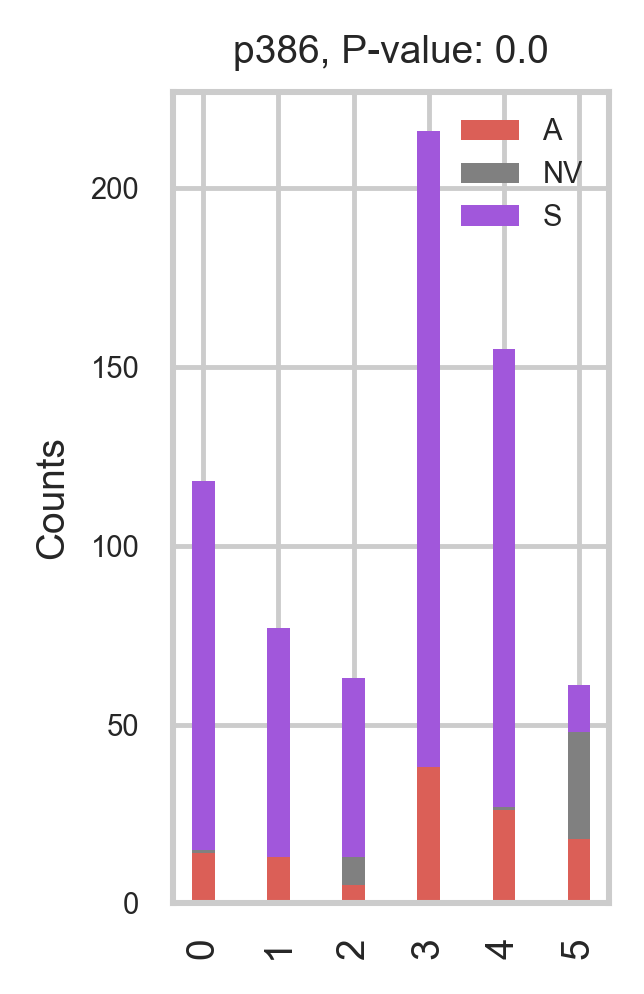

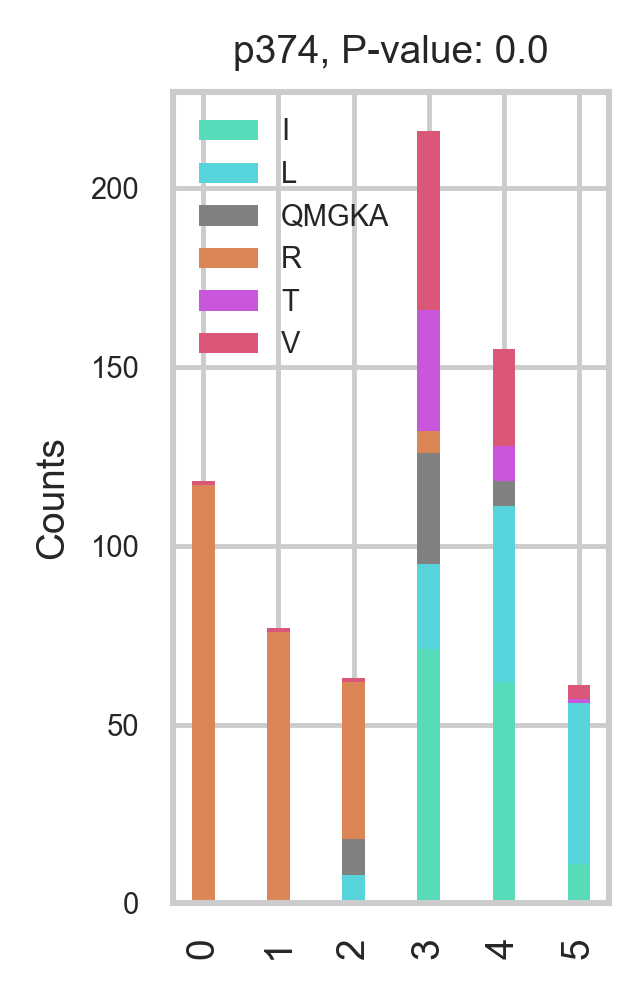

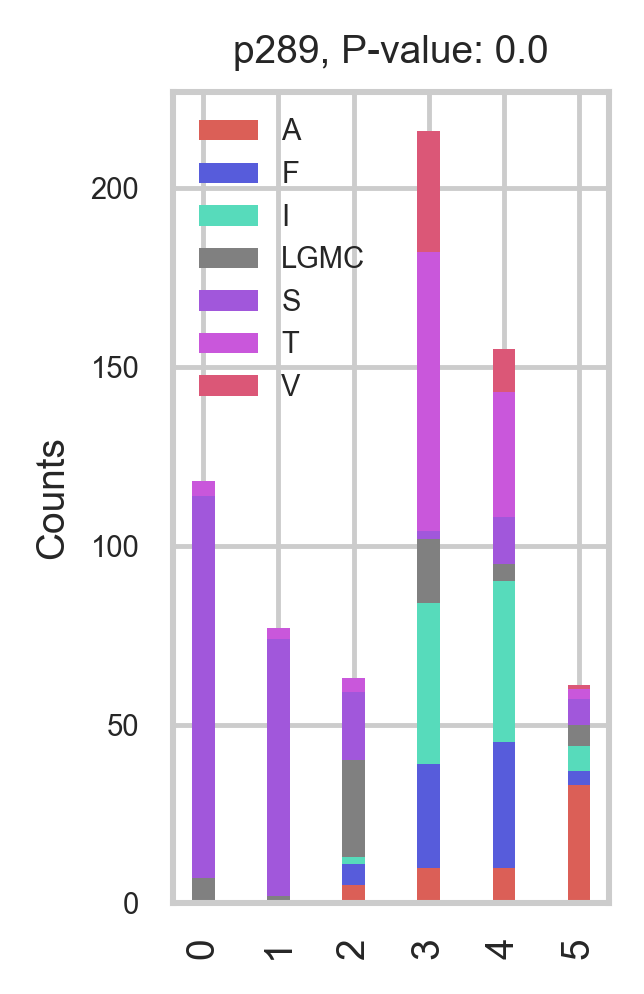

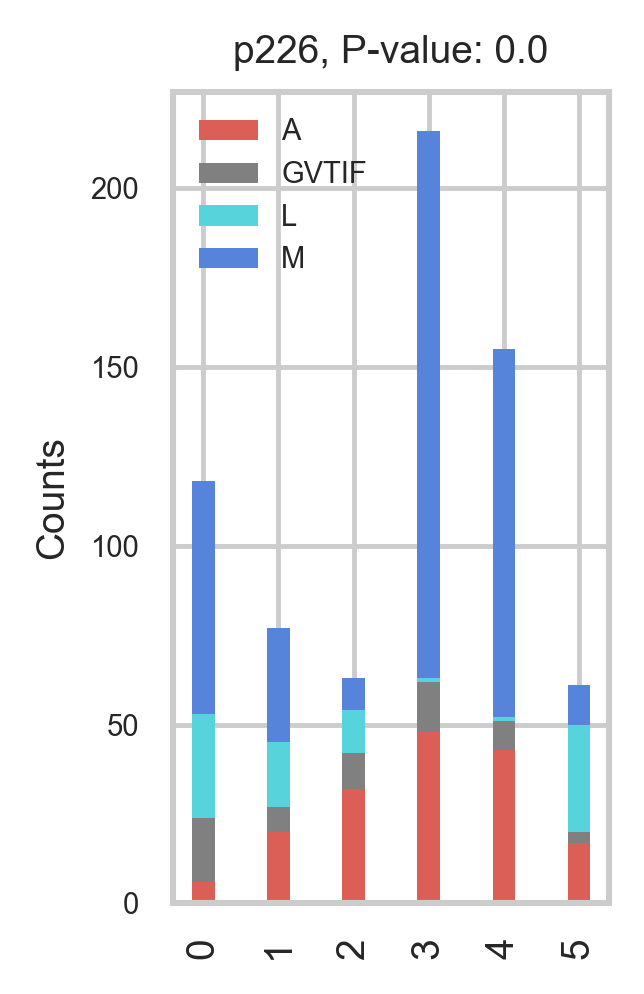

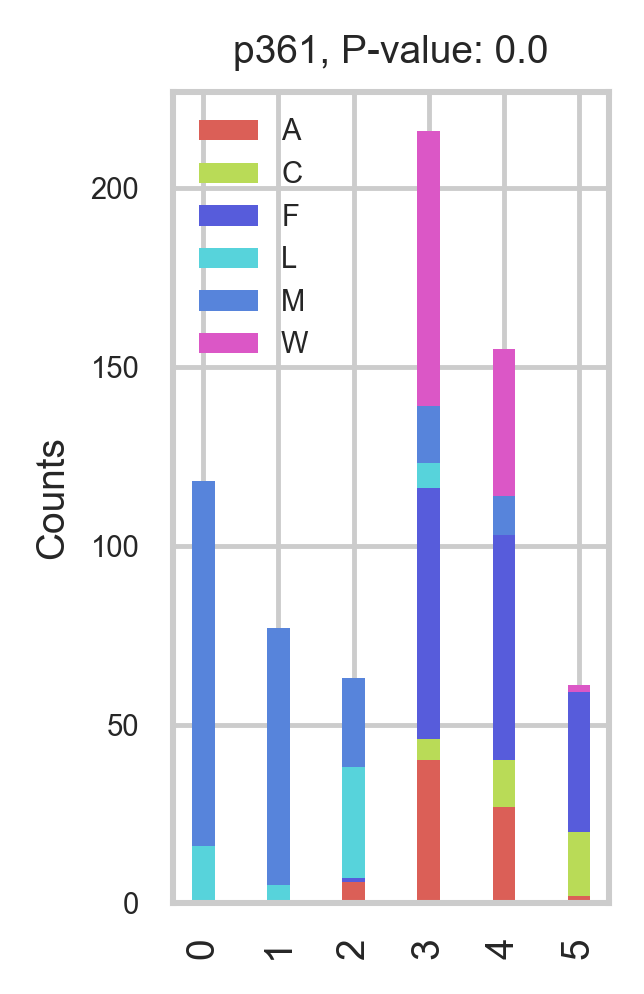

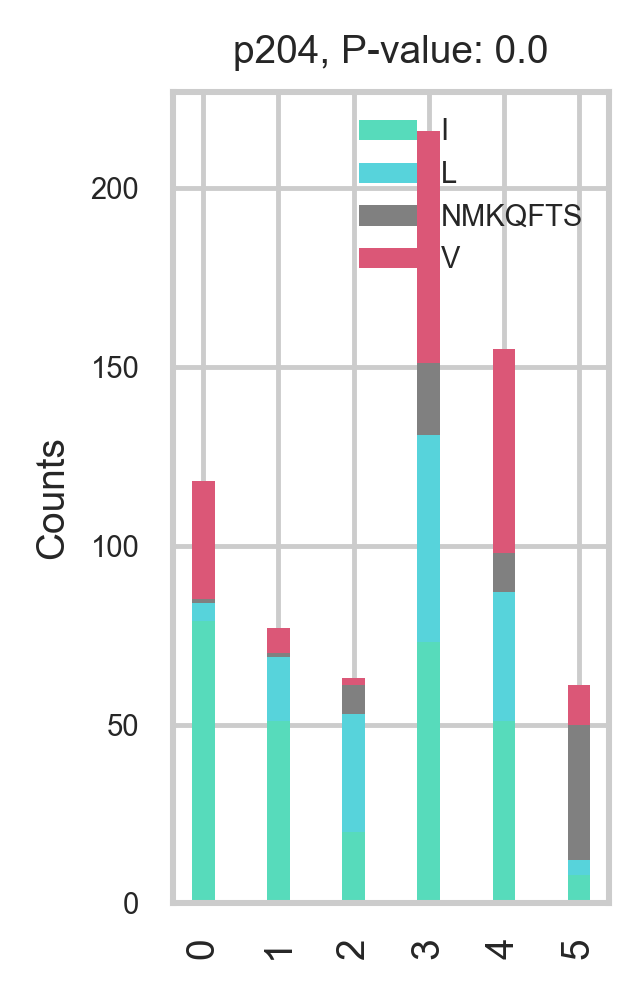

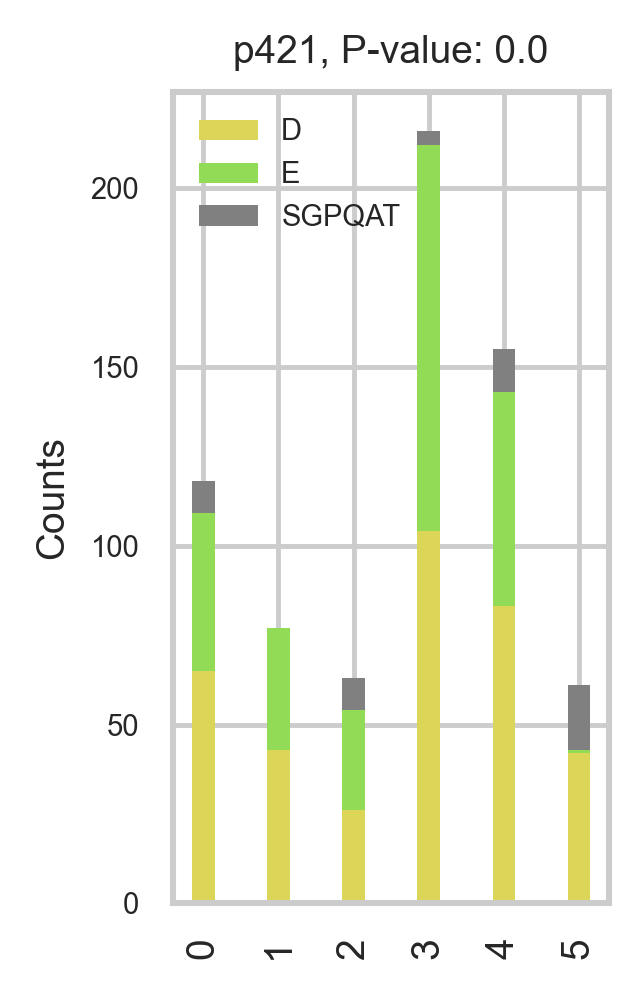

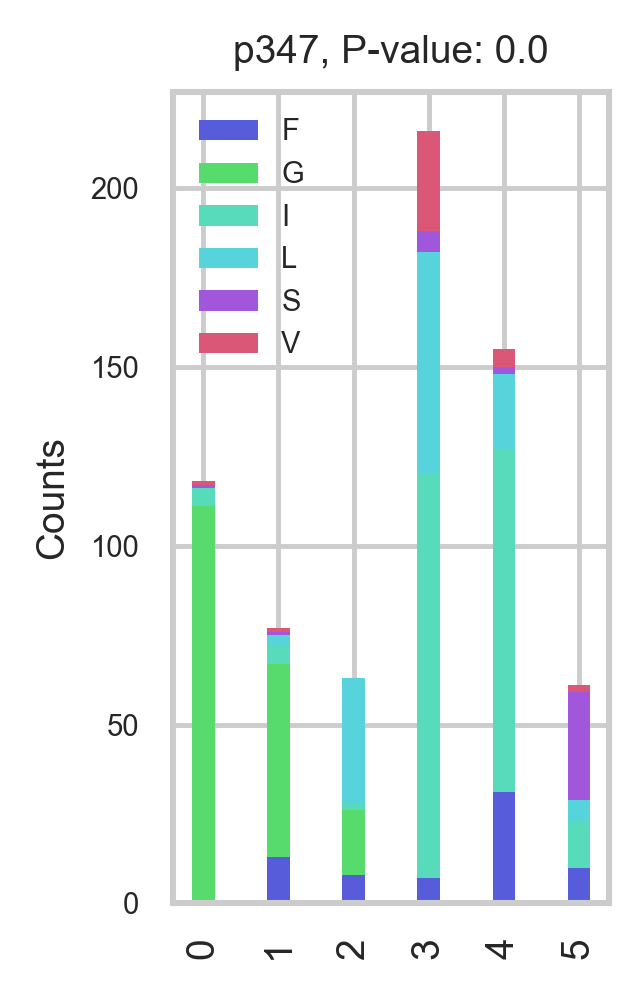

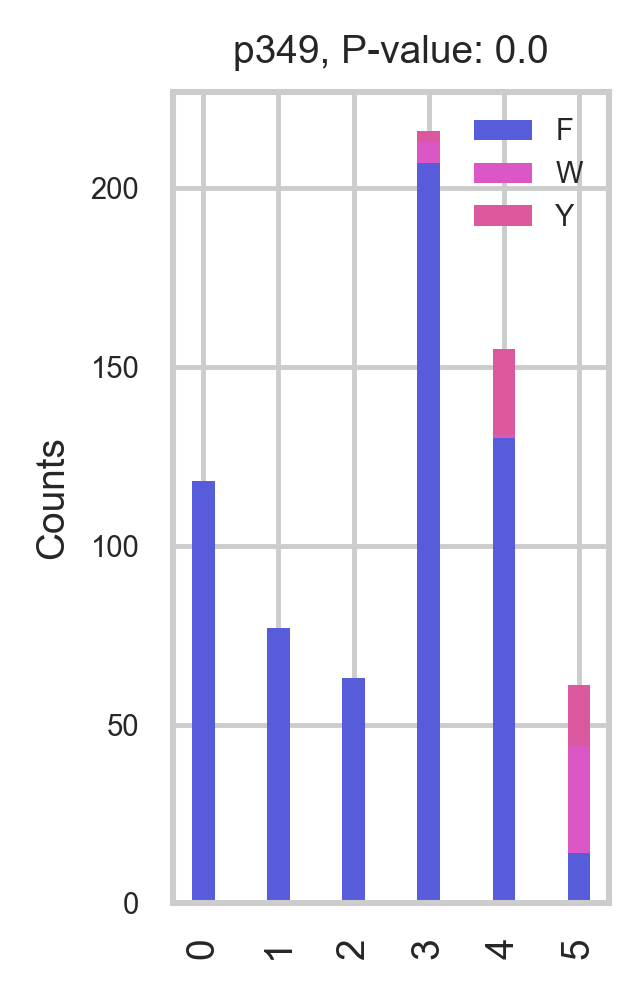

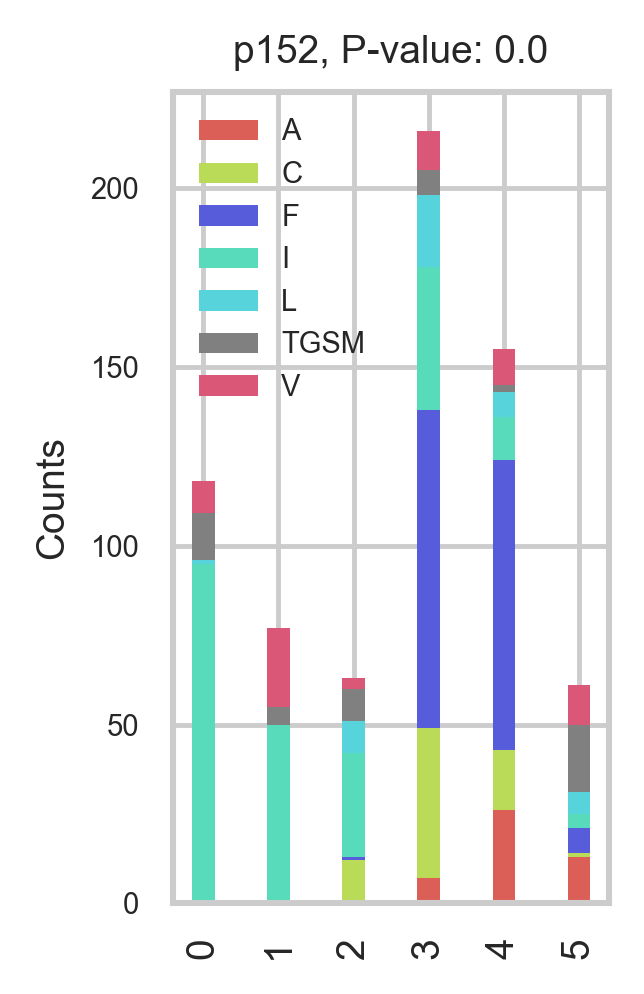

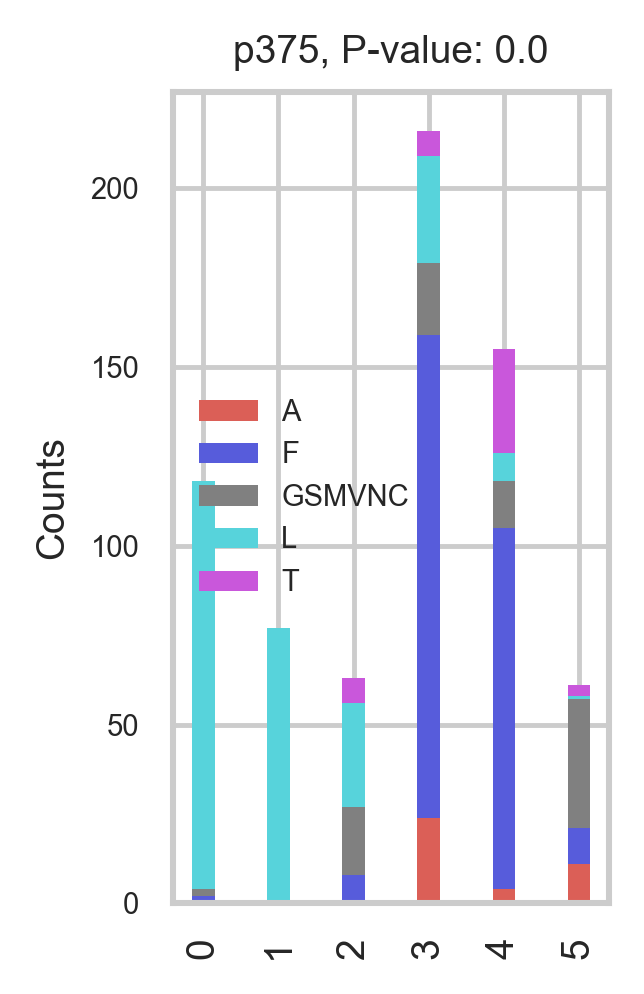

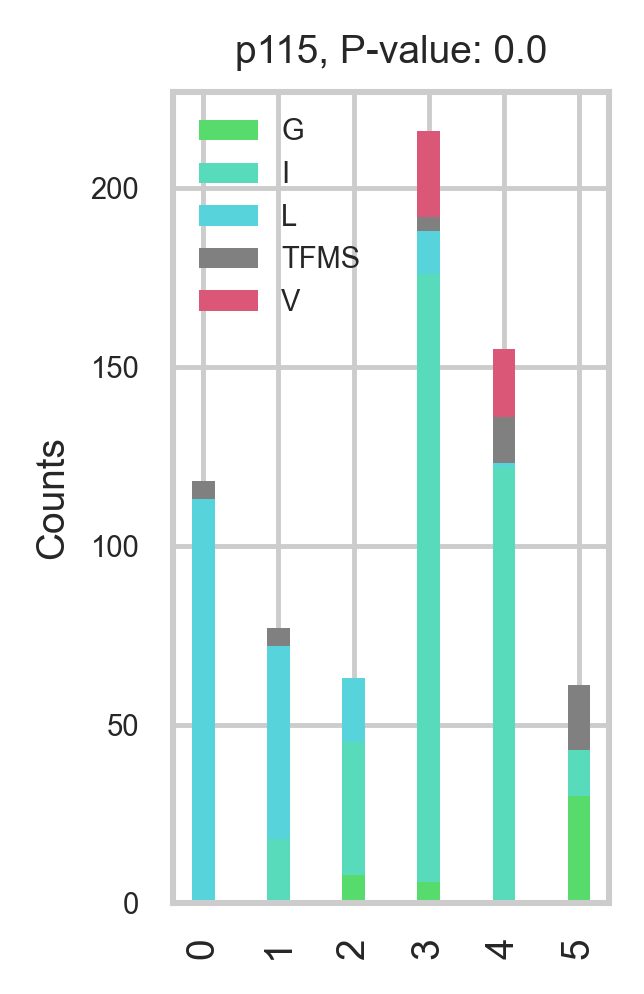

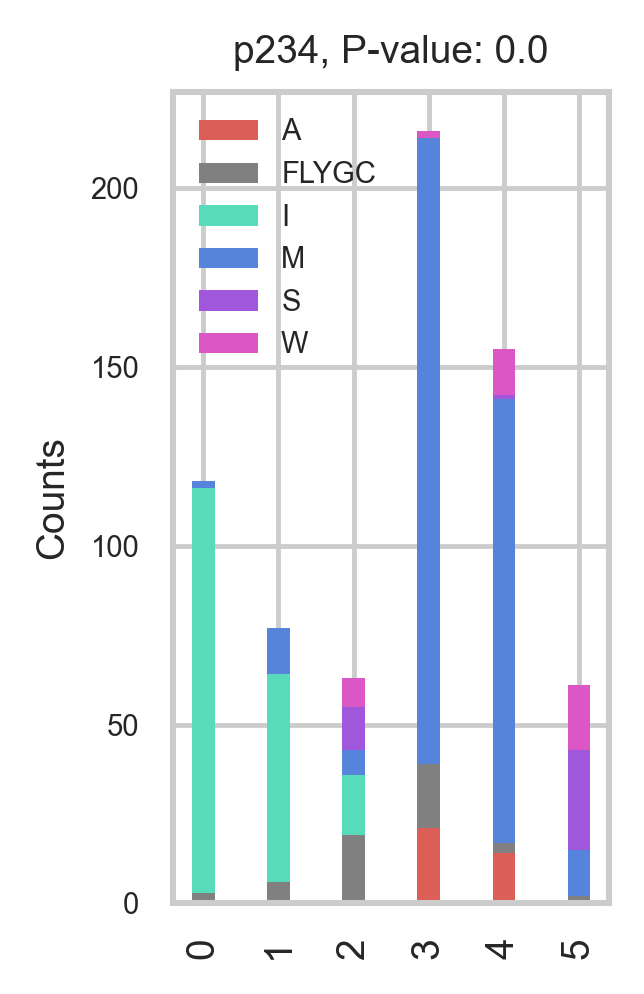

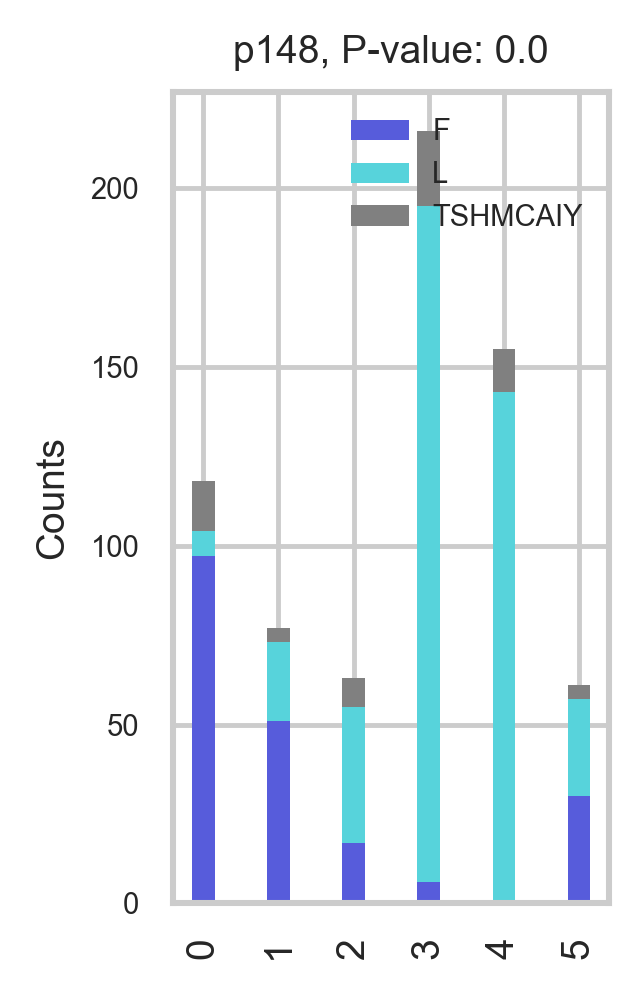

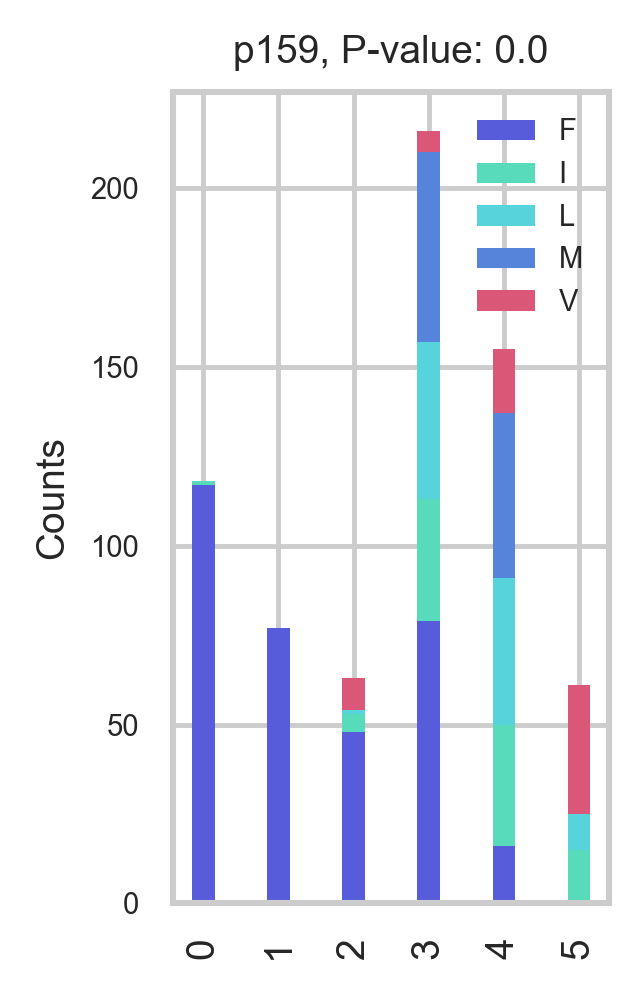

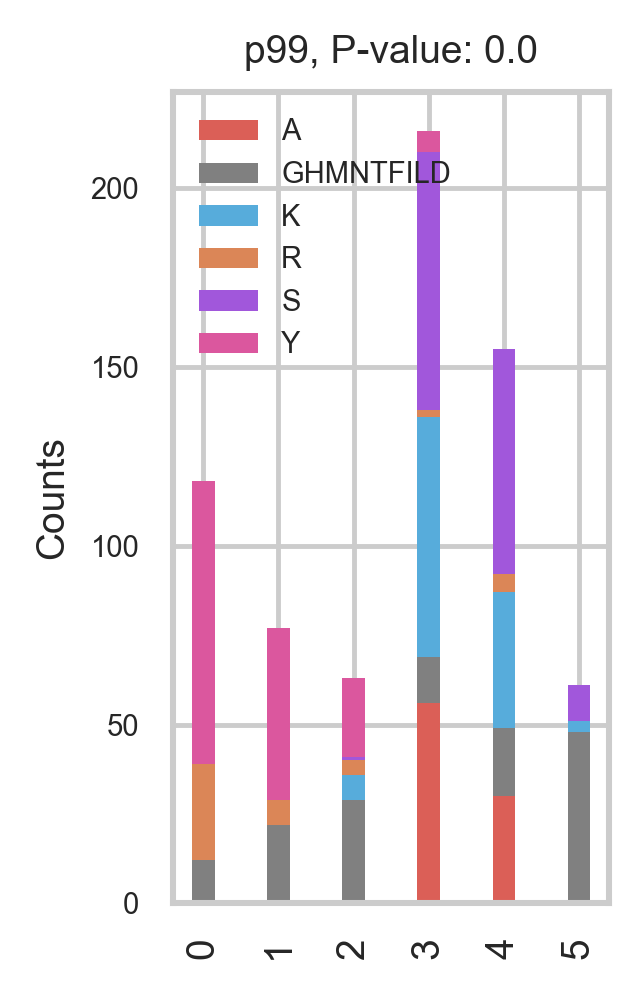

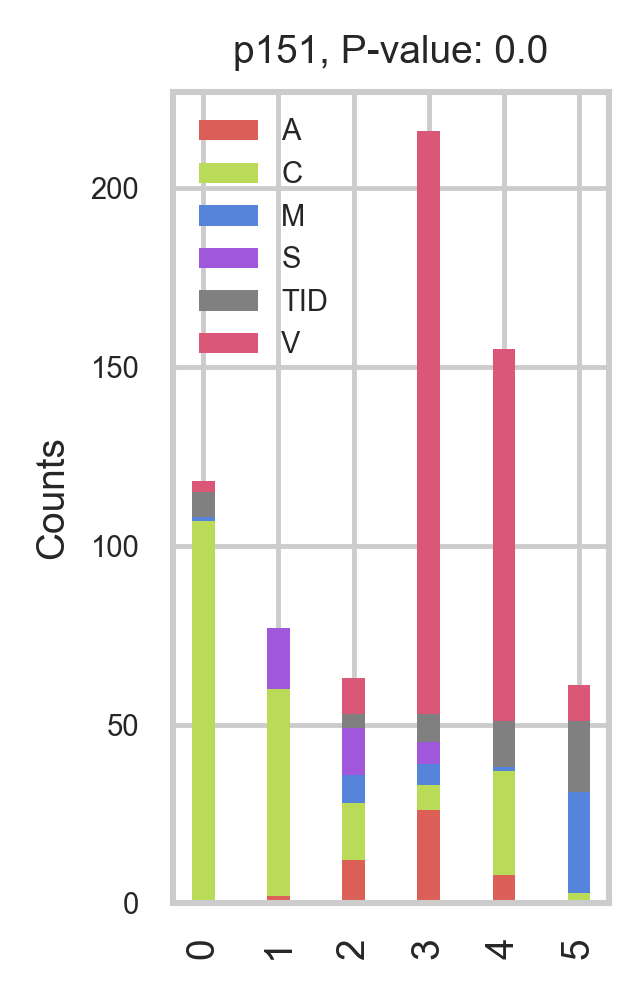

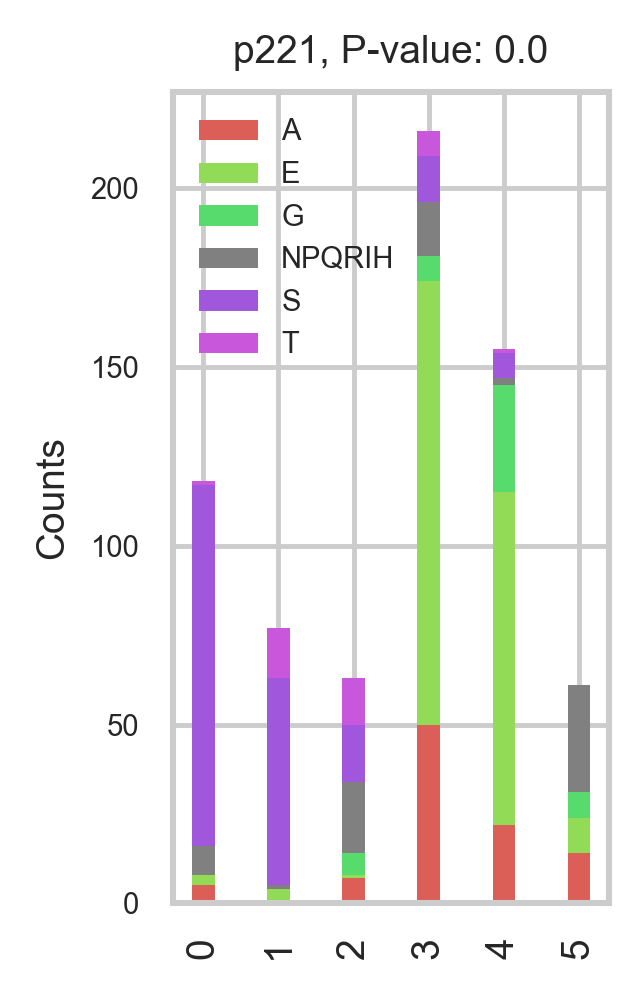

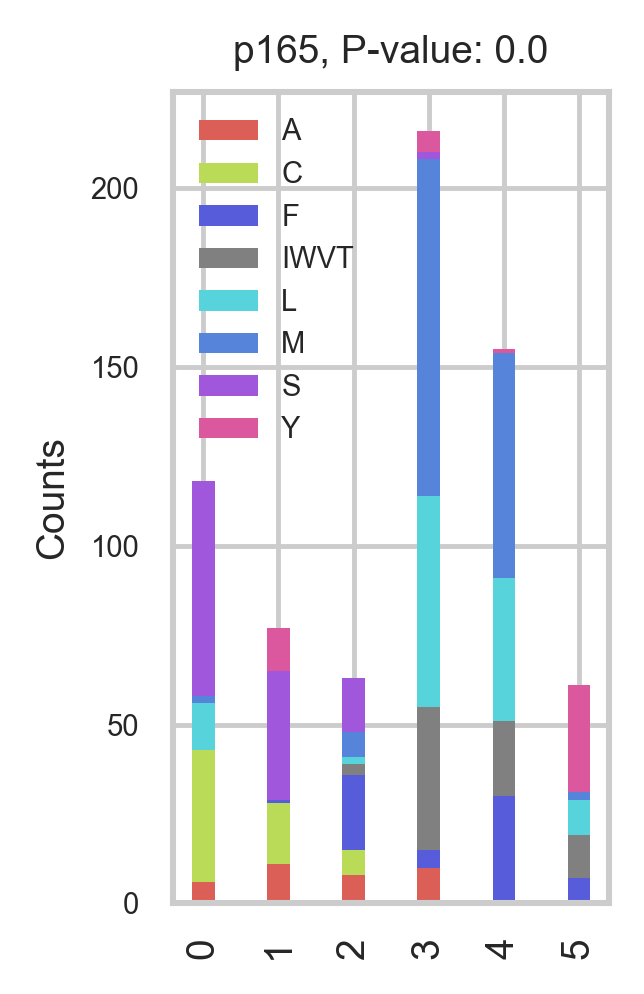

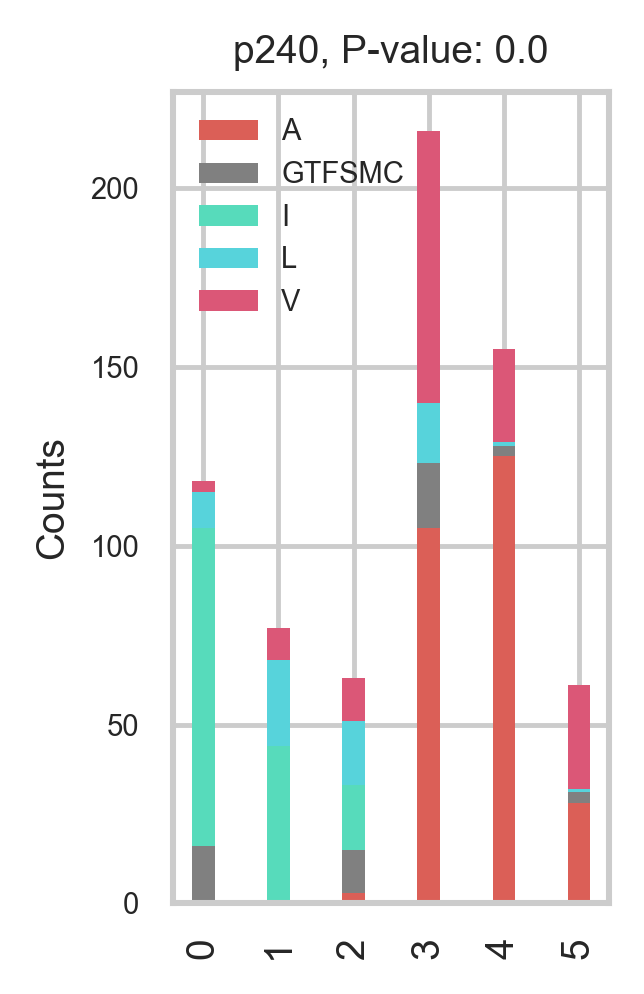

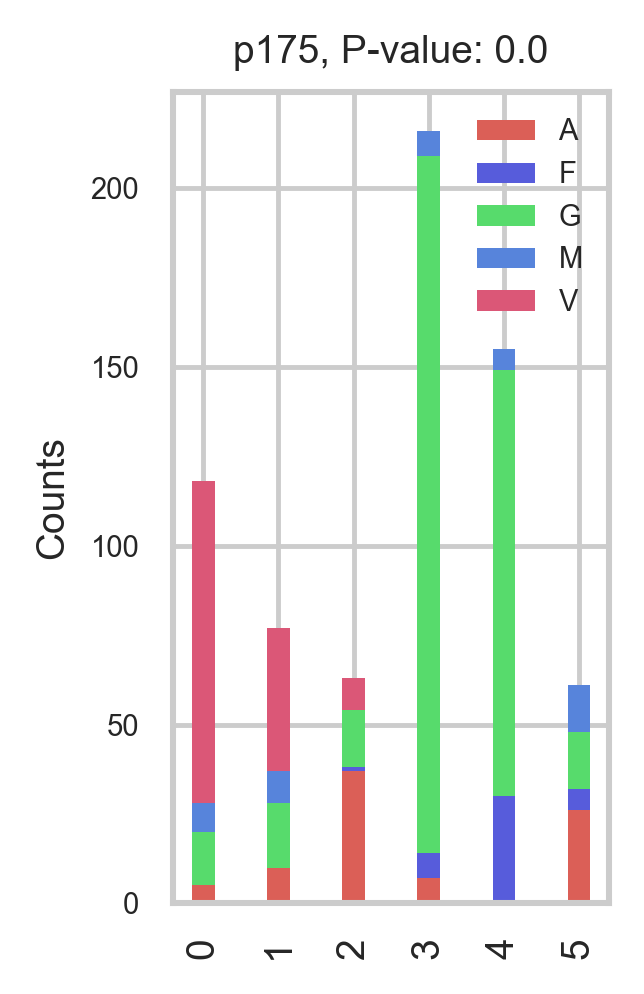

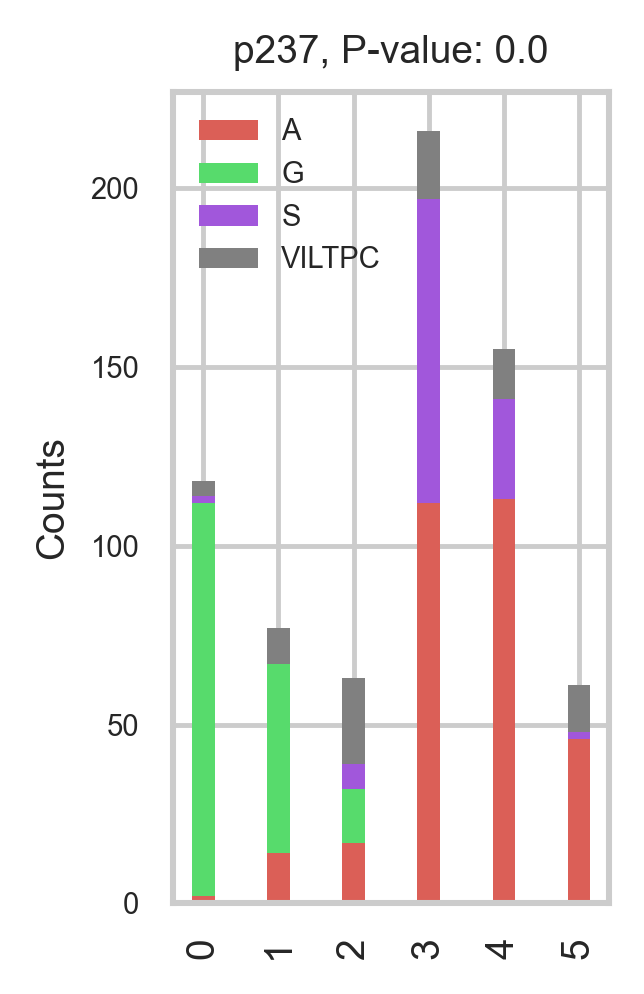

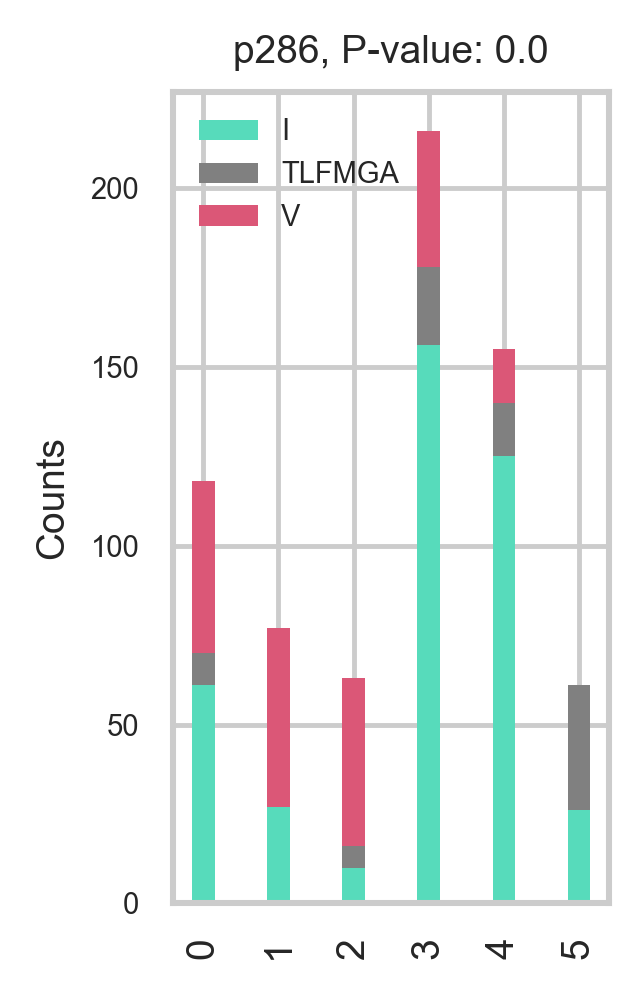

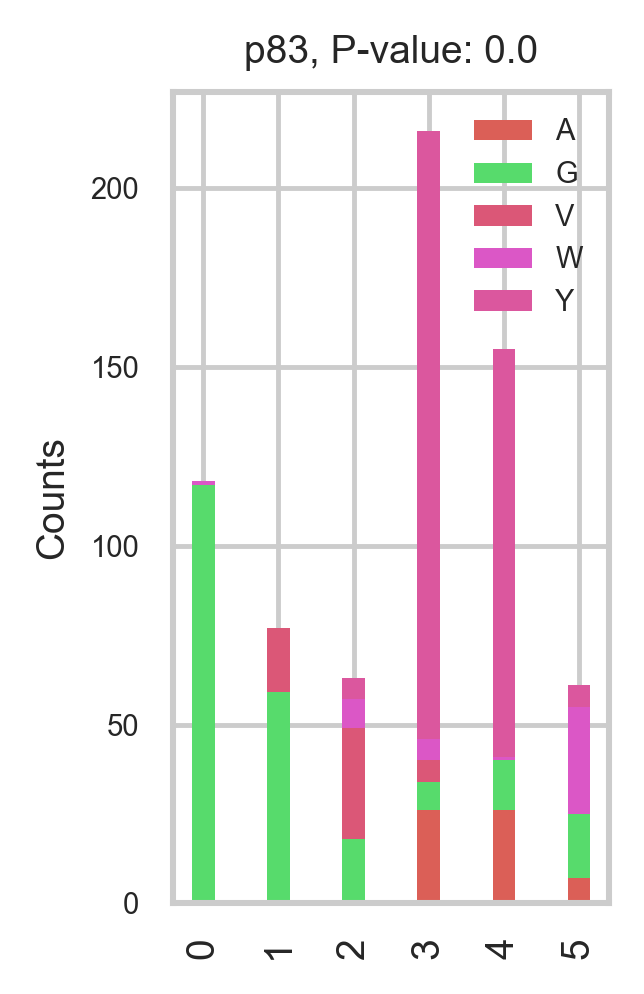

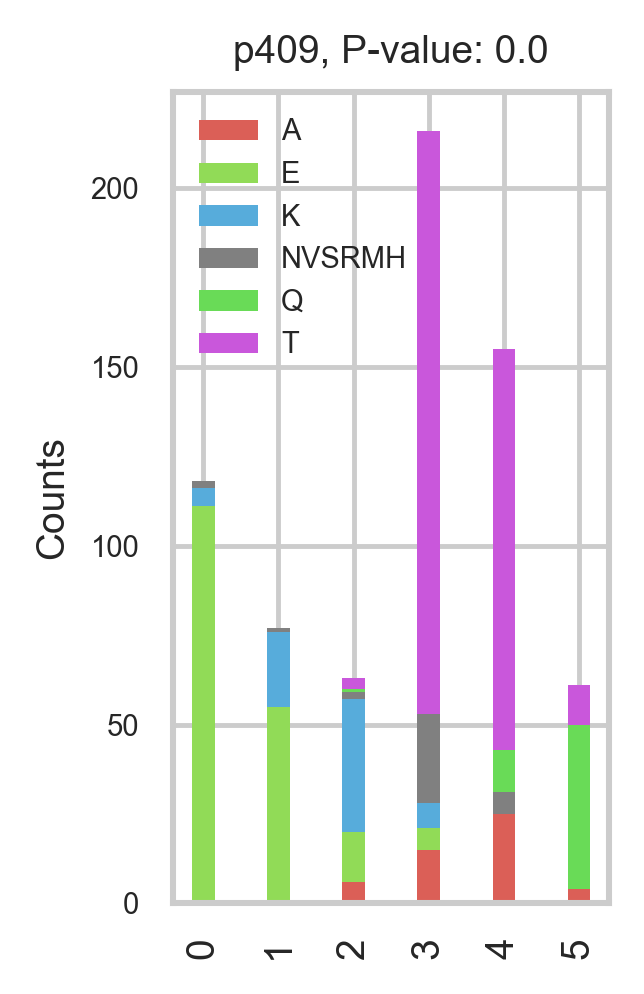

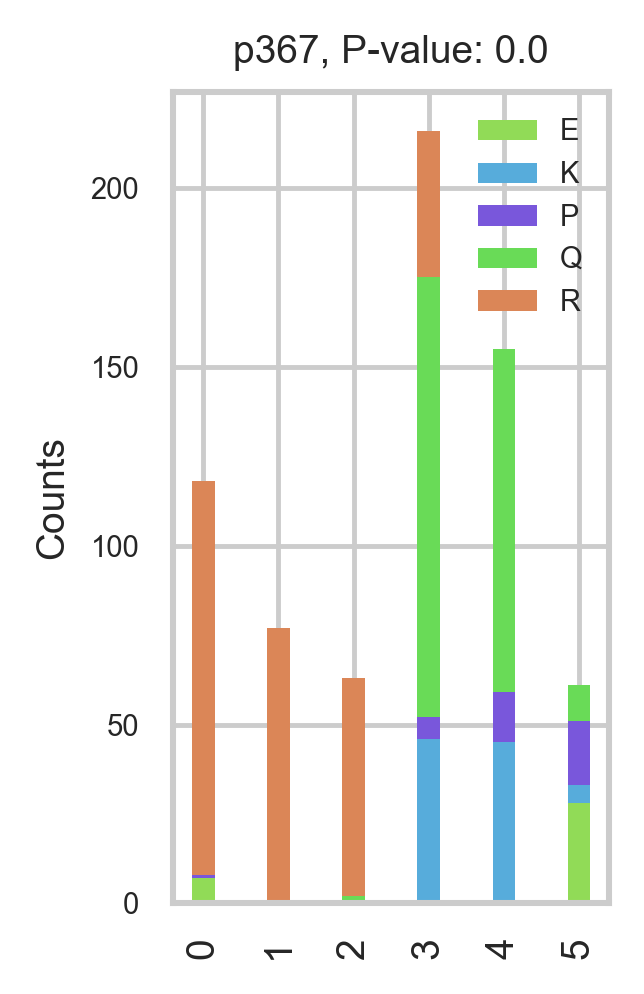

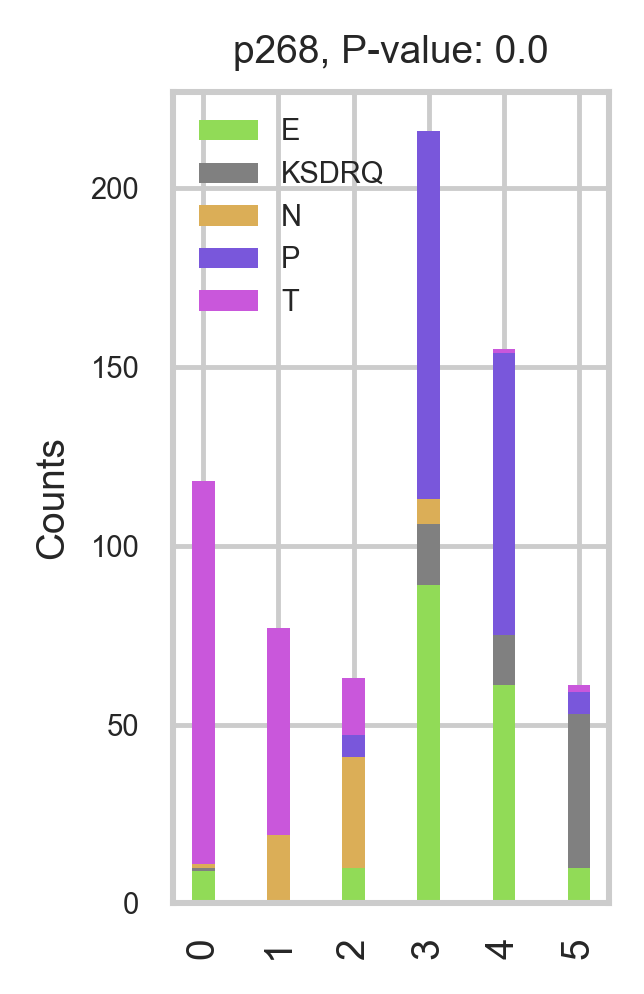

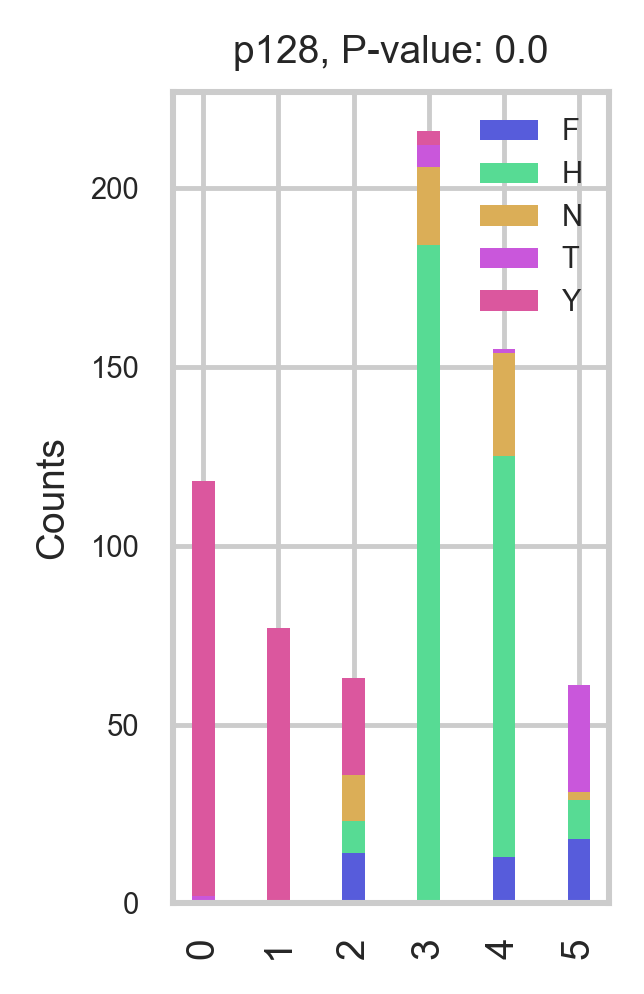

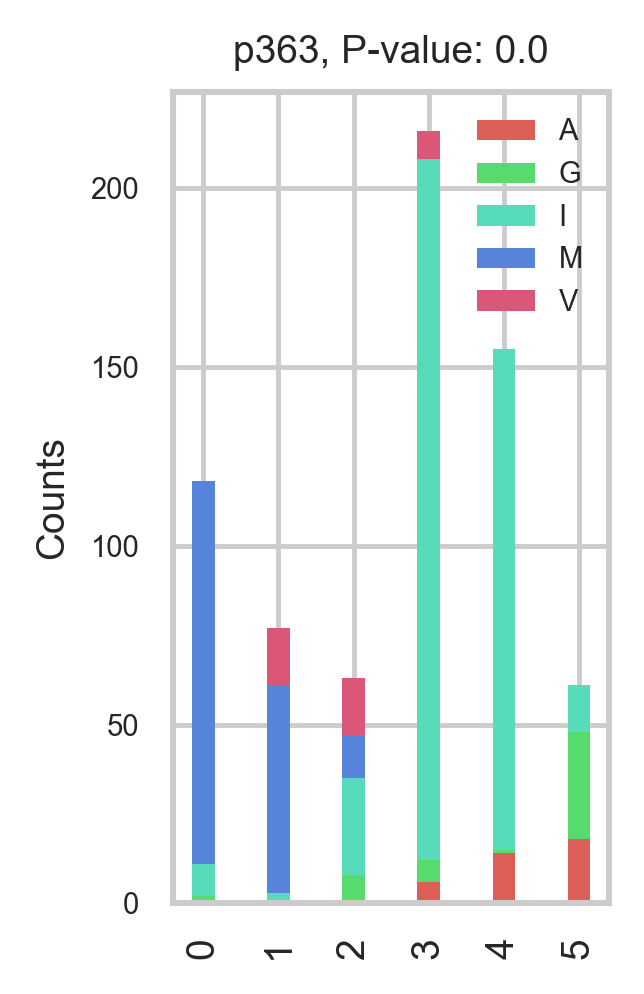

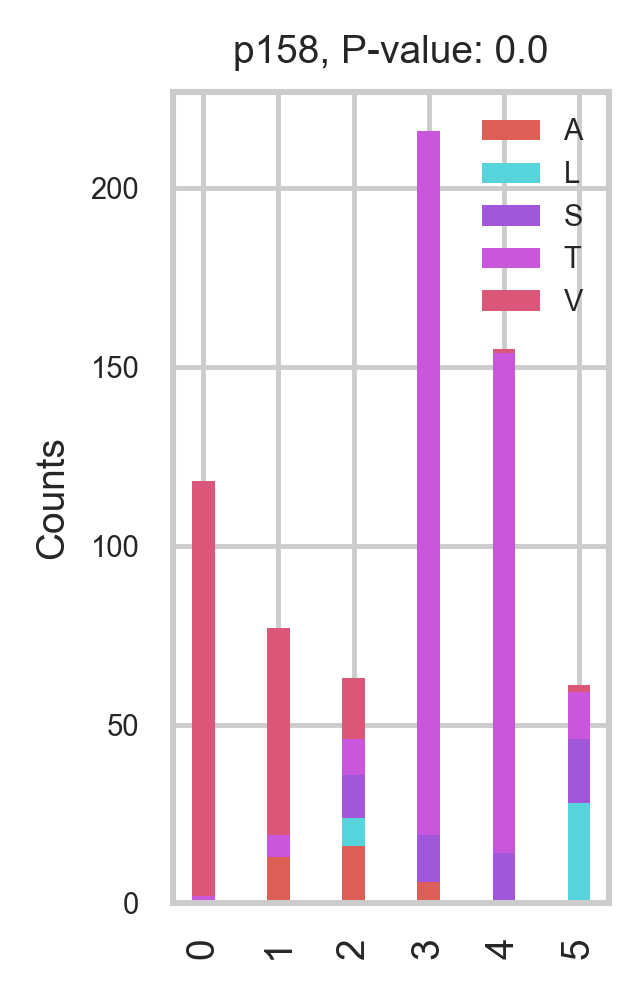

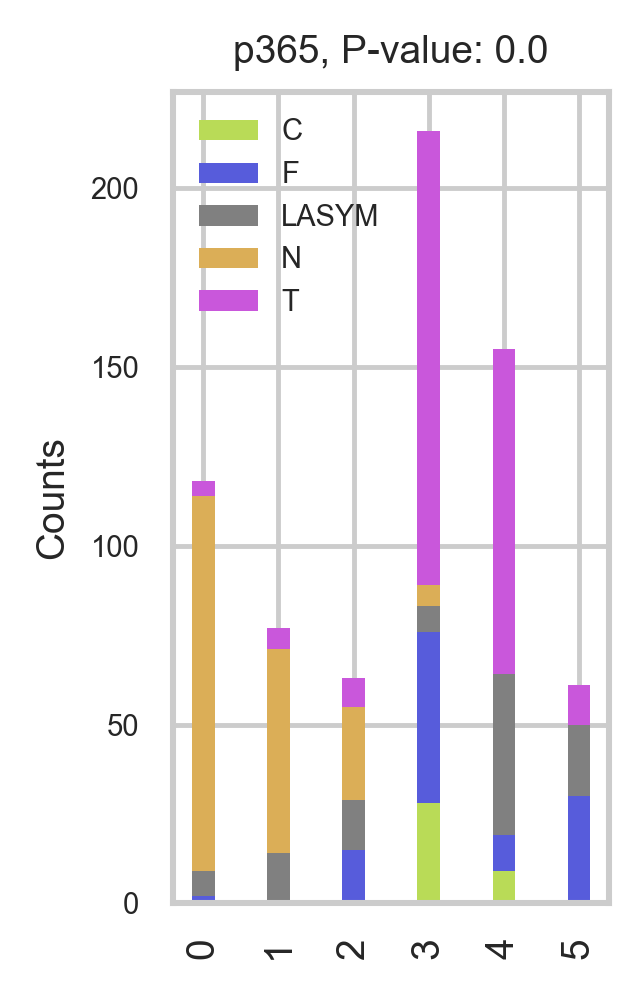

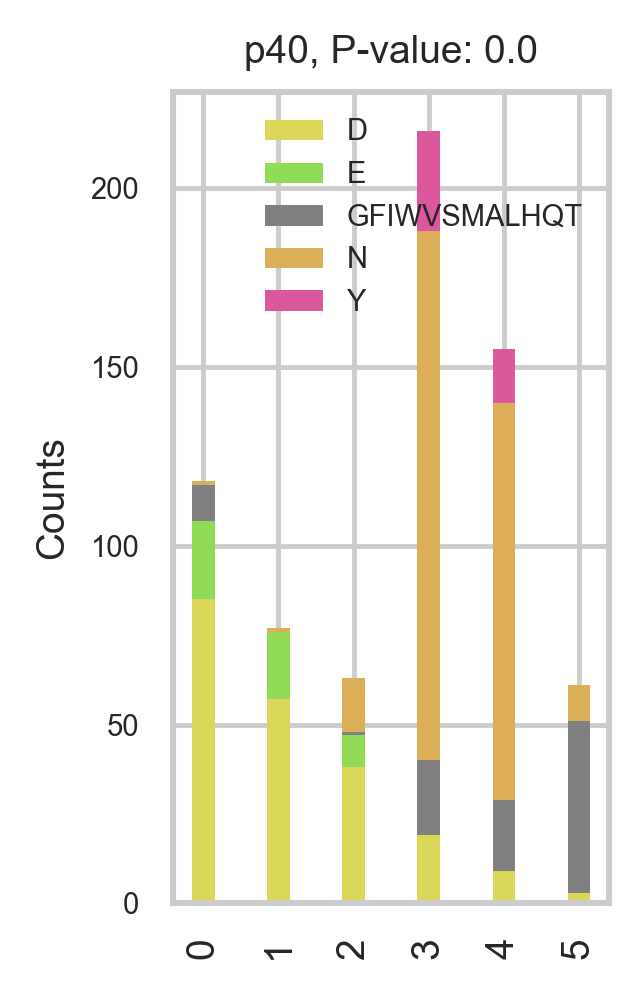

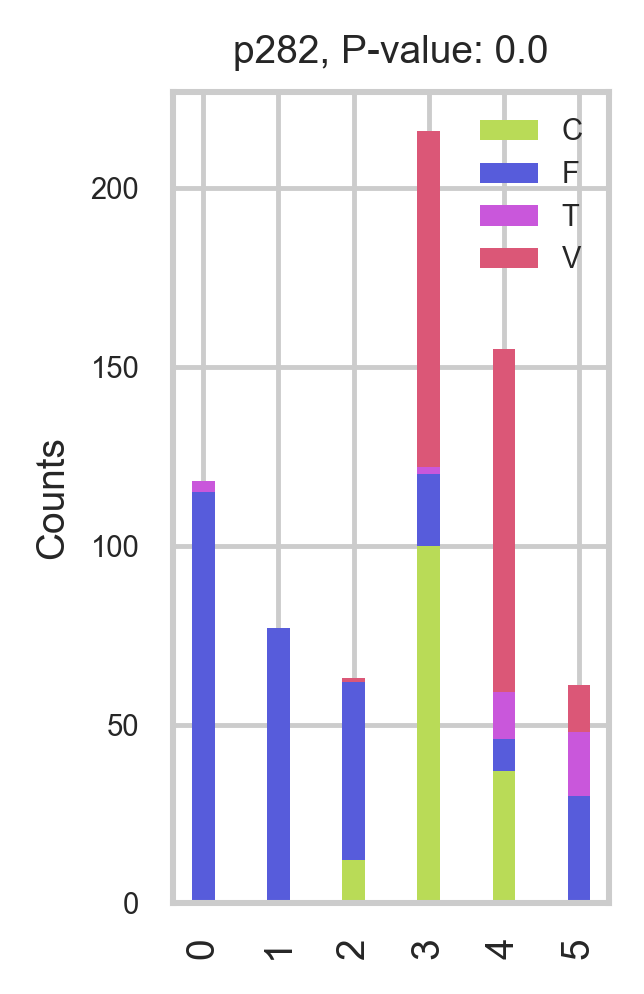

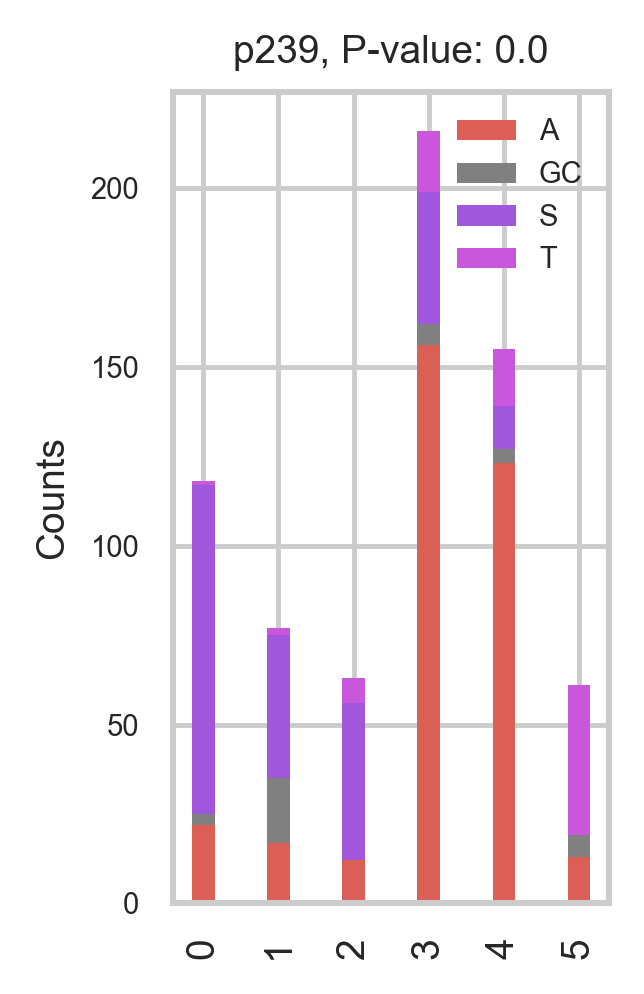

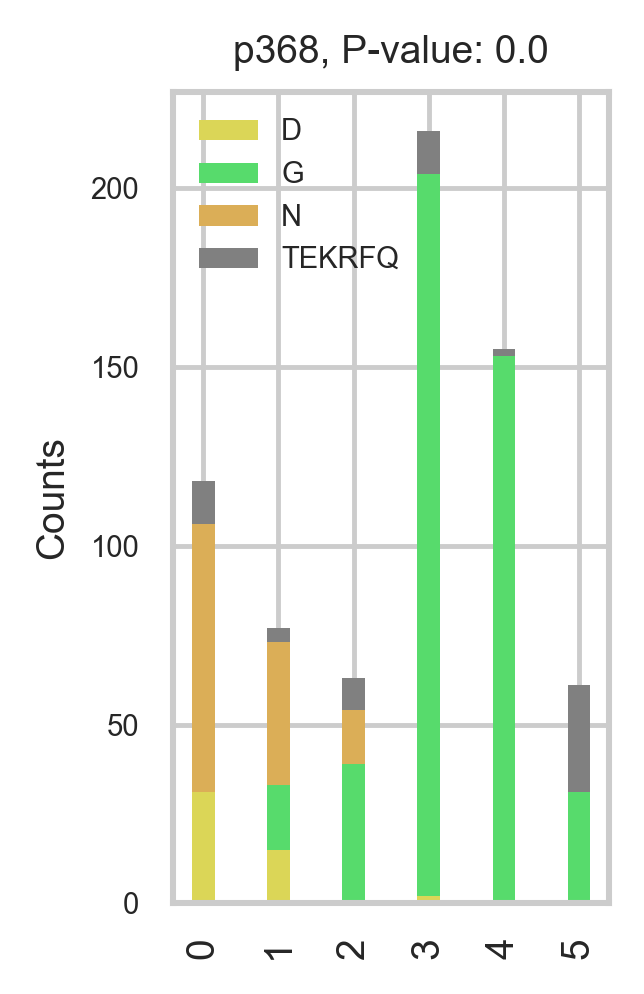

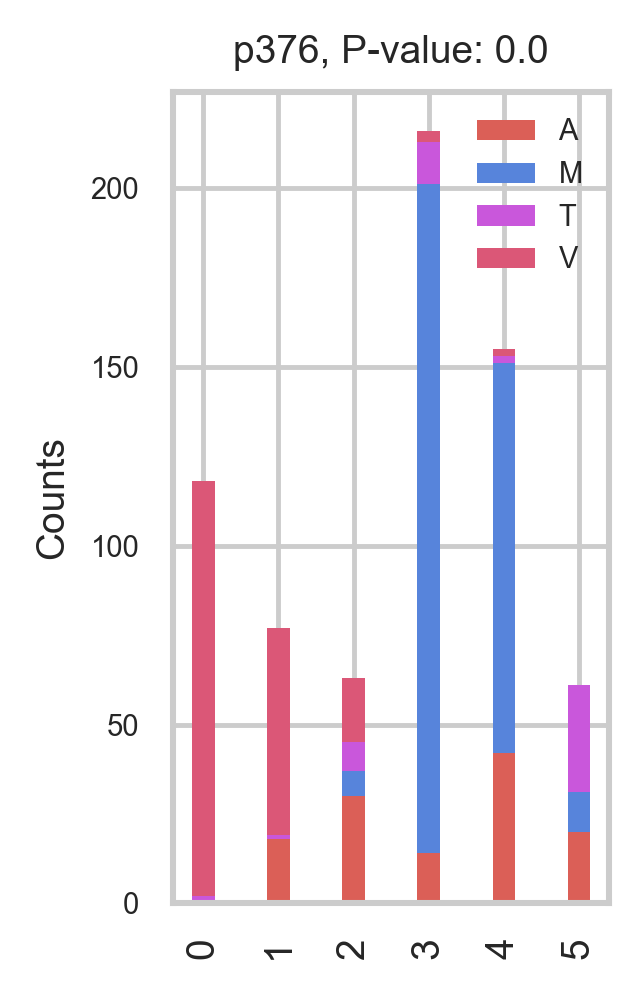

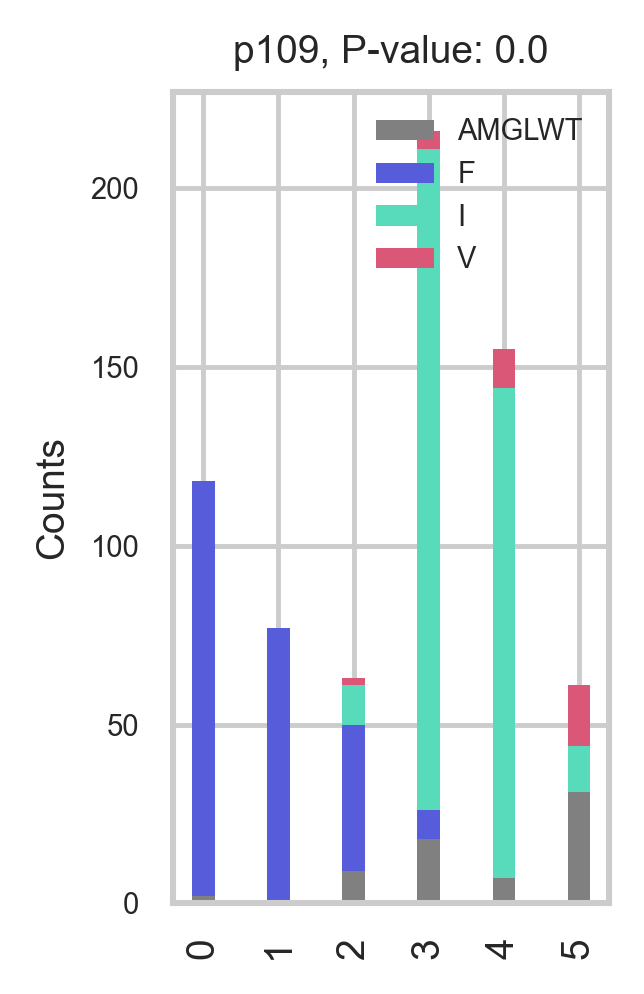

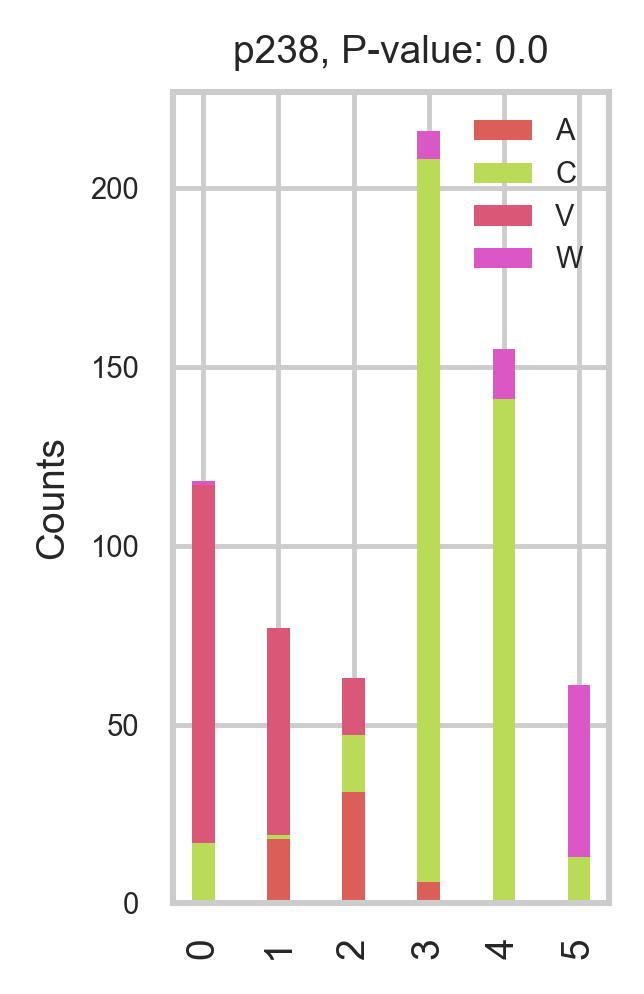

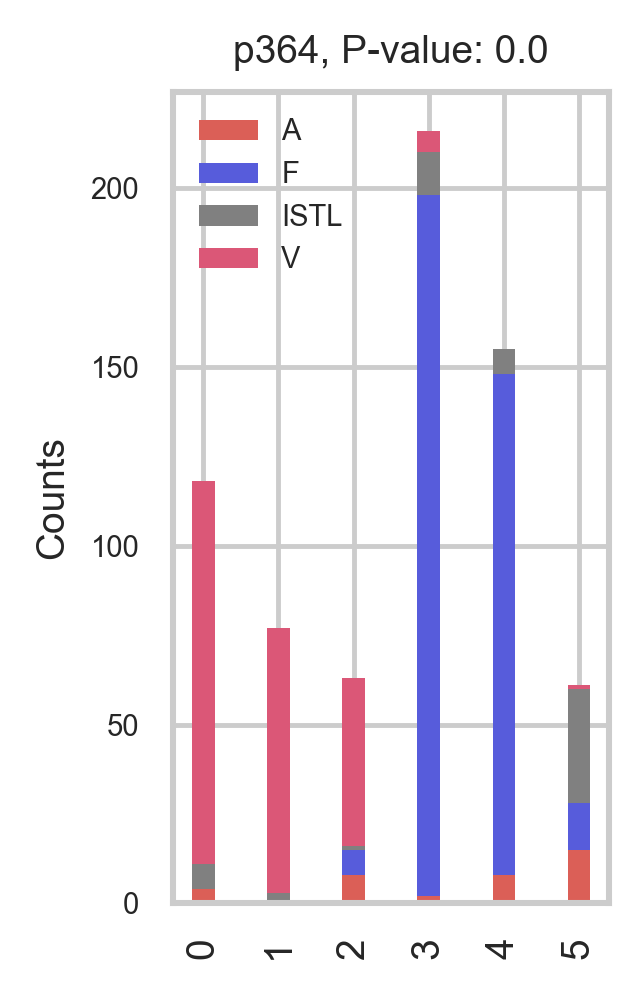

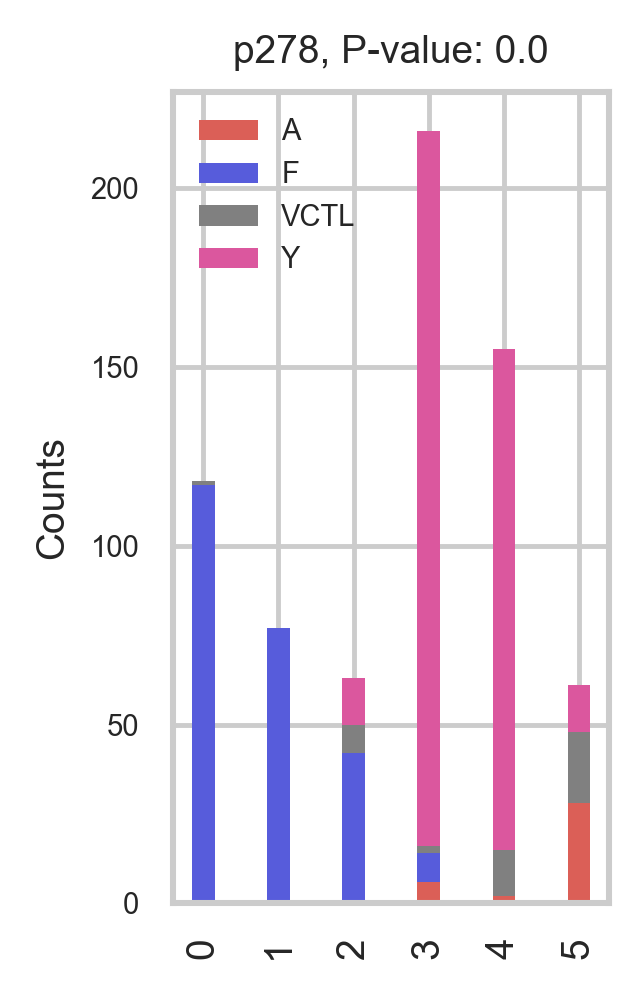

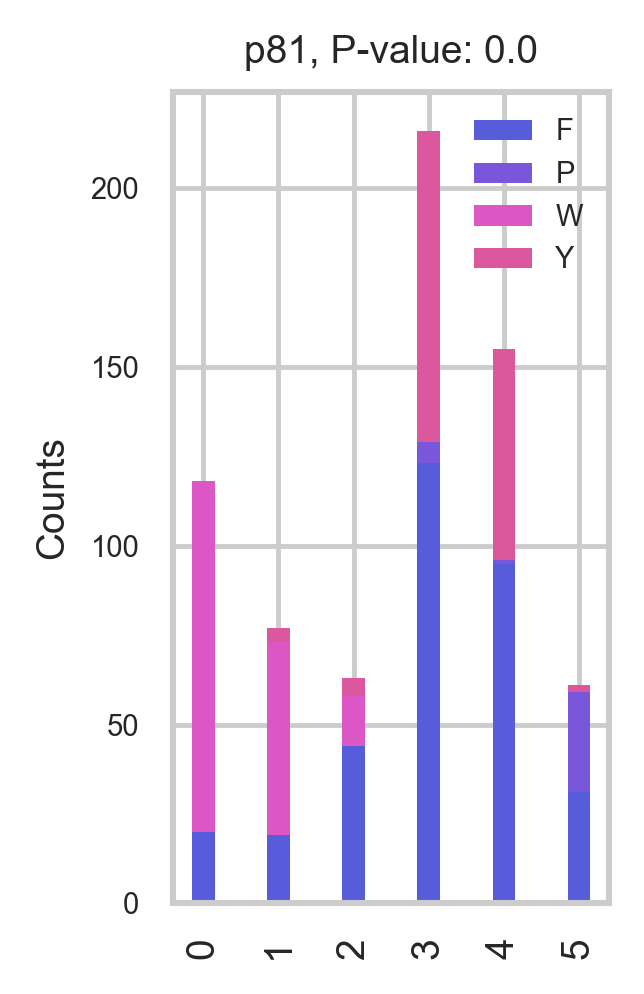

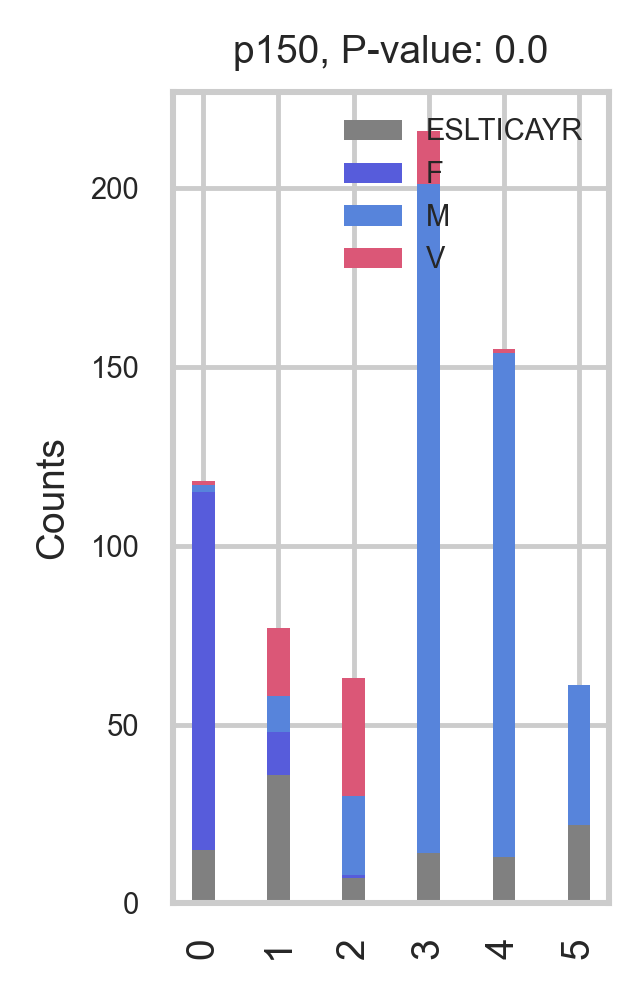

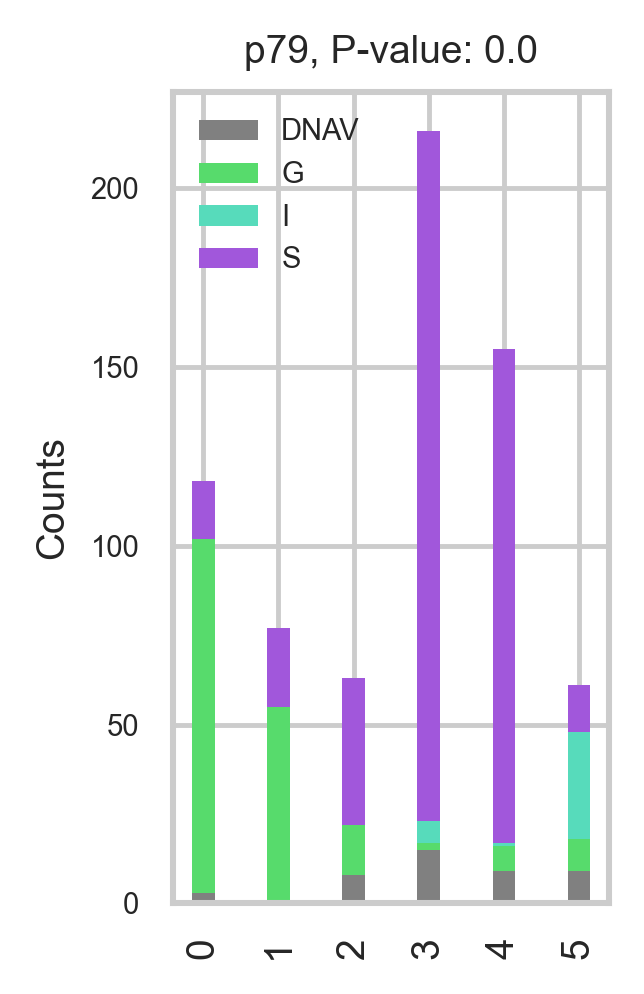

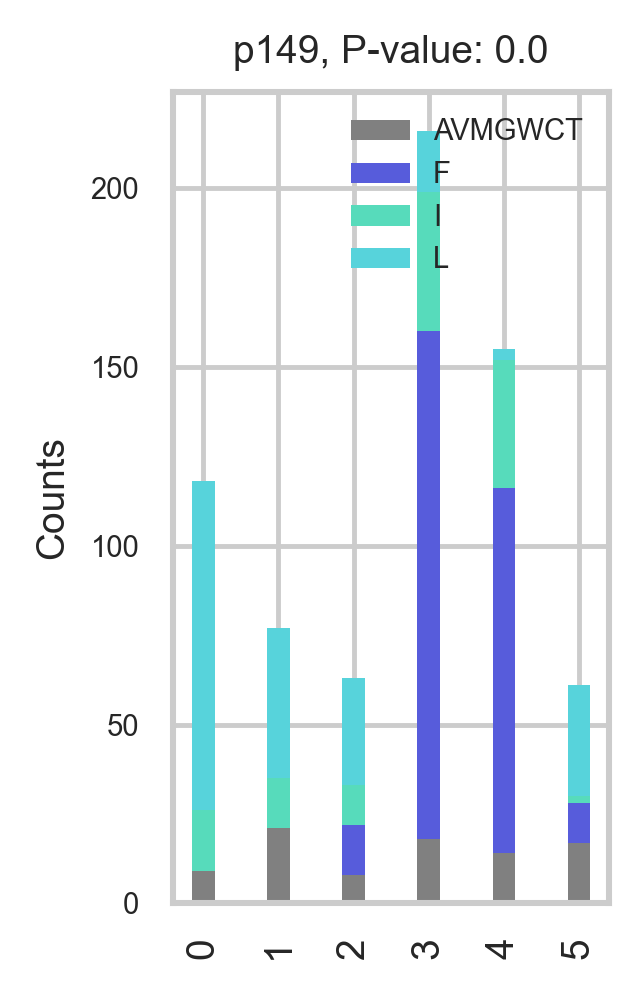

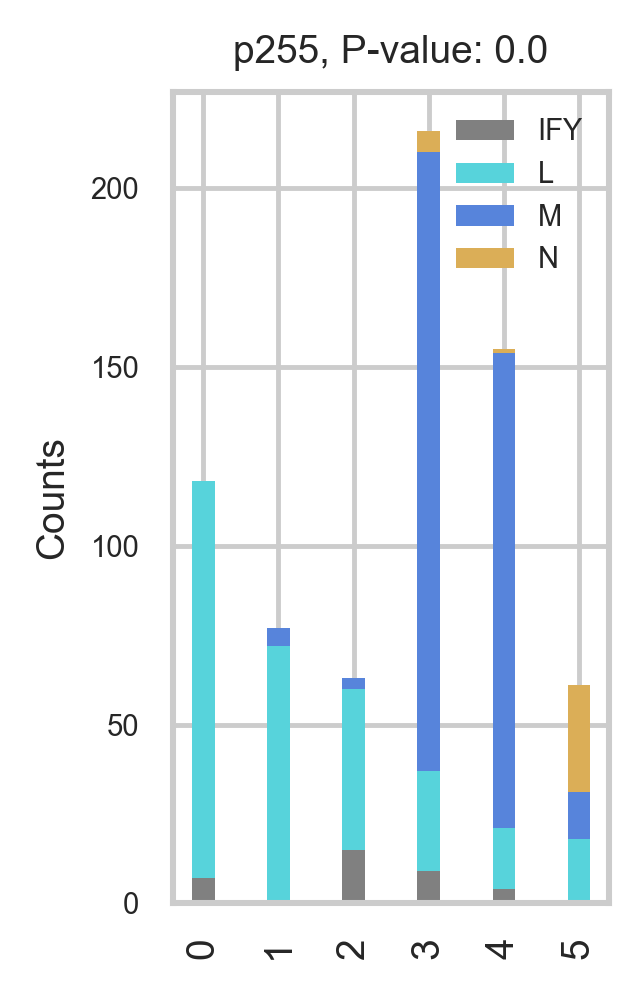

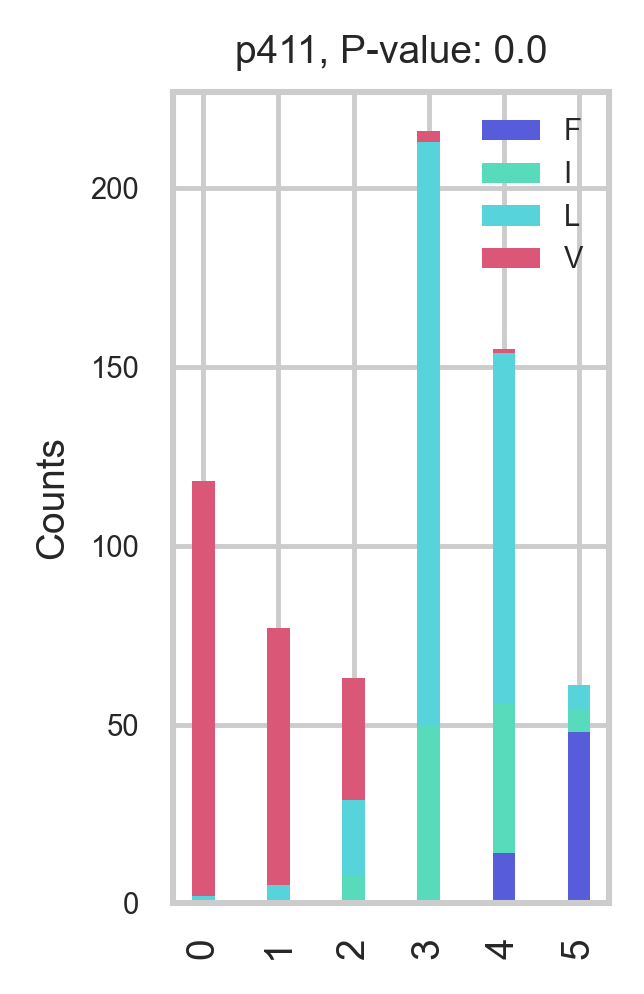

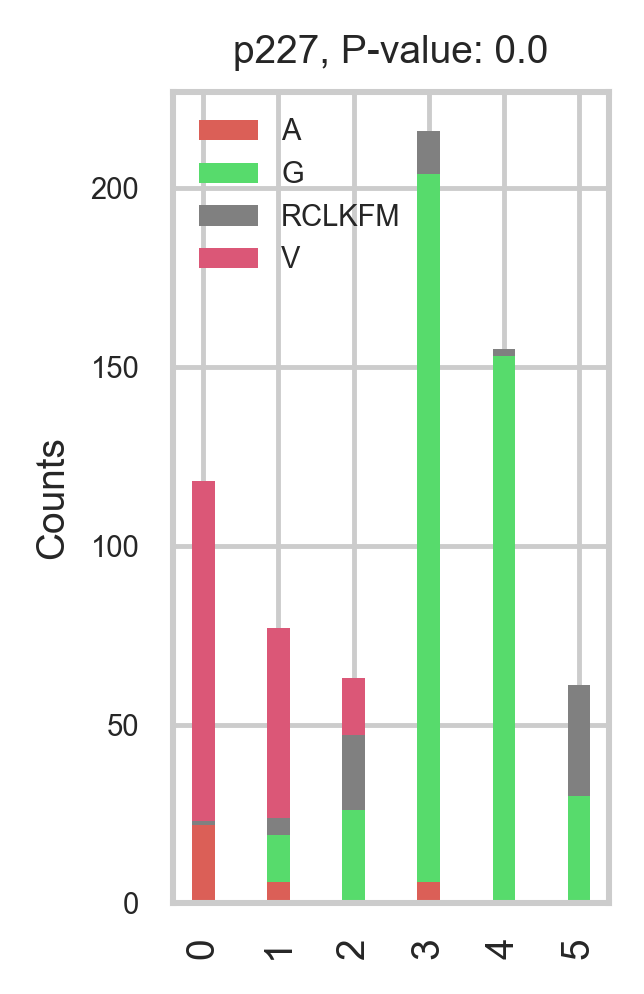

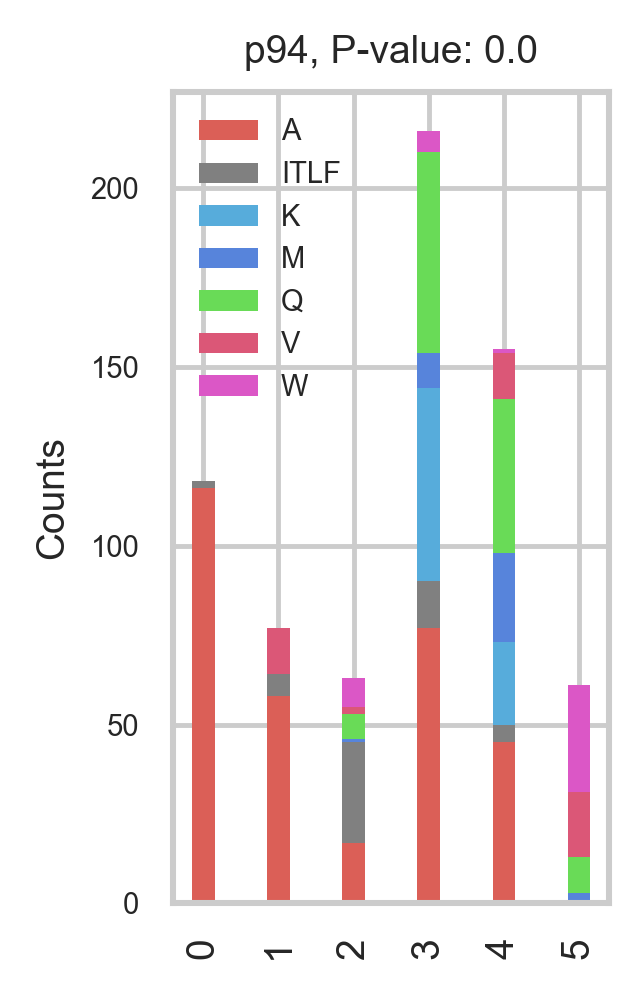

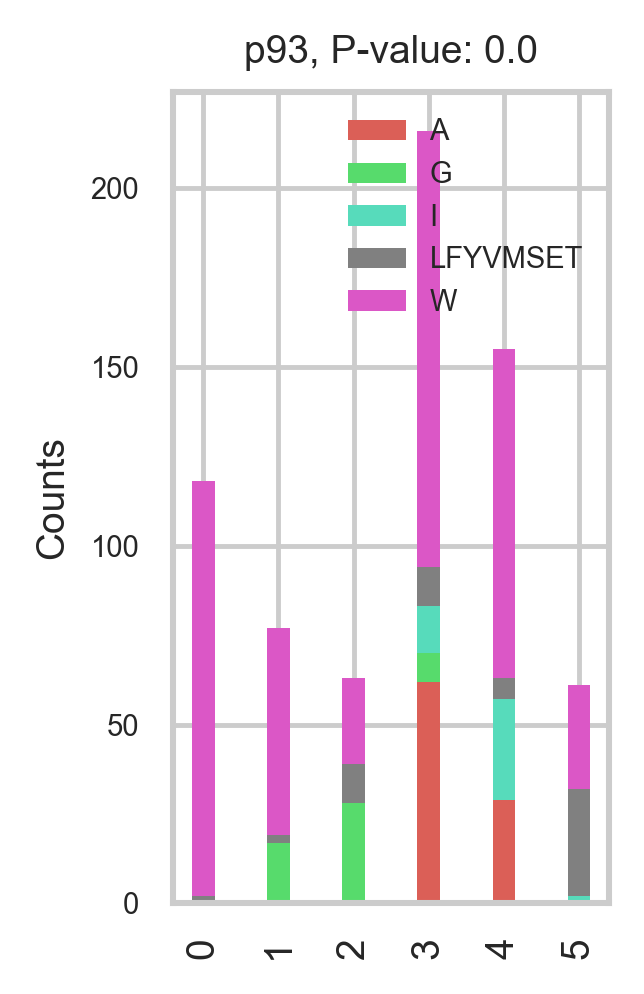

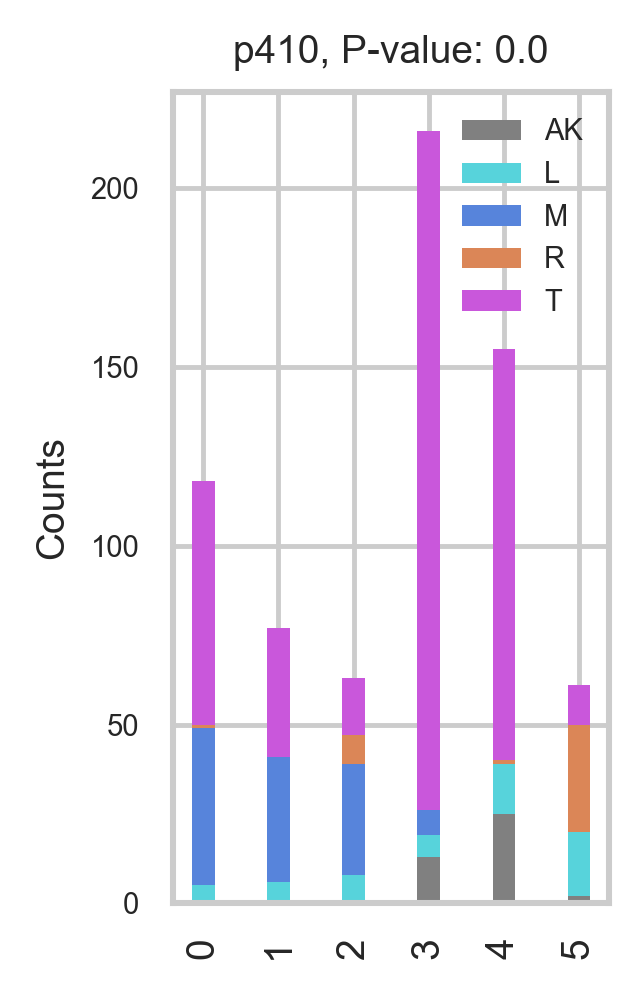

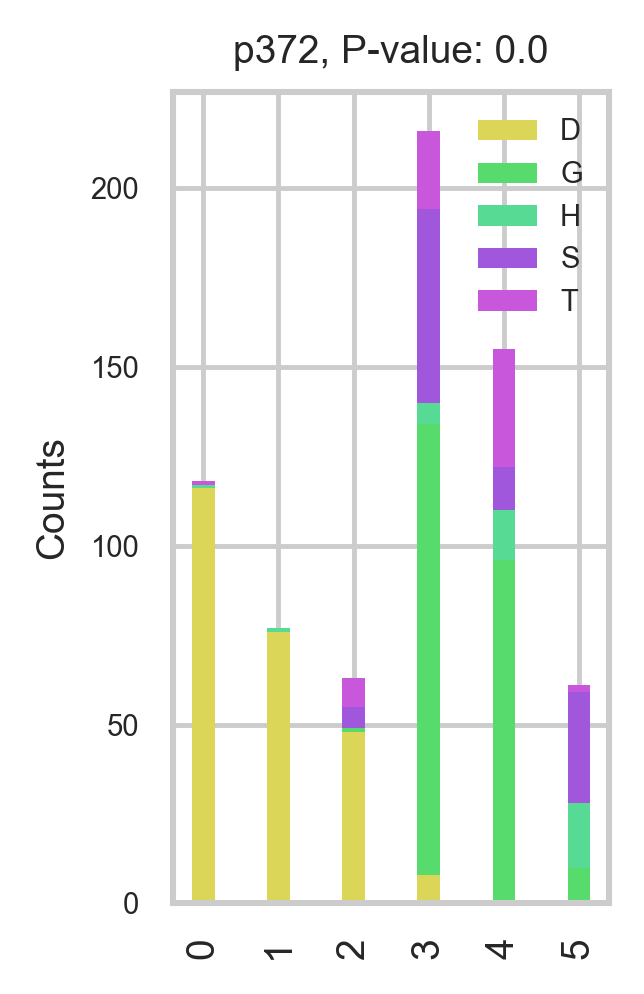

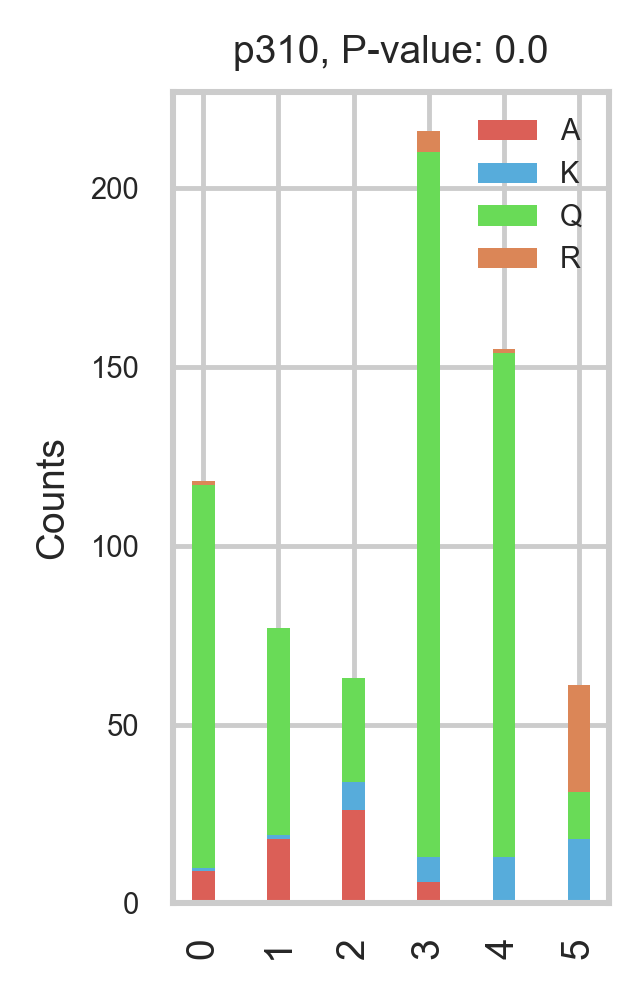

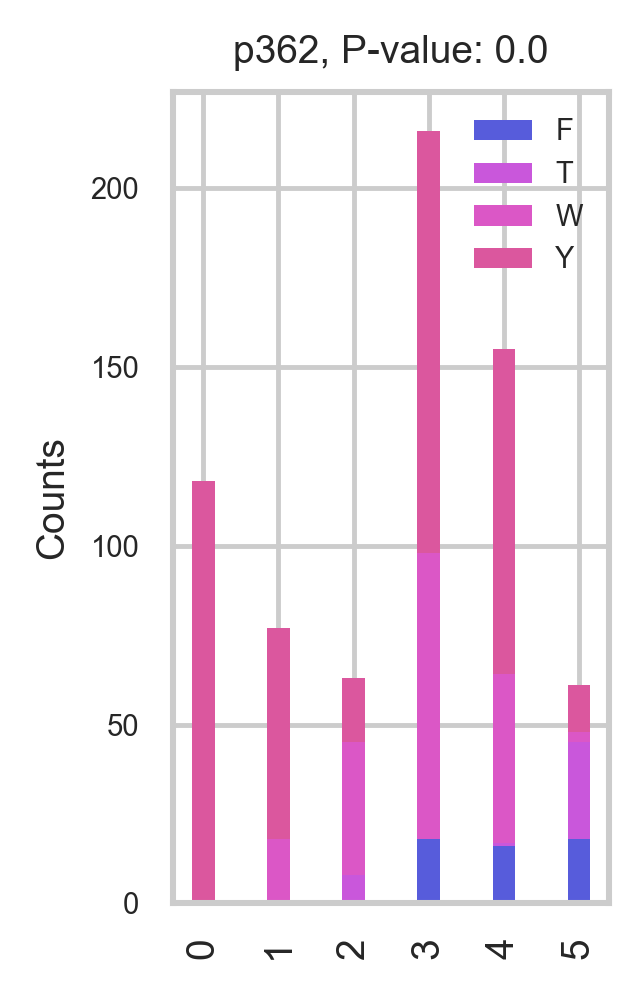

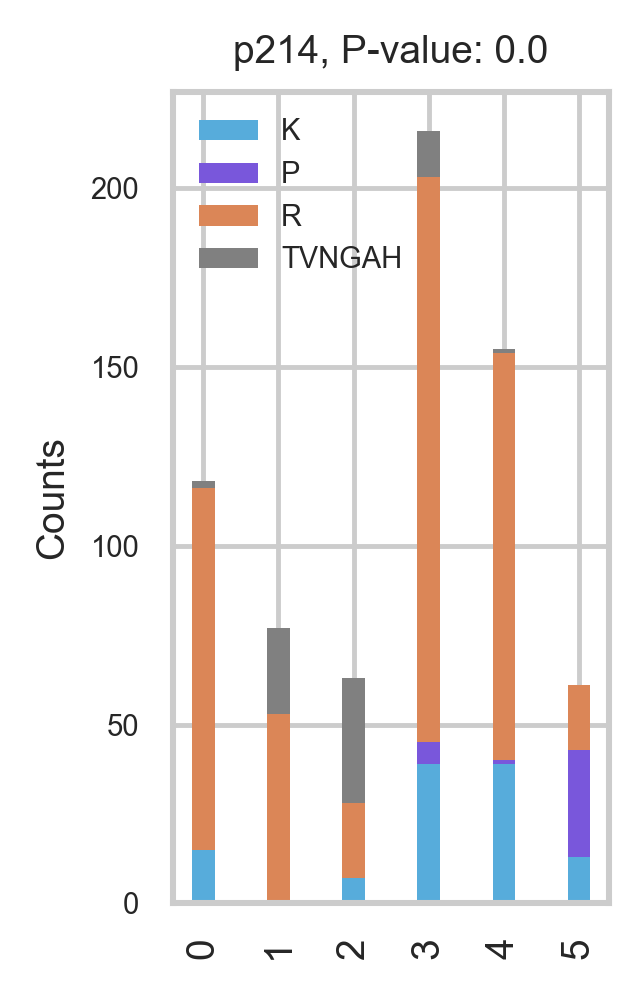

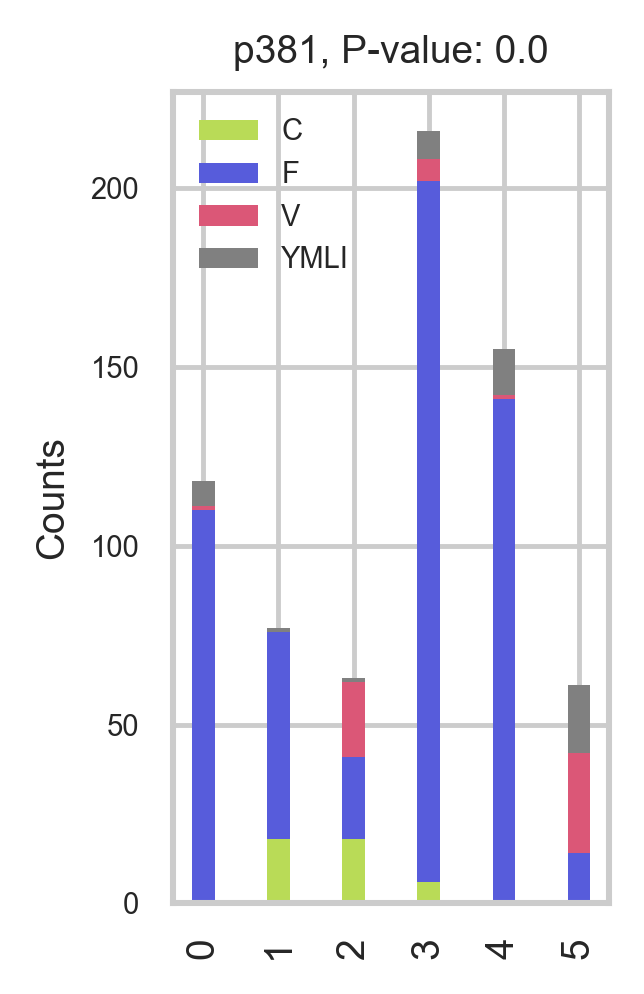

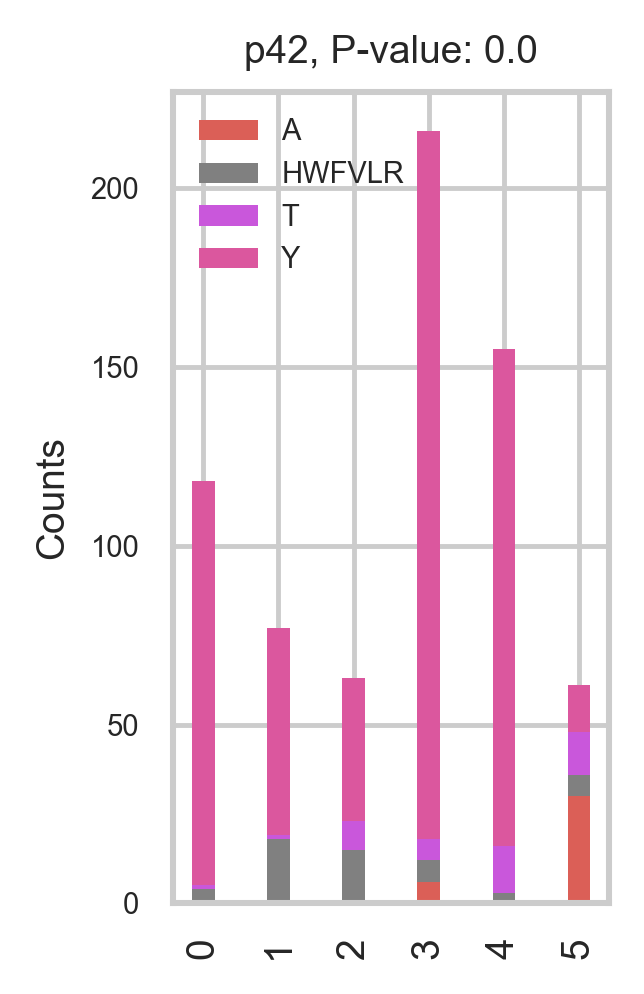

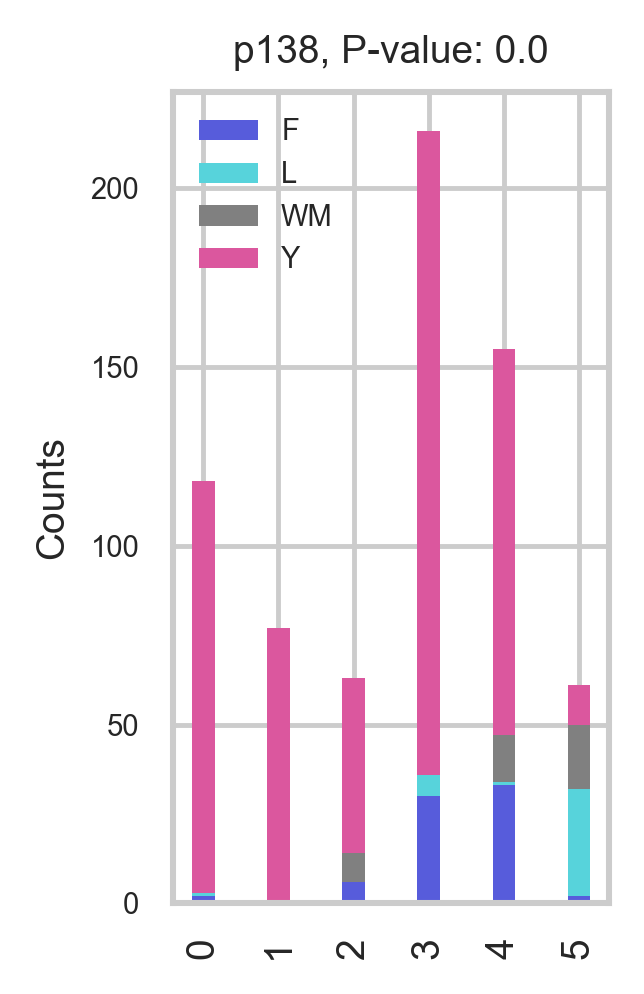

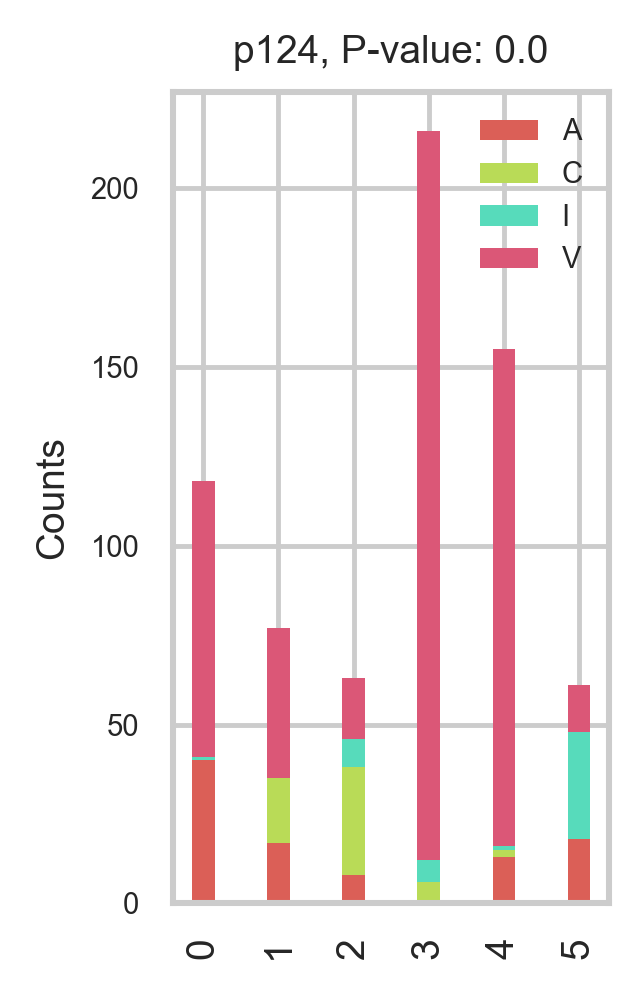

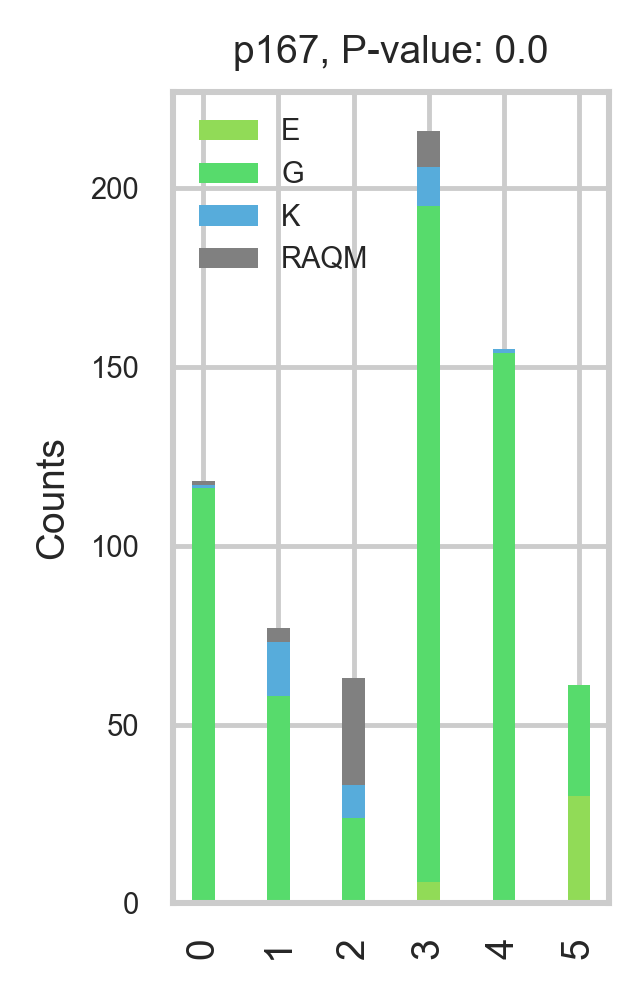

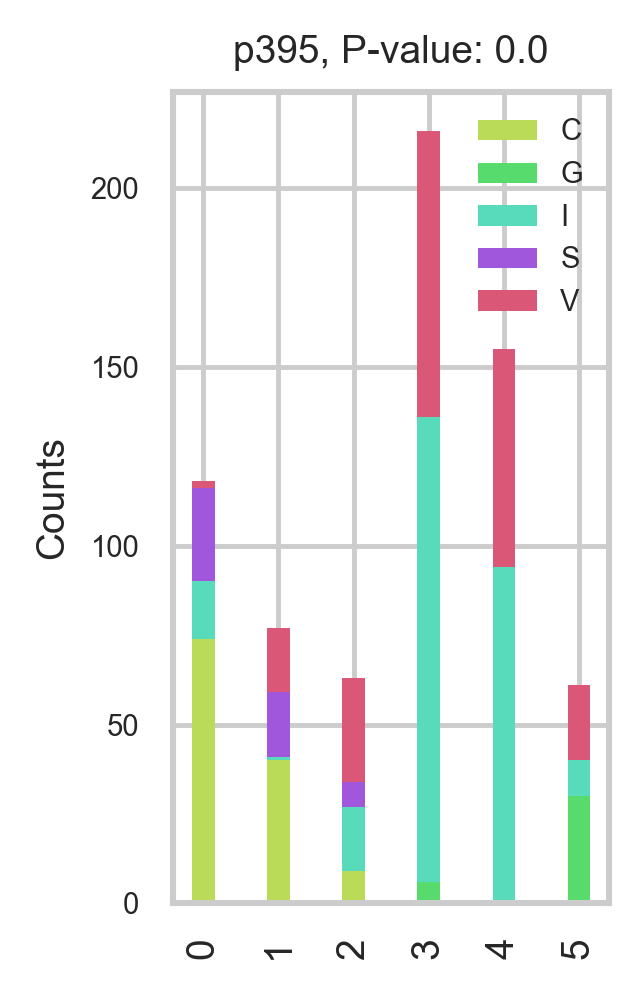

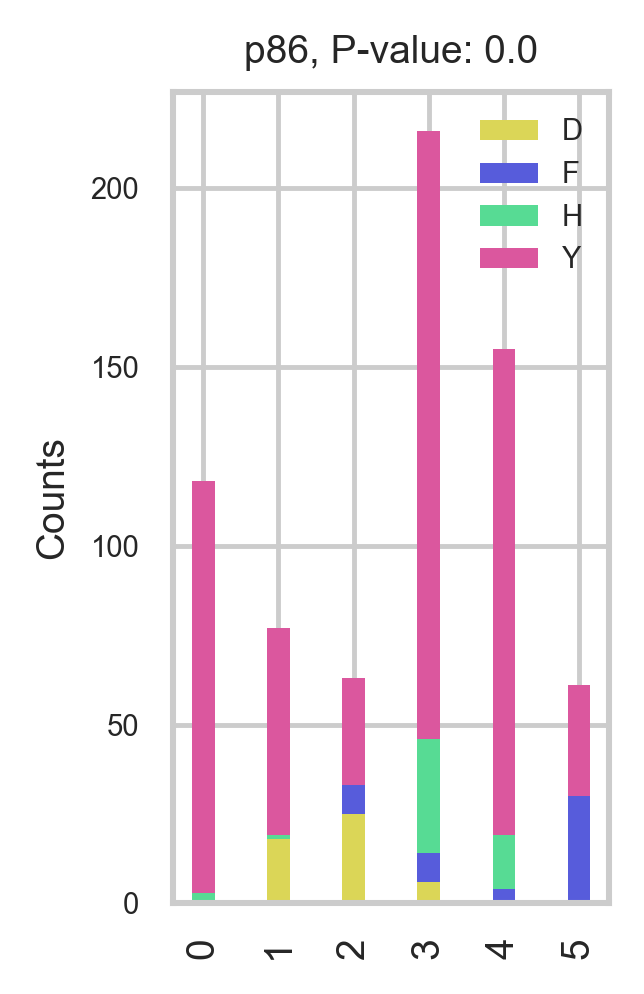

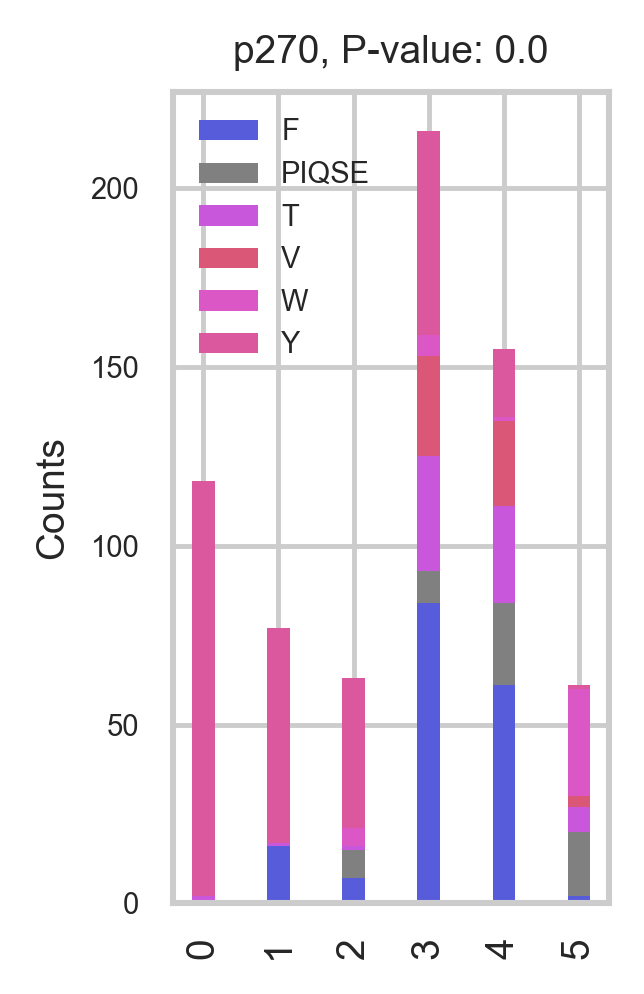

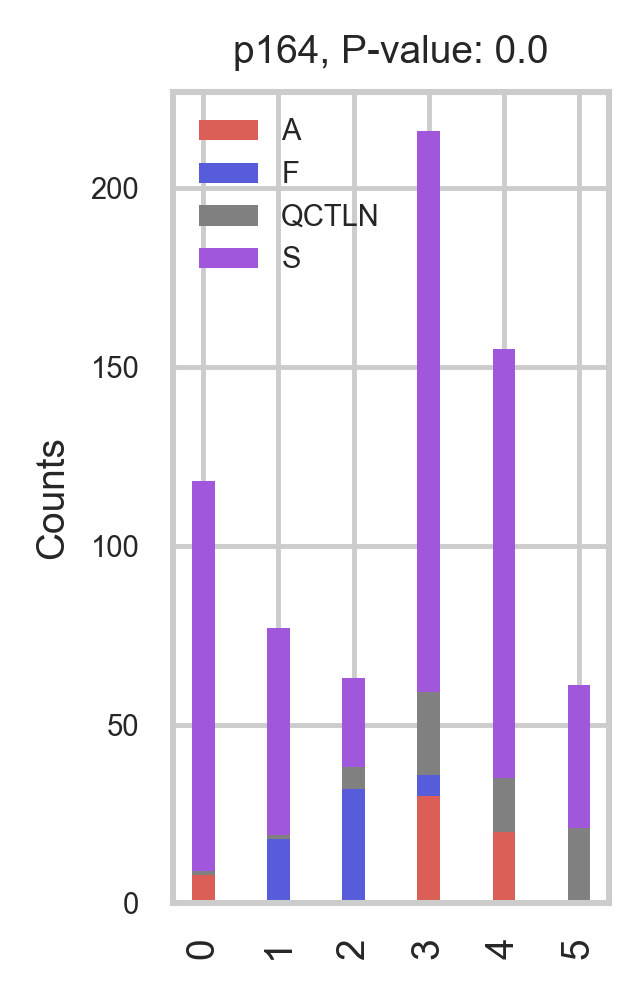

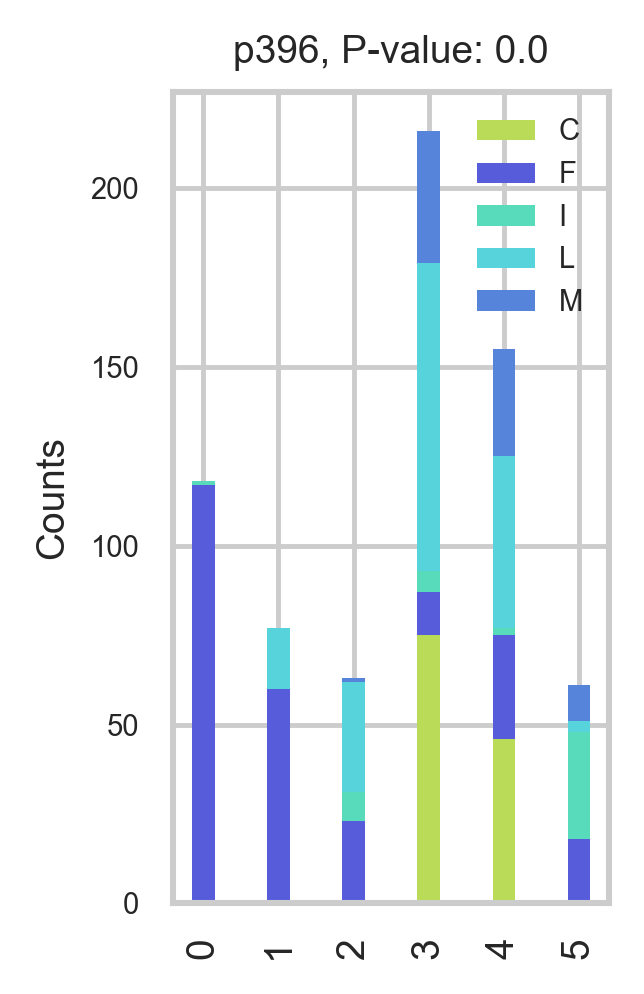

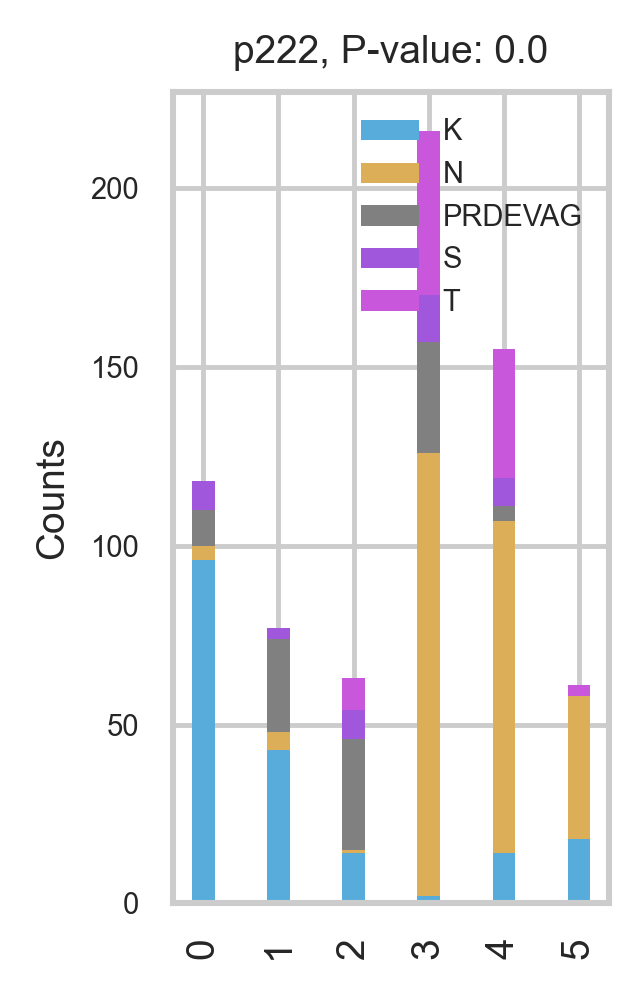

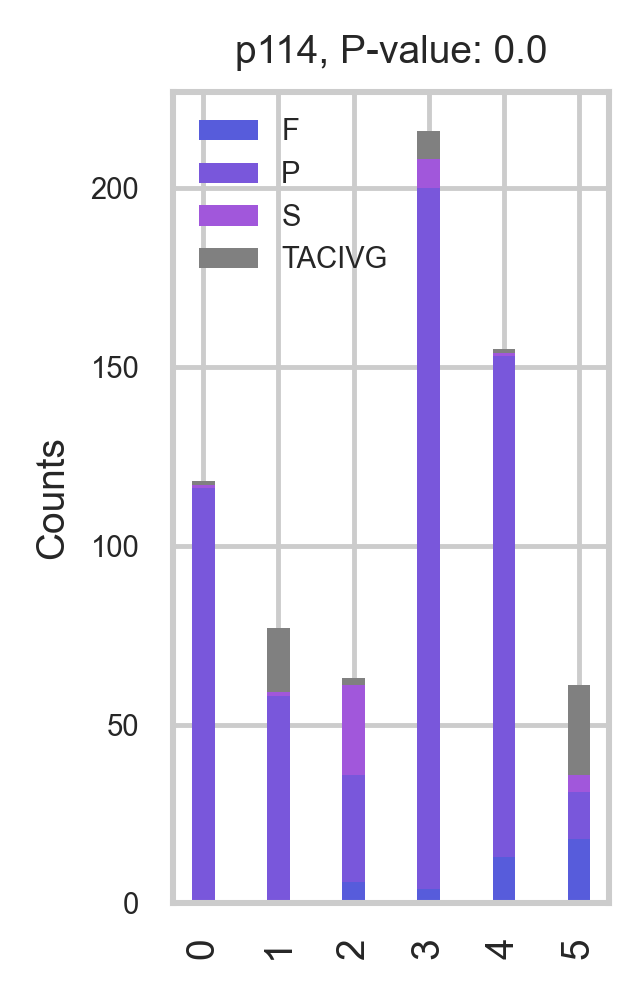

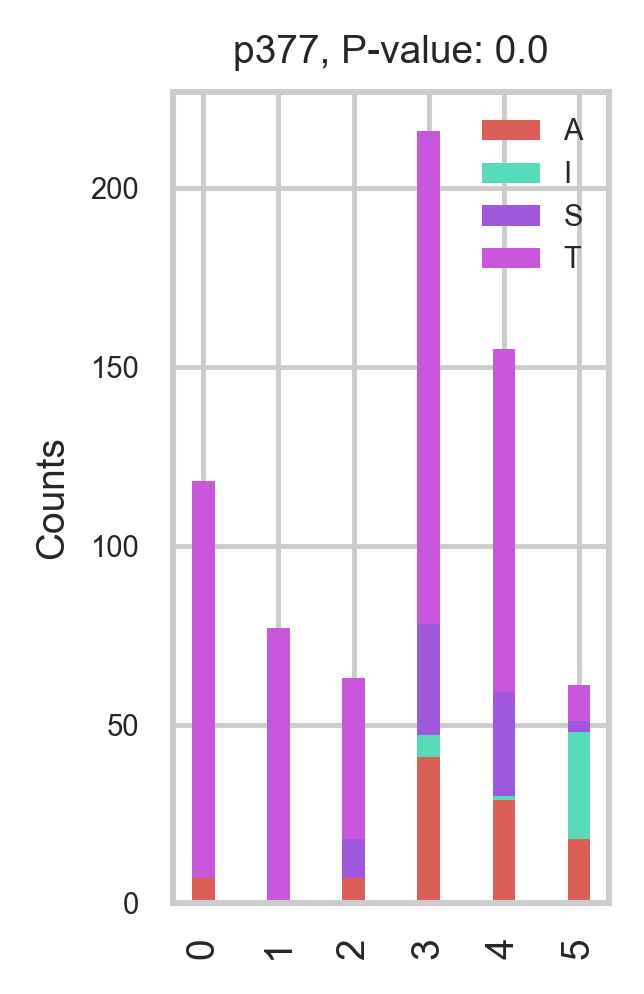

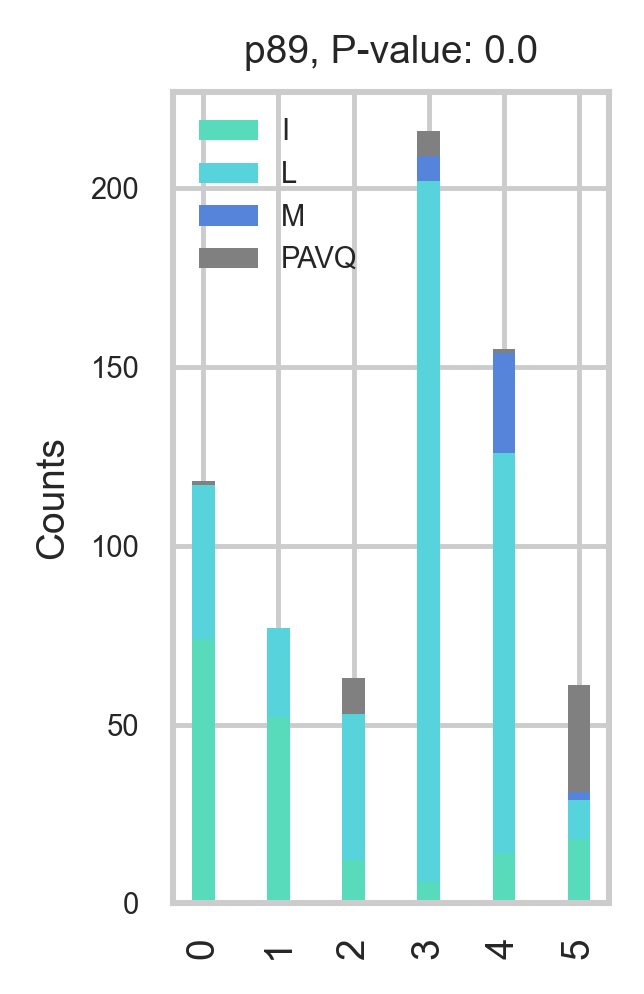

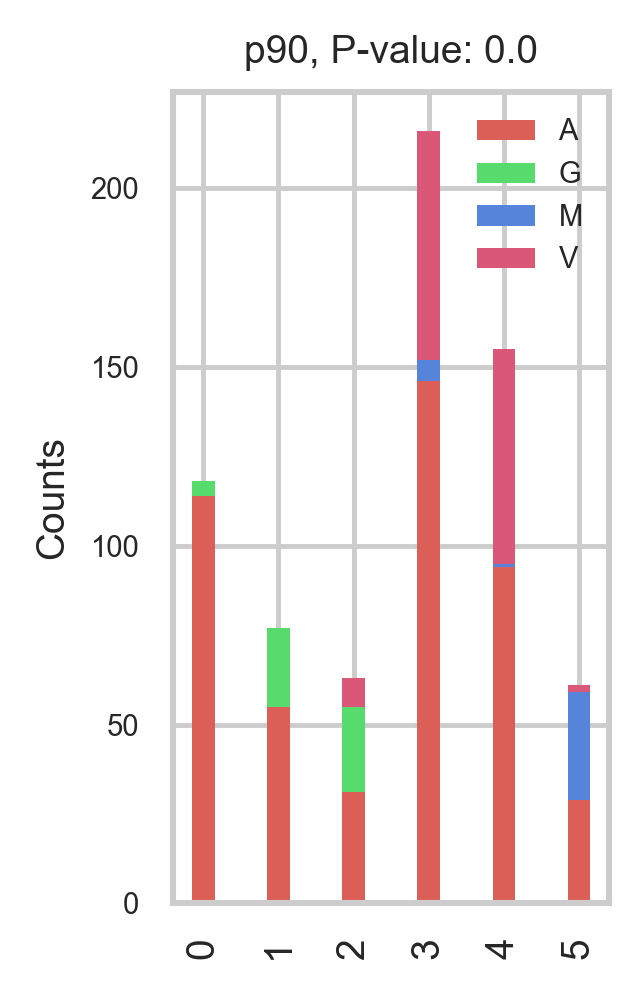

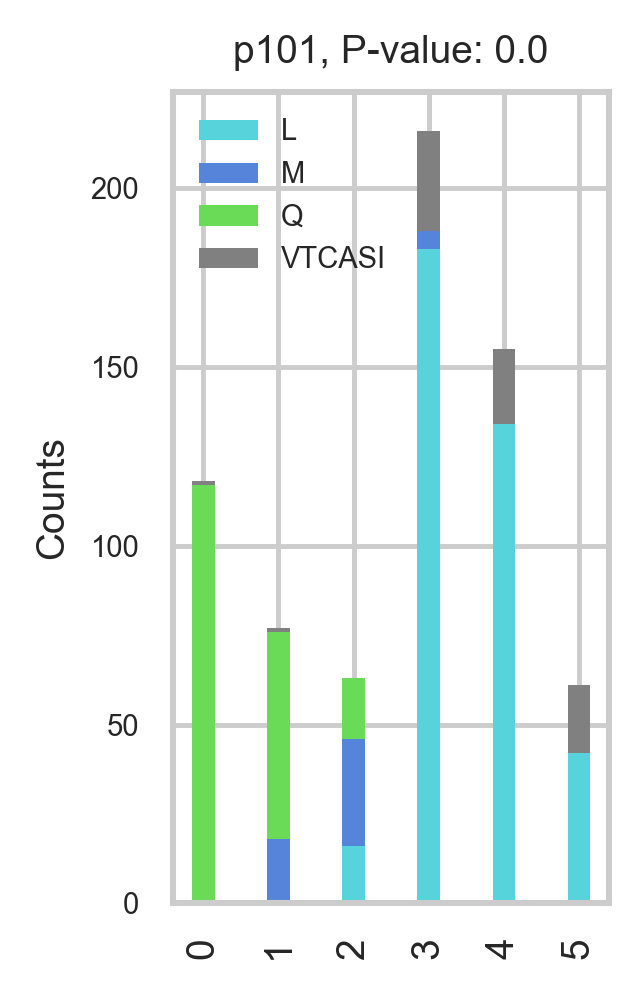

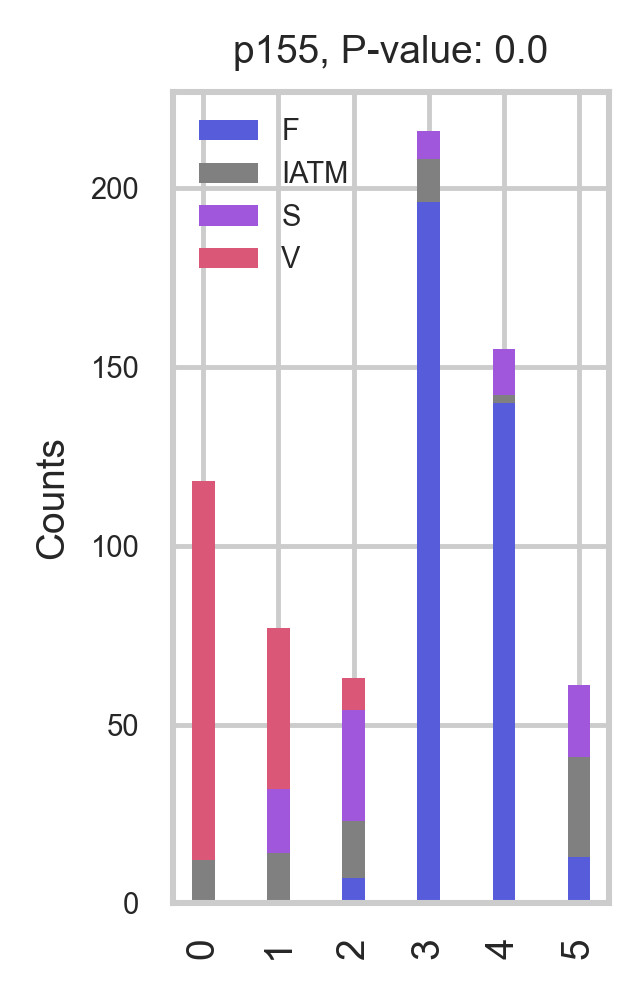

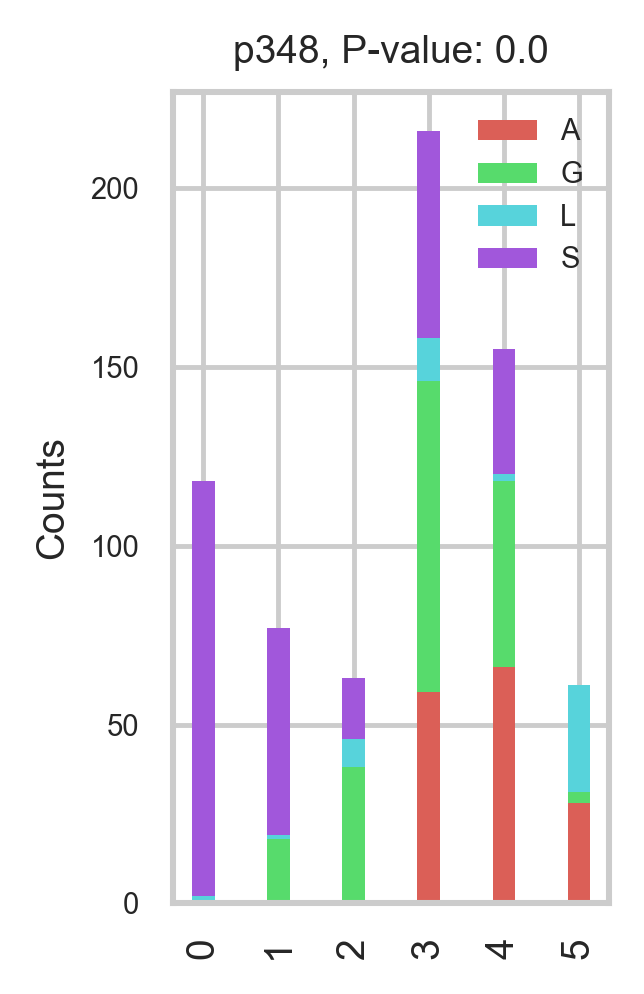

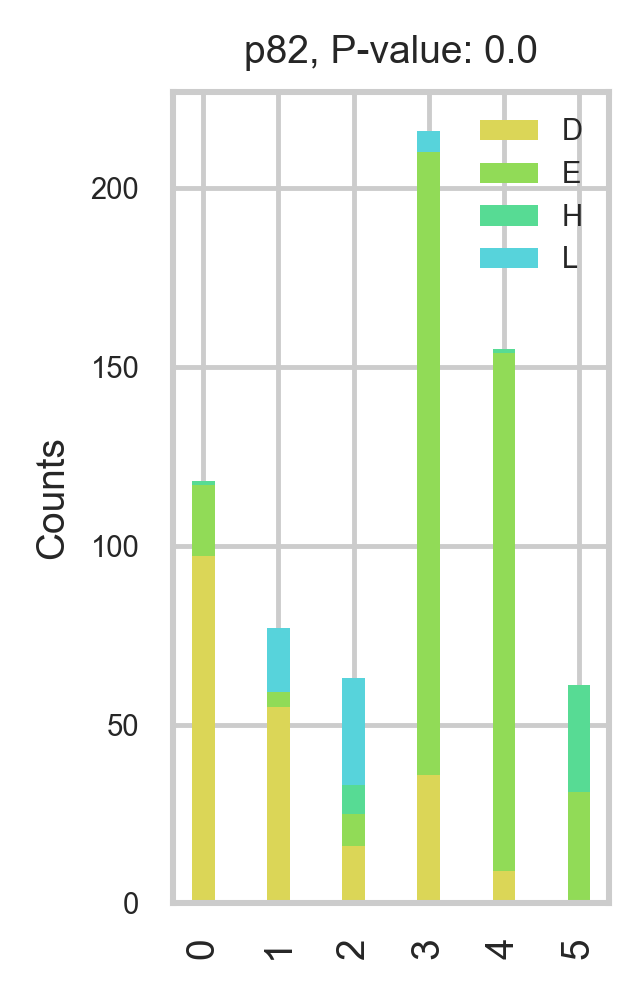

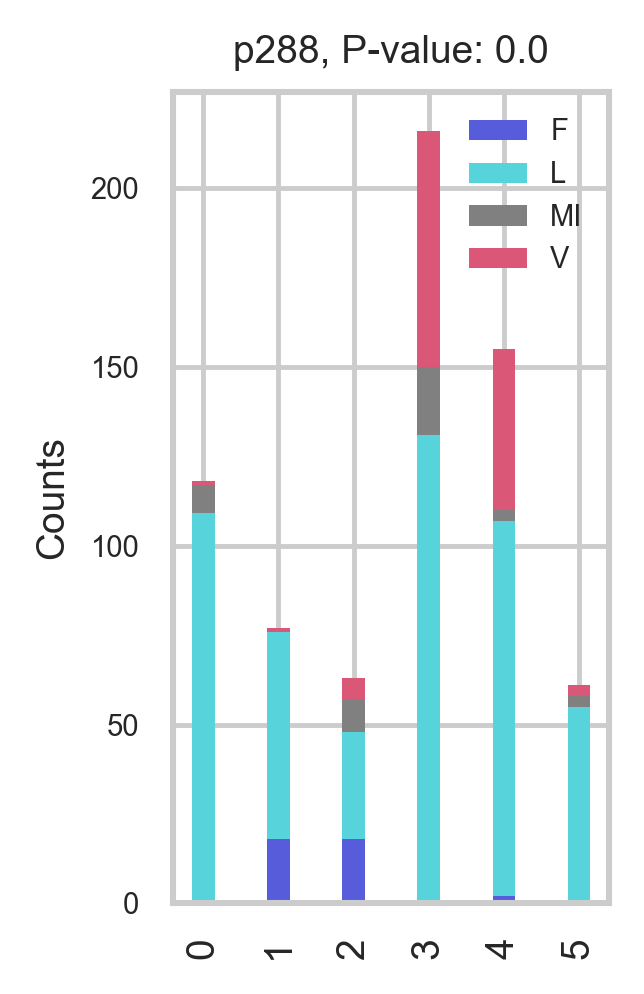

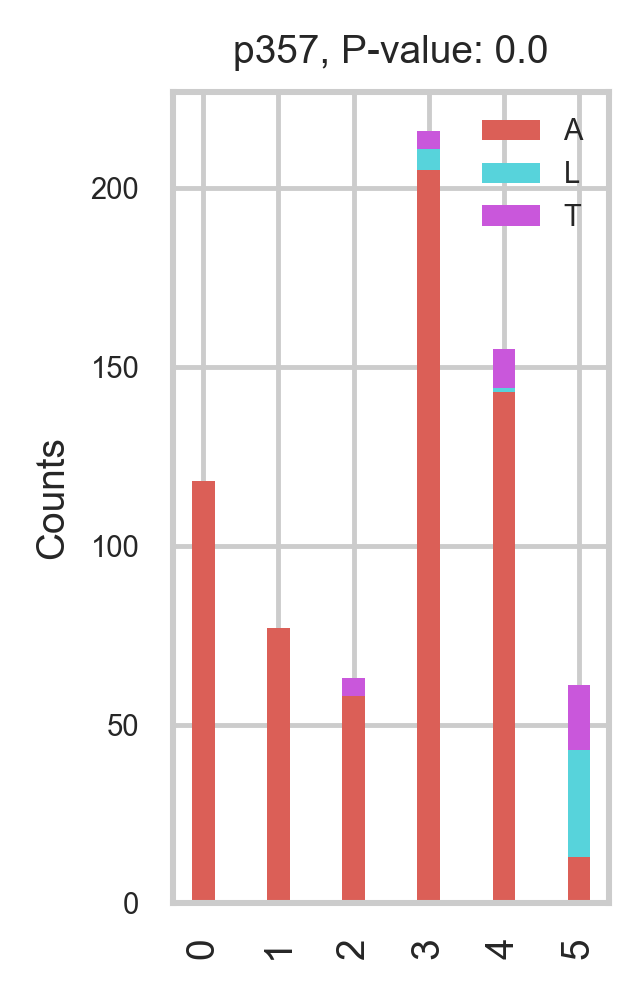

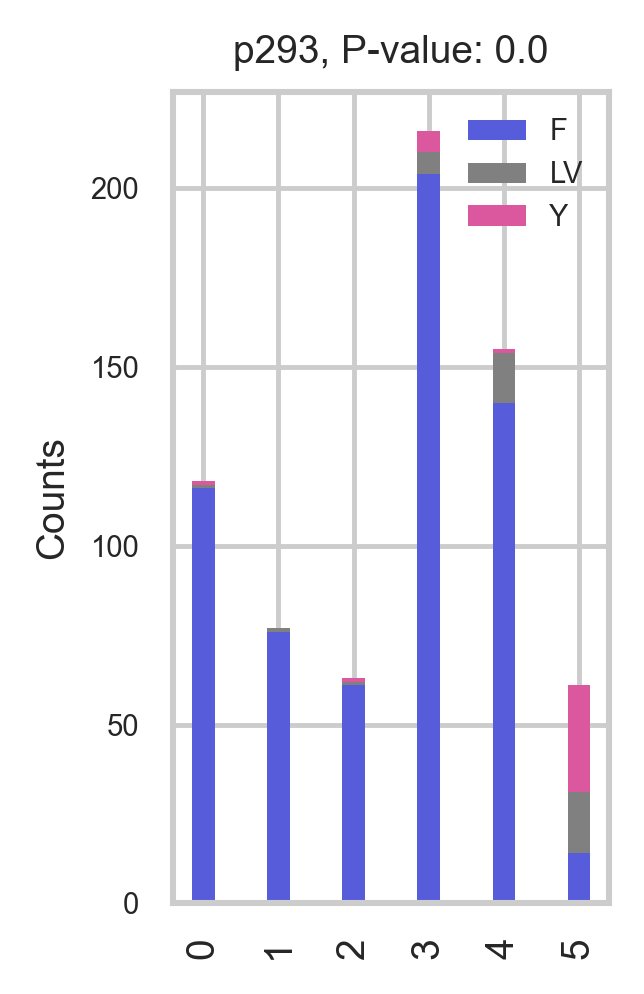

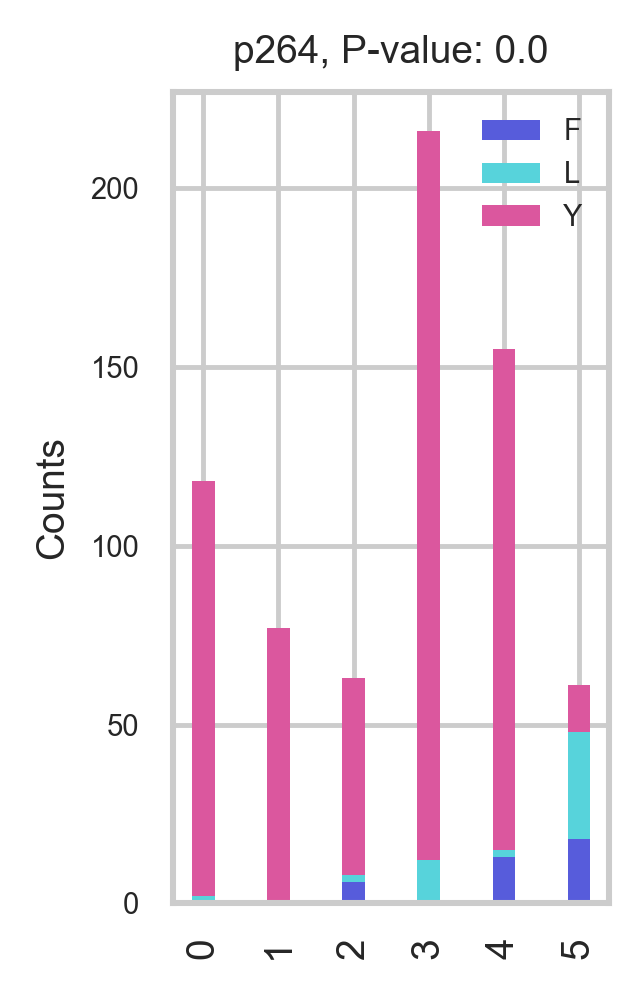

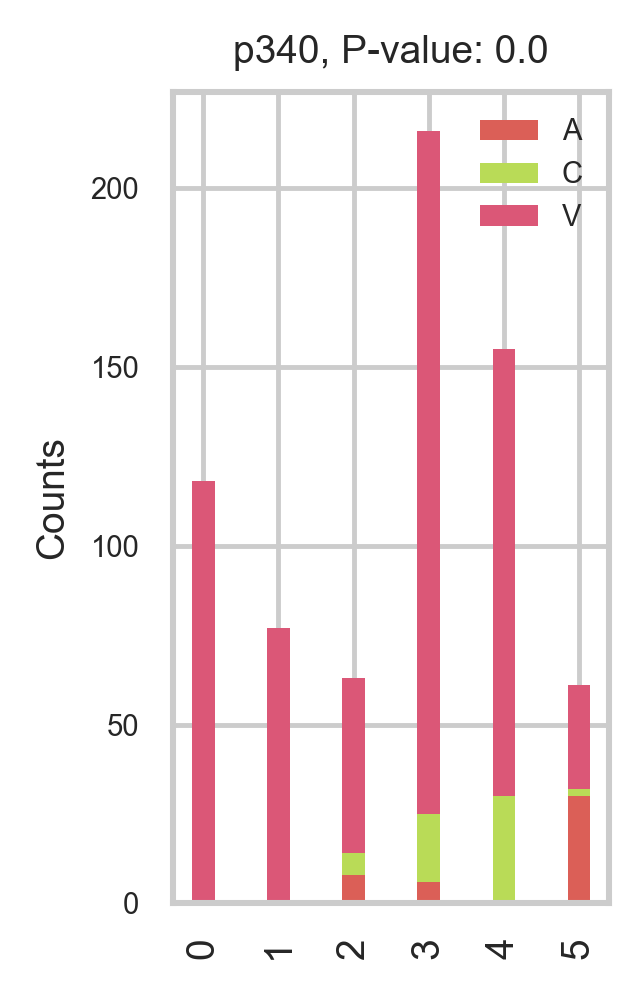

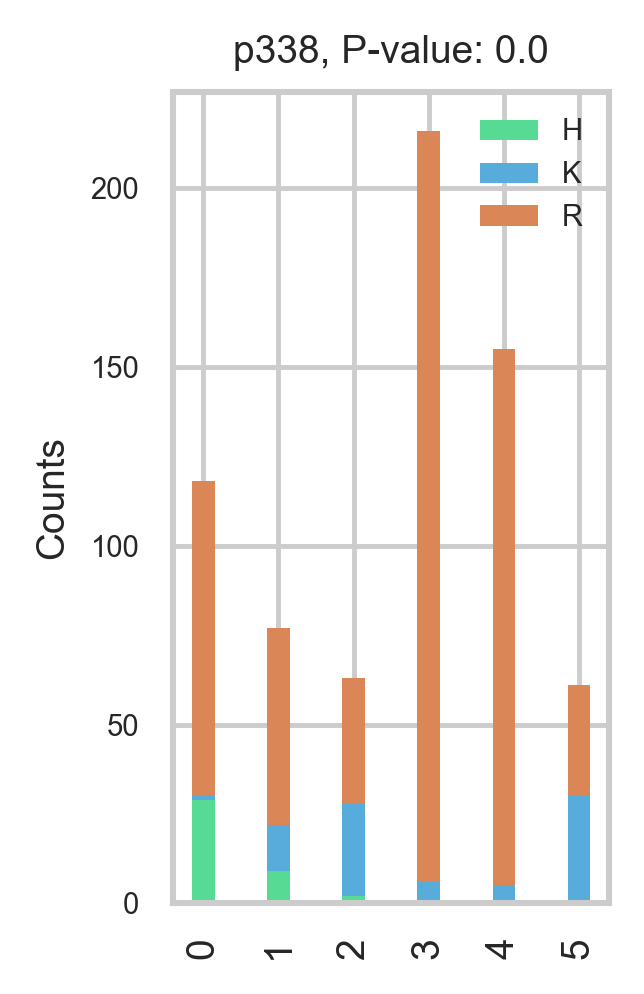

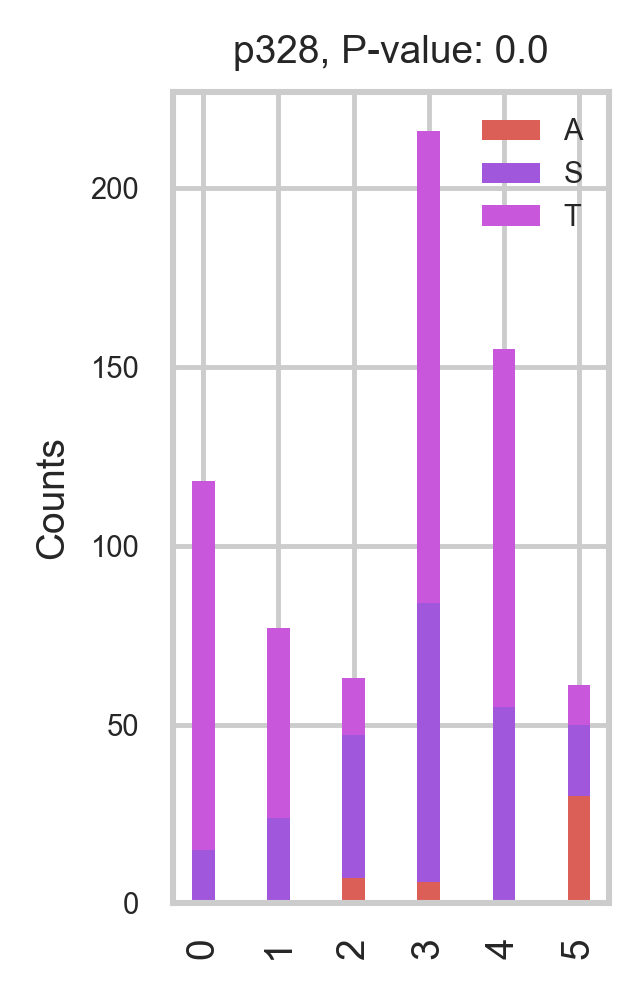

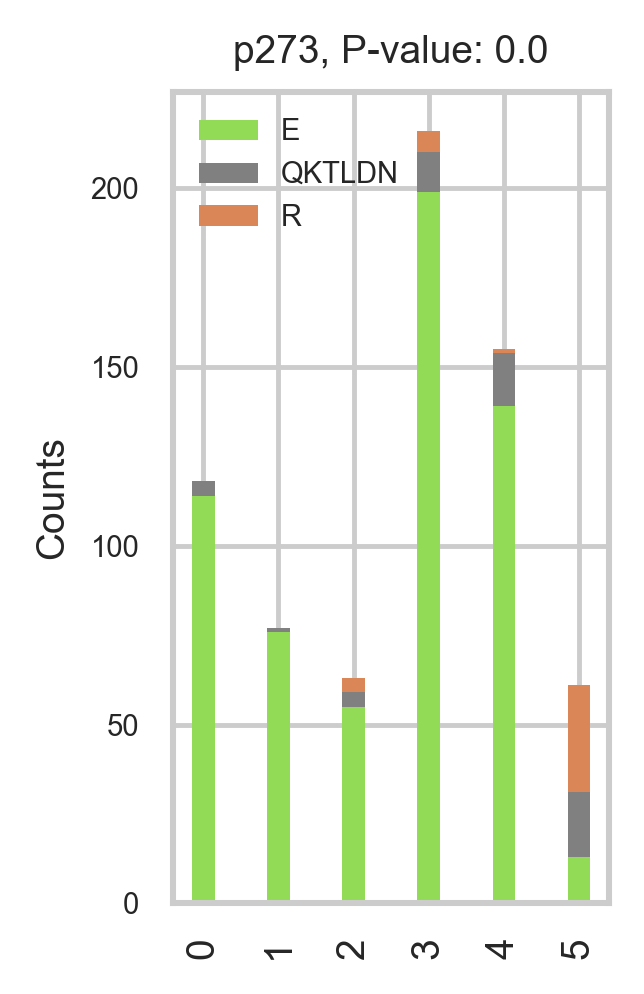

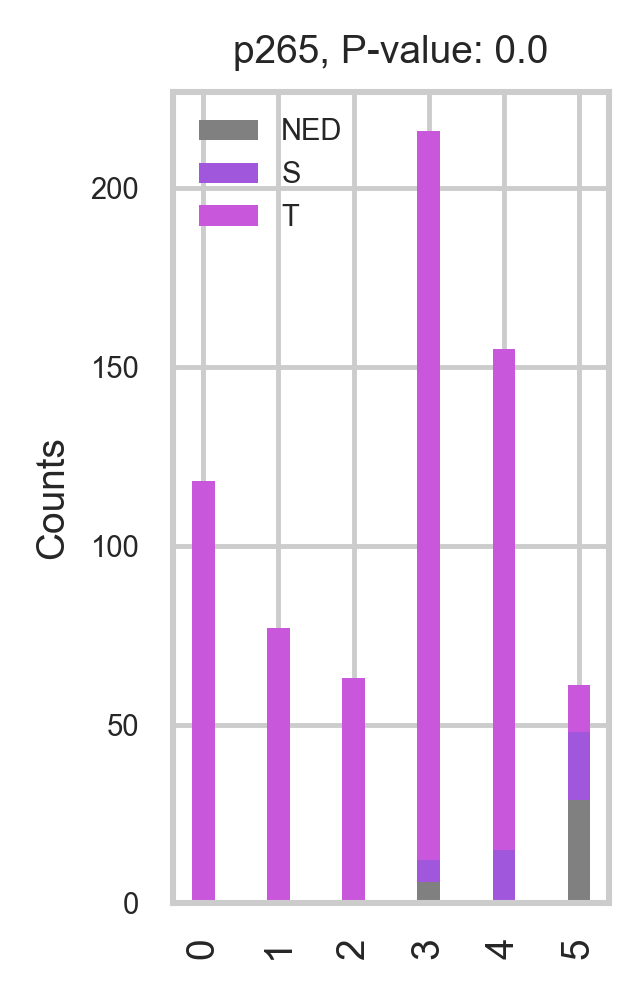

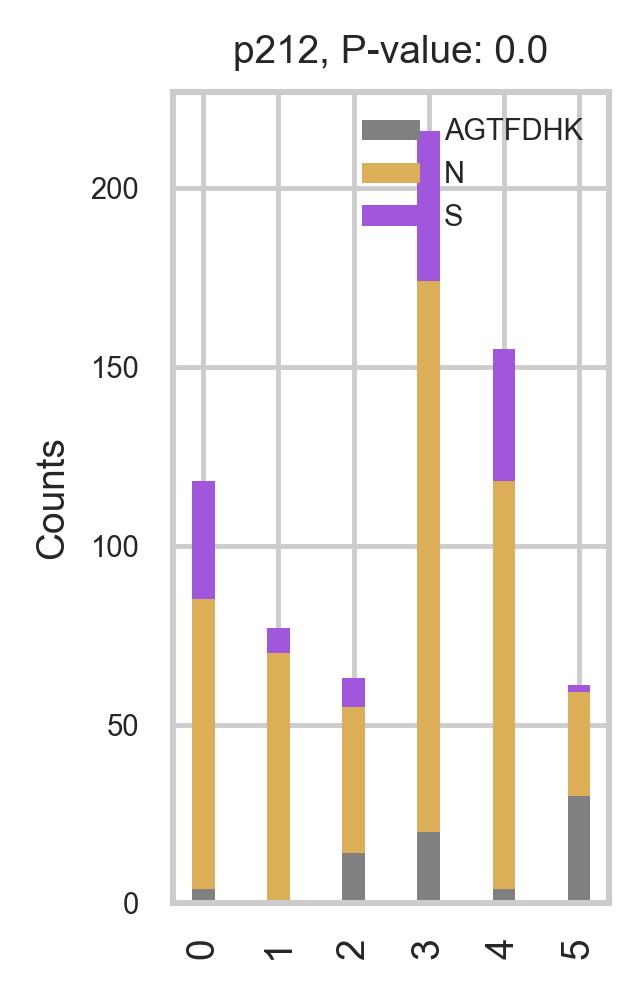

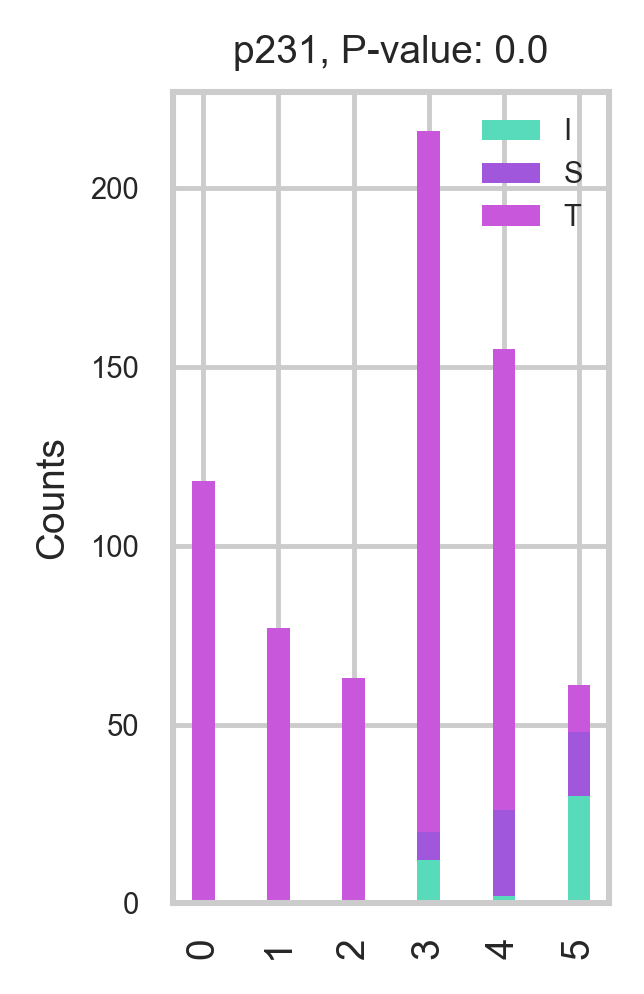

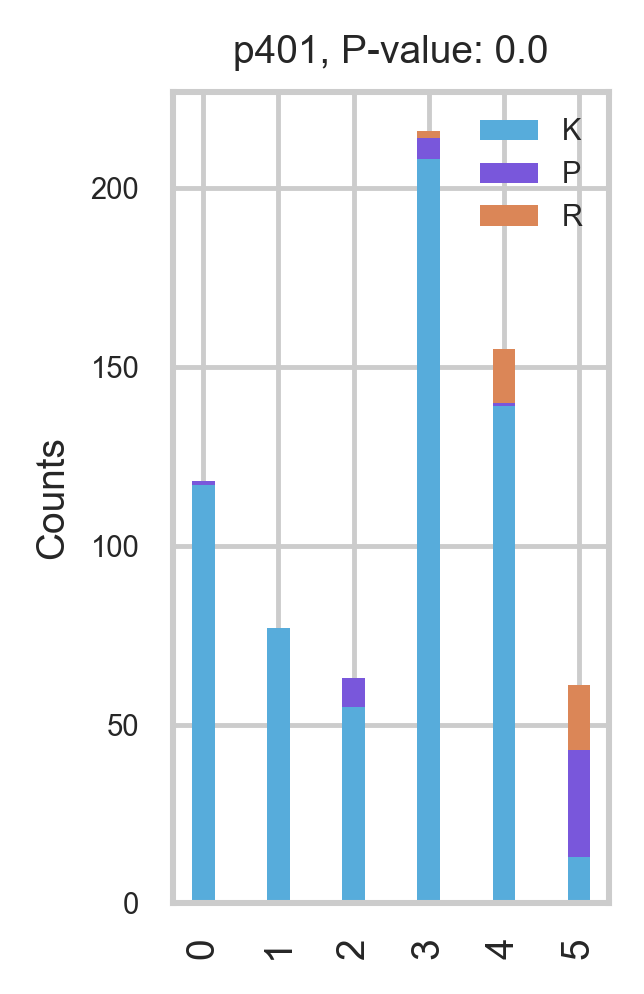

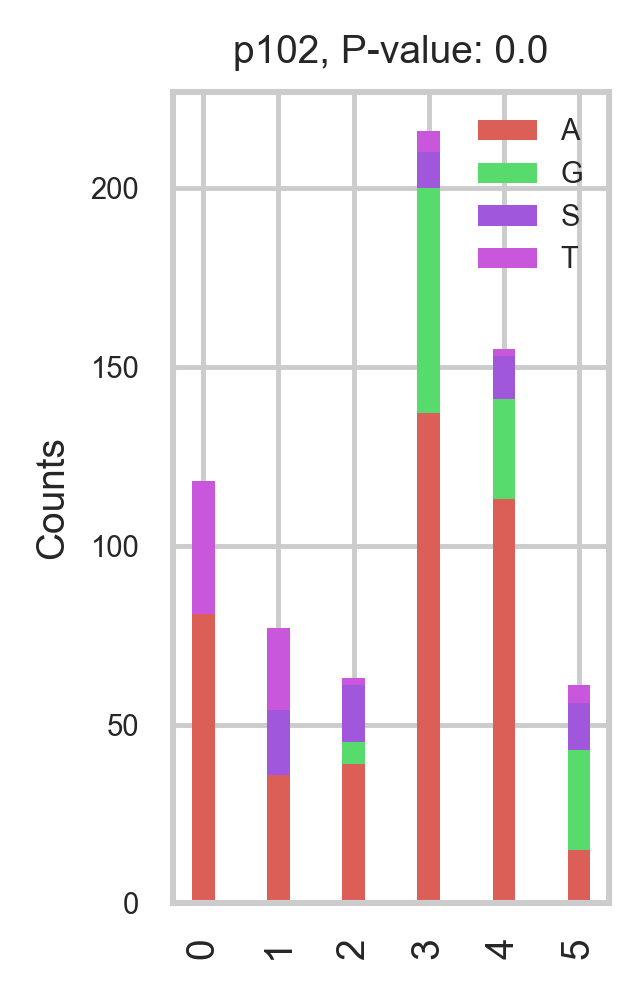

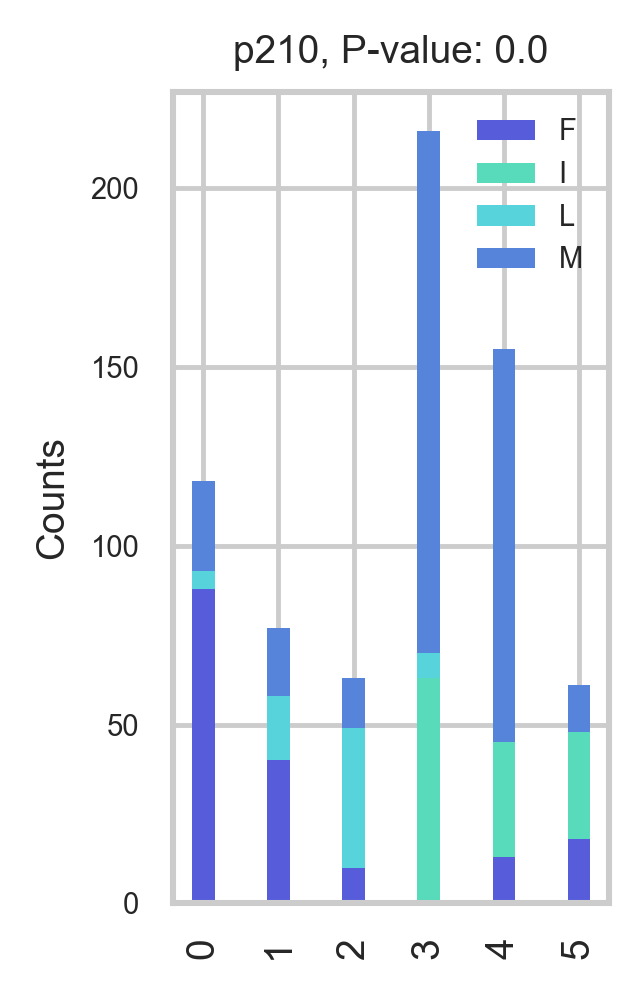

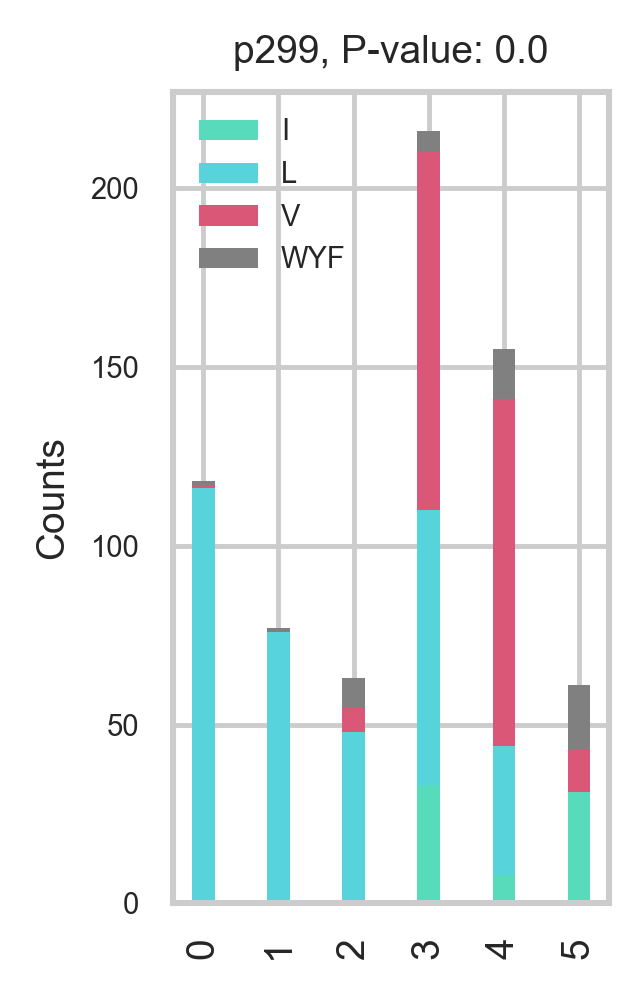

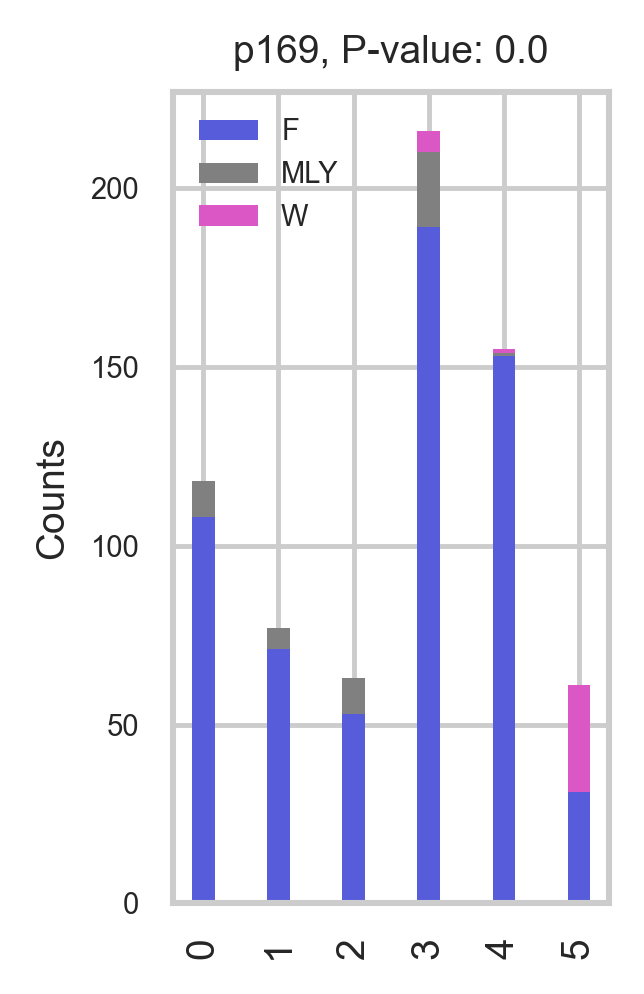

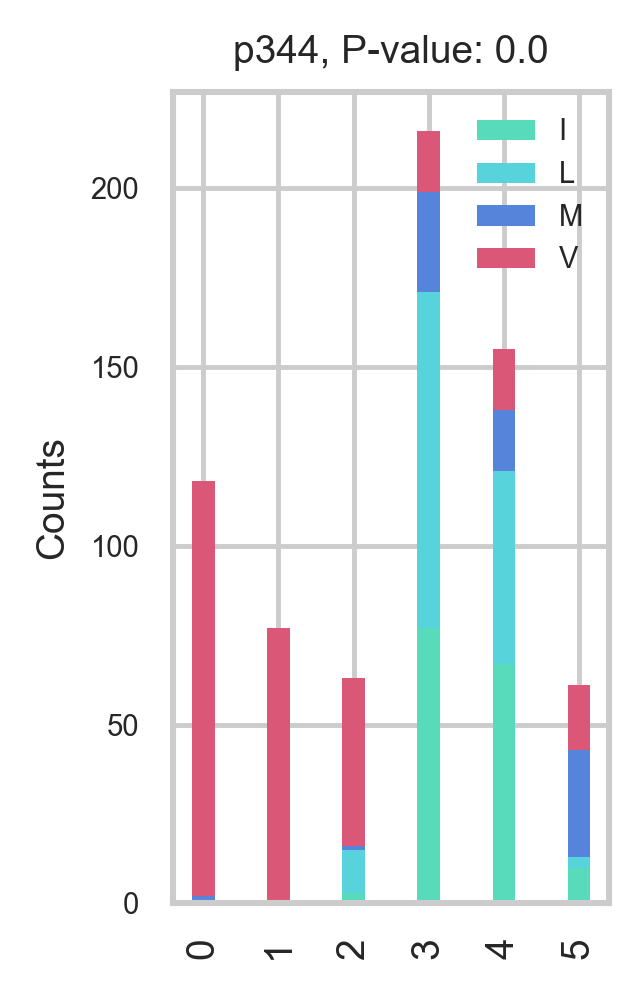

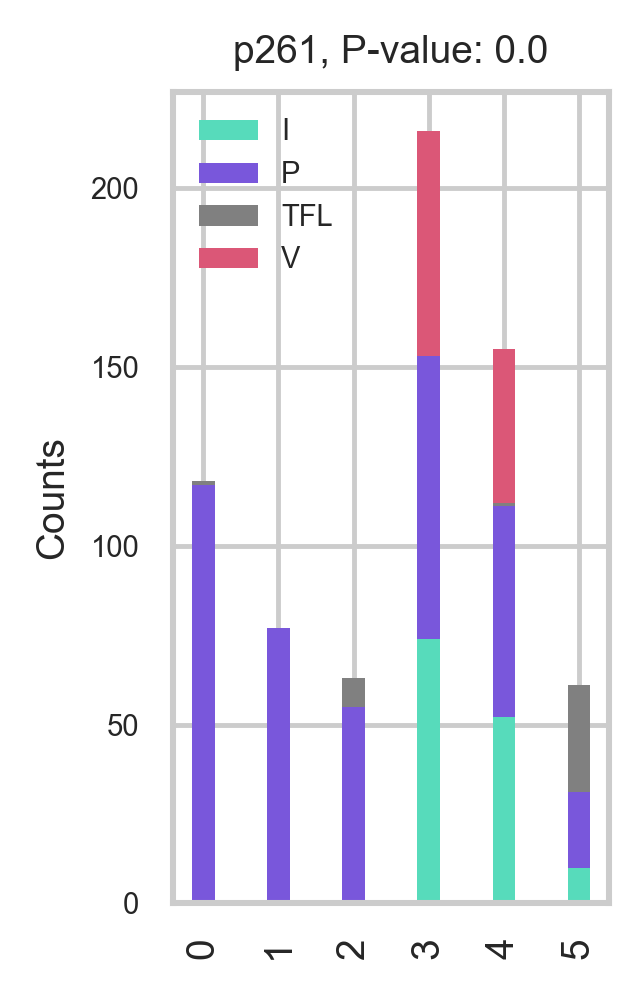

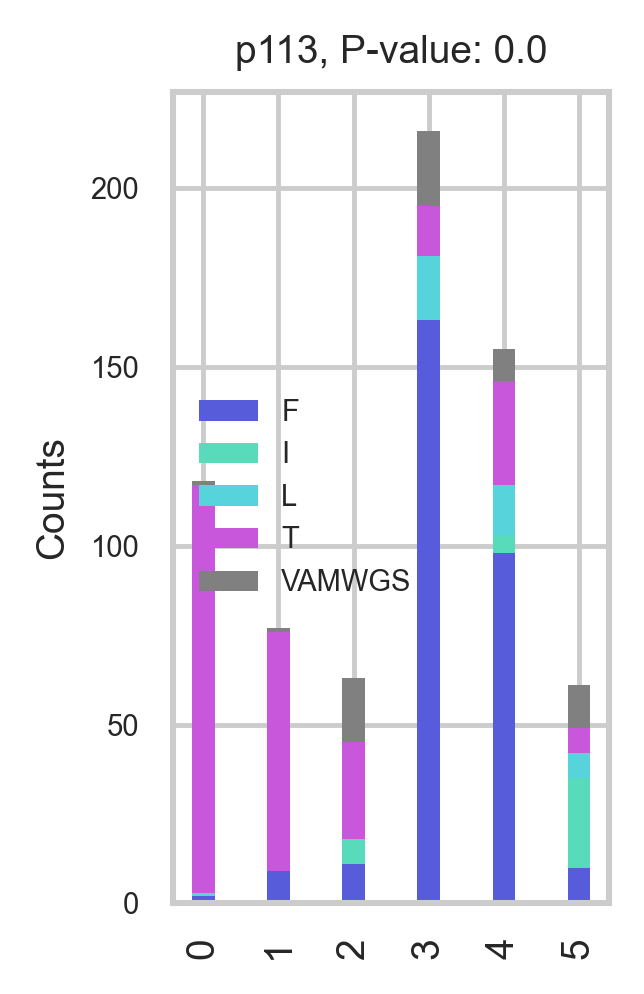

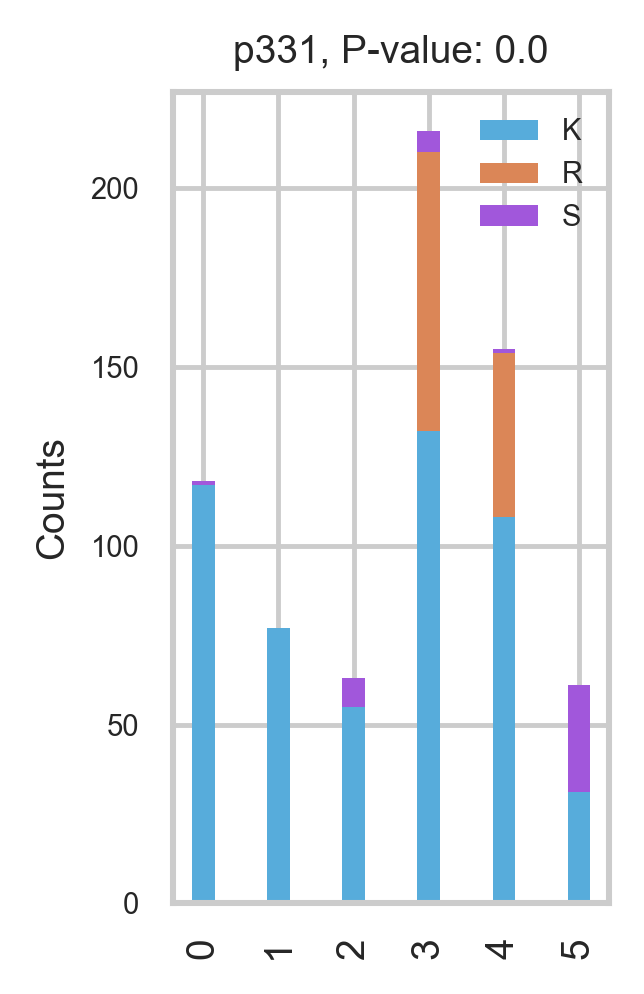

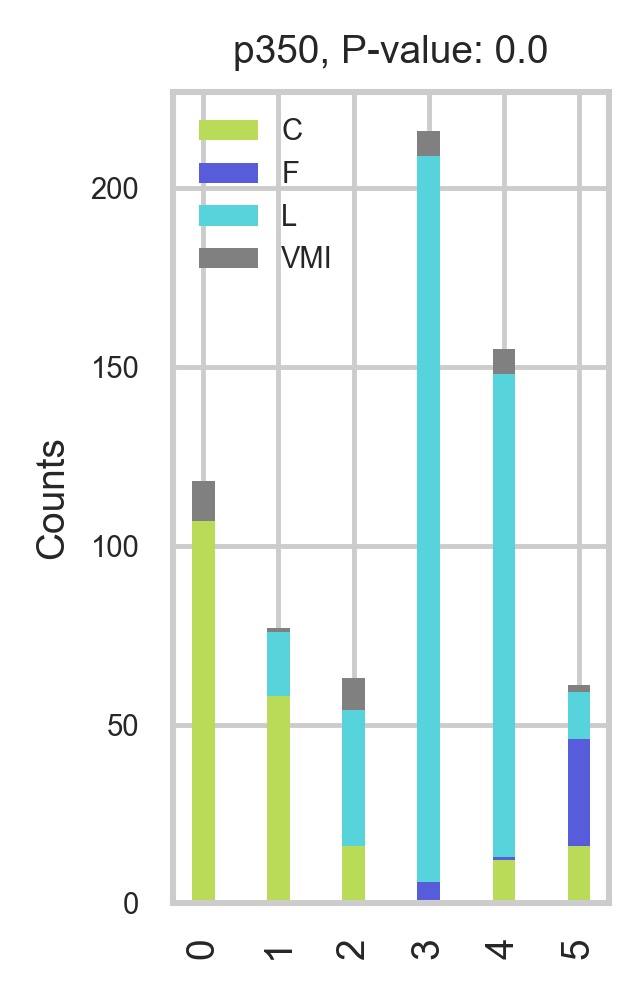

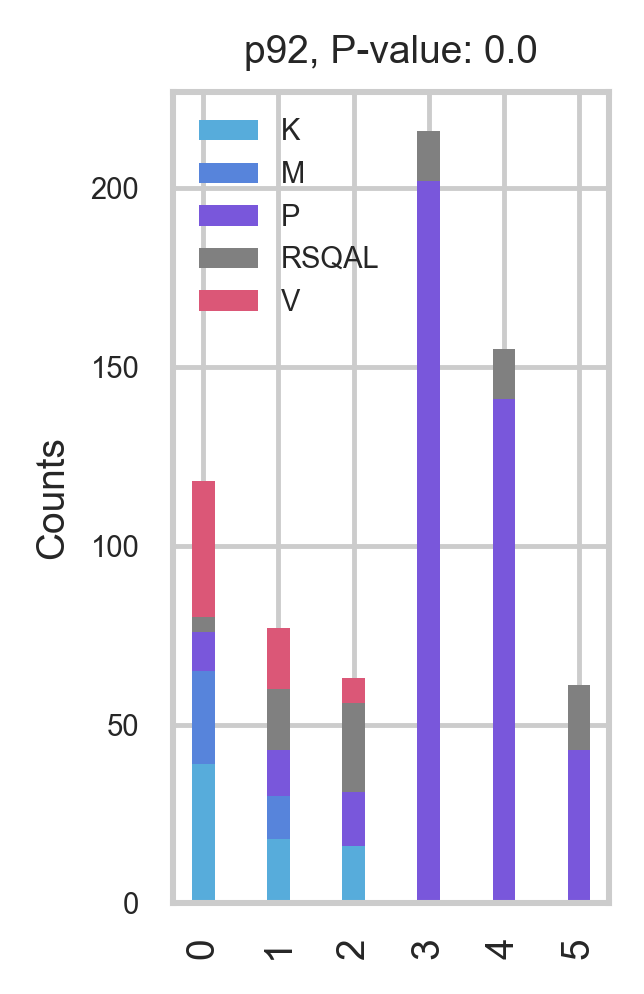

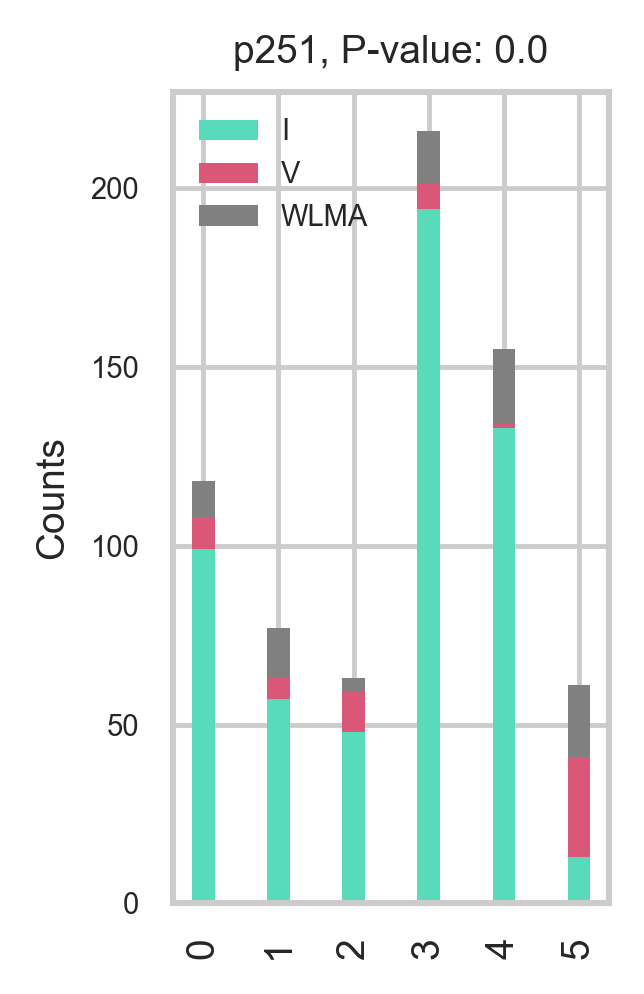

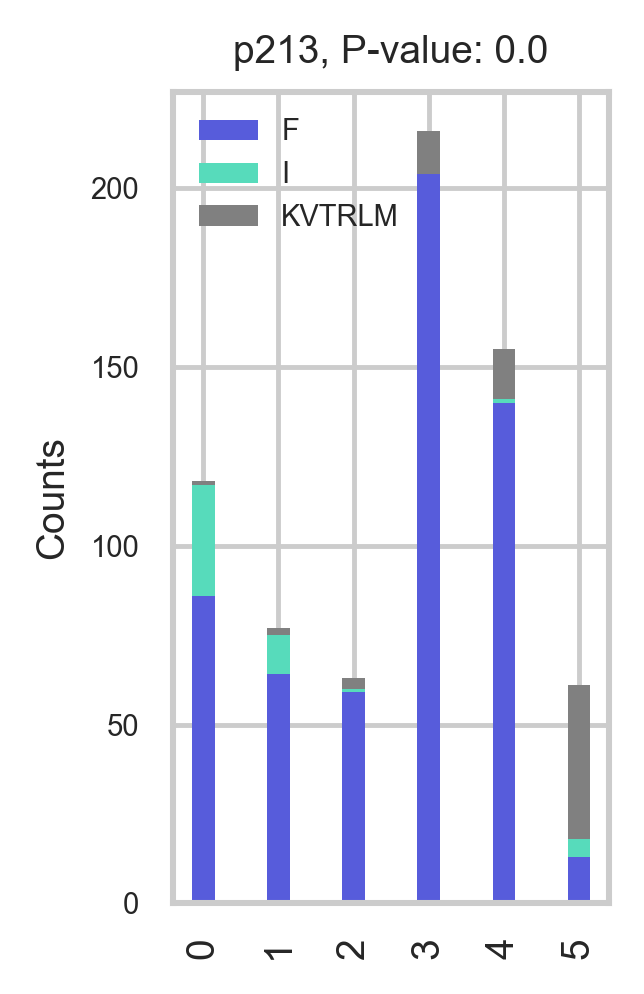

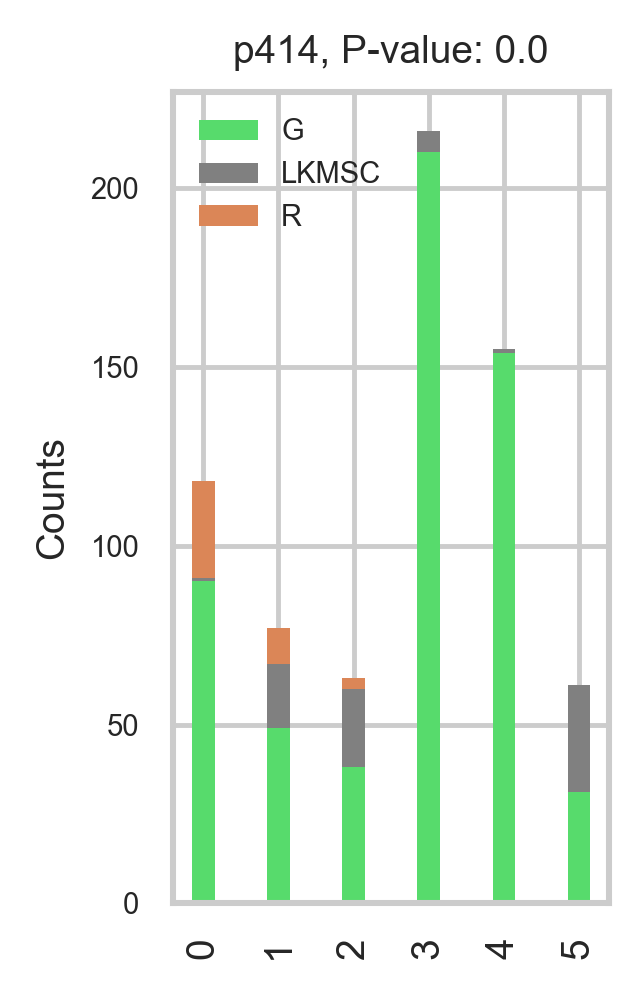

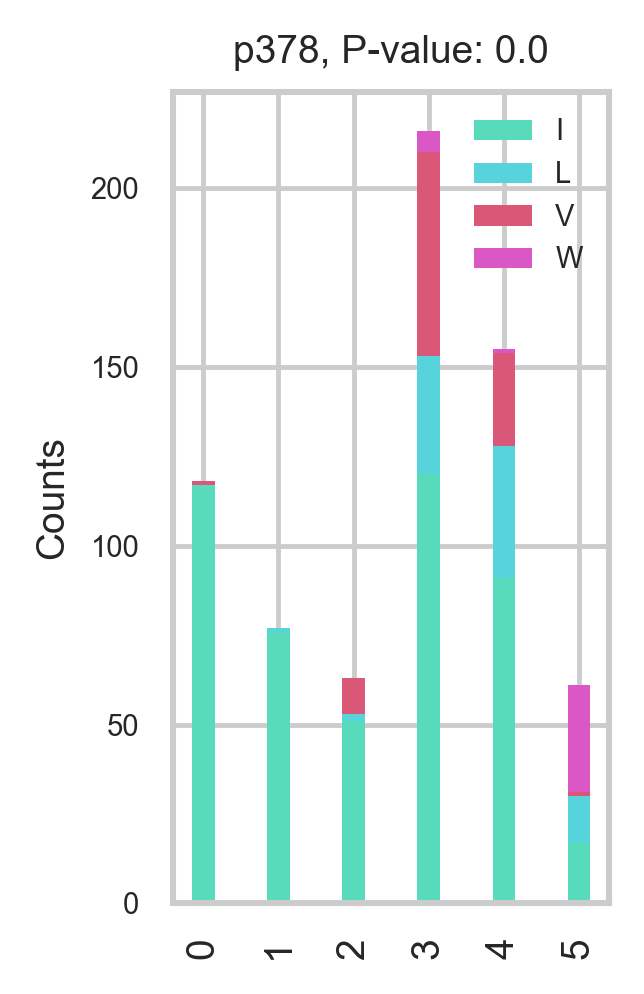

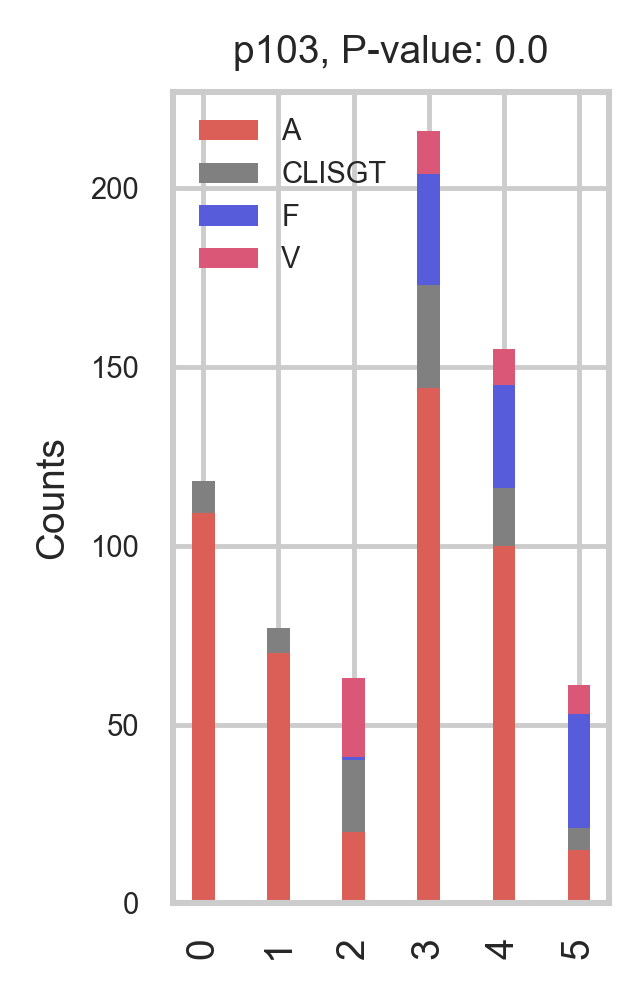

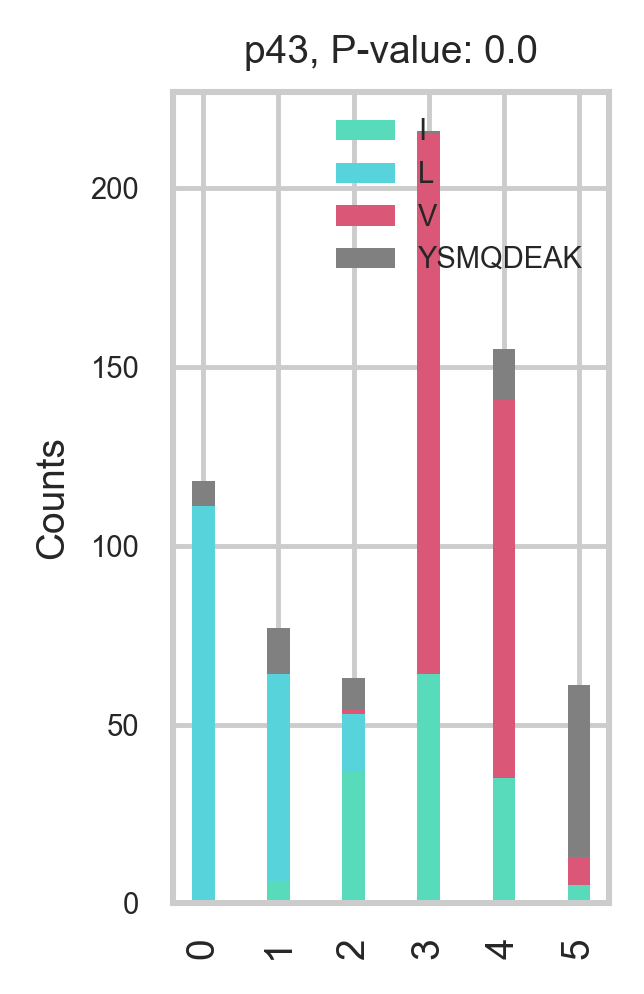

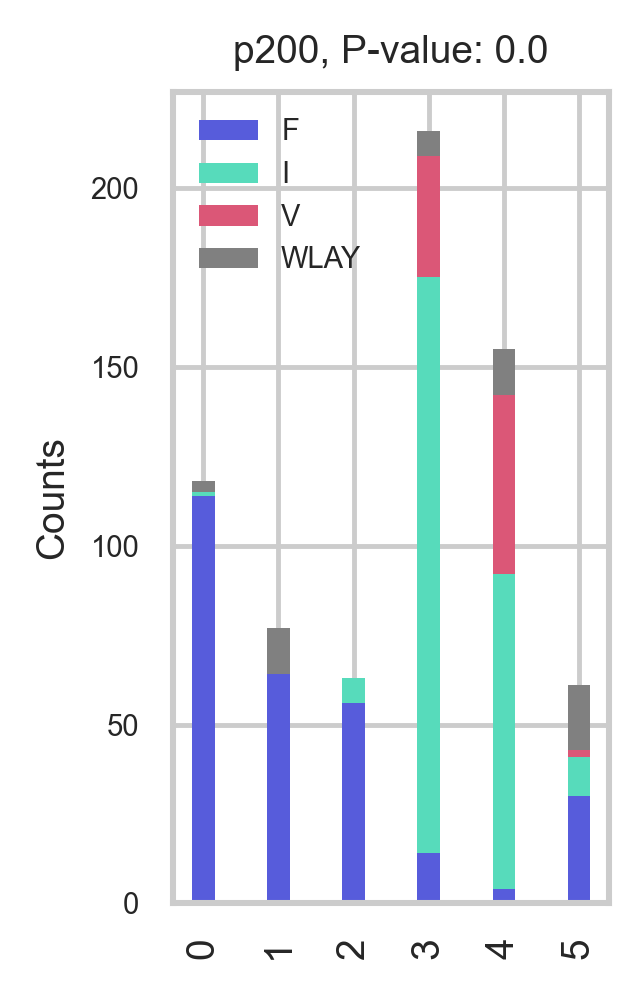

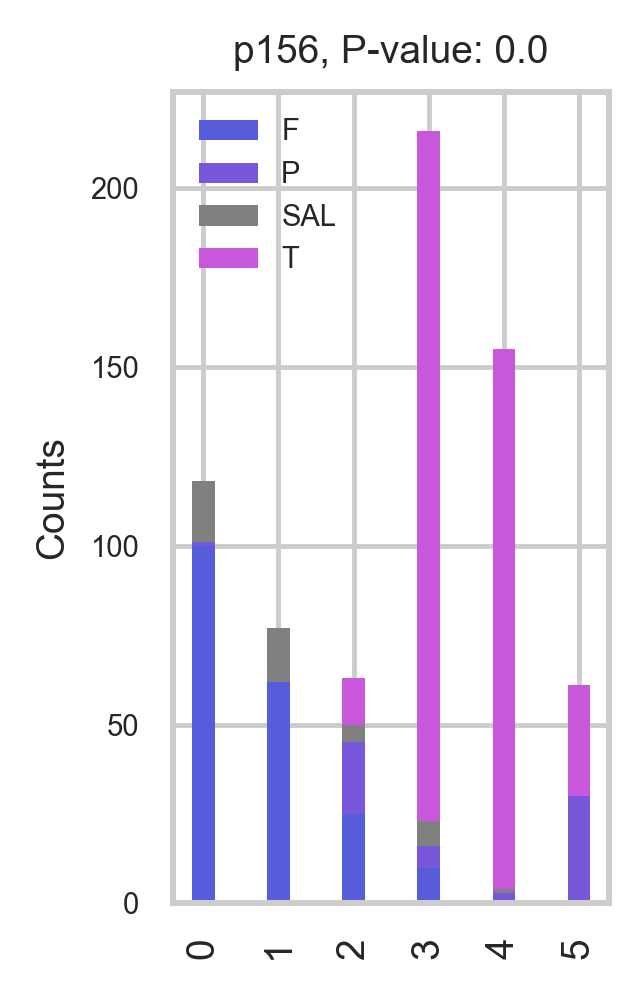

In [23]:
# visualizing top positions 
viz.plot_imp_all(trained_models=top_models, dat=df, train_cols=train_cols,
                 grouped_features=dc, meta_var=mt, model_type=anaType,
                 n_positions=positions, report_dir=report_dir)

In [24]:
import pandas as pd
models = pd.read_csv(report_dir+ '/models_summary.csv', index_col=0)

In [25]:
models

Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.7802  0.9468  0.7616  0.7937   
xgboost         Extreme Gradient Boosting    0.7595  0.9487  0.7375  0.7724   
gbc          Gradient Boosting Classifier    0.7471  0.9433  0.7335  0.7668   
ridge                    Ridge Classifier    0.7511  0.0000  0.7327  0.7651   
lr                    Logistic Regression    0.7491  0.9492  0.7275  0.7648   
rf               Random Forest Classifier    0.7263  0.9330  0.7199  0.7346   
et                 Extra Trees Classifier    0.7202  0.9193  0.7151  0.7341   
dt               Decision Tree Classifier    0.7098  0.8609  0.6923  0.7288   
svm                   SVM - Linear Kernel    0.7077  0.0000  0.6844  0.7375   
ada                  Ada Boost Classifier    0.4317  0.7219  0.3487  0.3258   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.7768  0.7264  0.7305     0.038  
xgboost   0.7551  0.7001  0.7041     0.301  
gbc       0.7444  0.6850  0.6897     0.158  
ridge     0.7442  0.6891  0.6946     0.004  
lr        0.7437  0.6869  0.6922     0.322  
rf        0.7198  0.6591  0.6638     0.053  
et        0.7139  0.6513  0.6570     0.881  
dt        0.7045  0.6382  0.6440     0.004  
svm       0.6991  0.6351  0.6435     0.007  
ada       0.3608  0.2738  0.2870     0.023

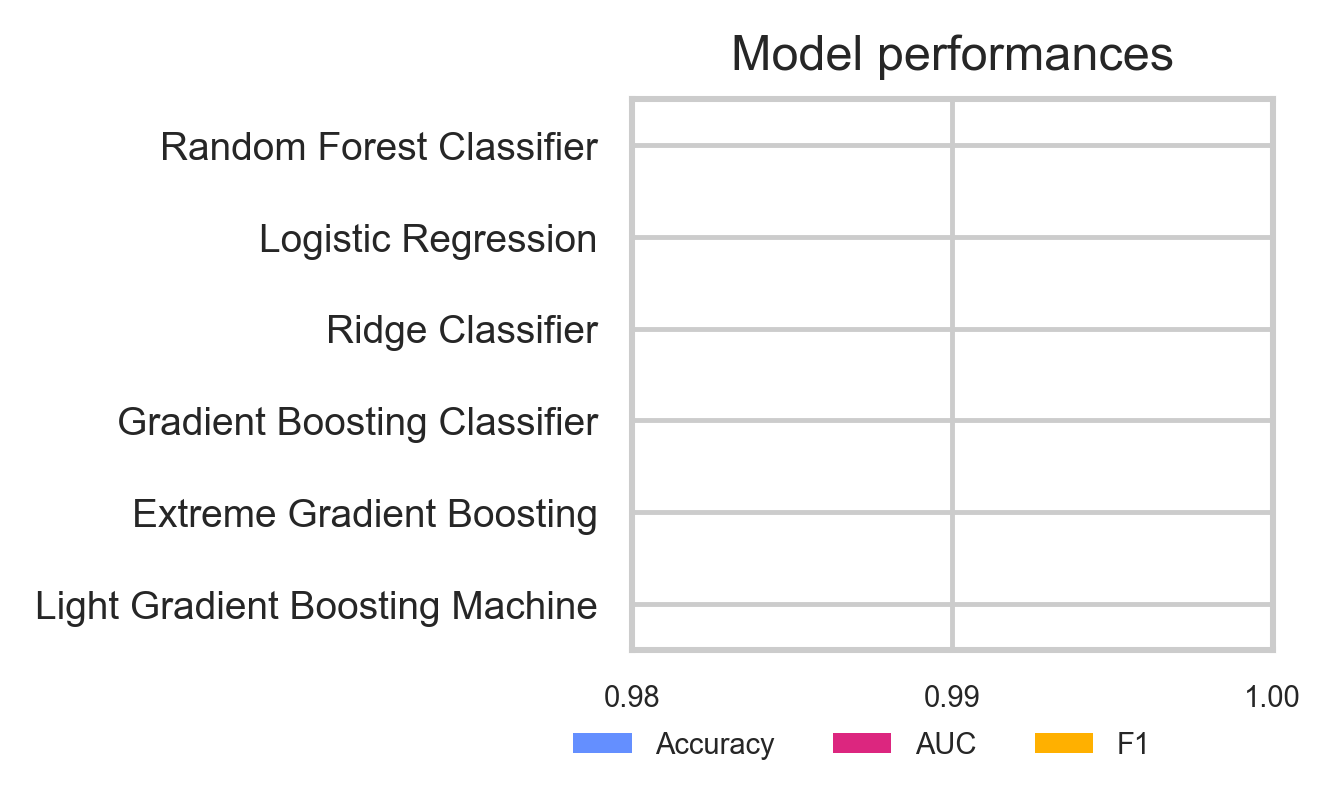

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=350)
fig = models.iloc[:6,].plot(x="Model", y=["Accuracy", "AUC", "F1"],
                           kind="barh",
                           color=['#648FFF', '#DC267F', '#FFB000'],
                           ax=ax,
                           ylim=(0,1))
ax.legend(bbox_to_anchor=(0.85, -.1), fontsize = 6, ncol=3)
ax.set_title('Model performances', fontsize=10)
ax.set_xlabel('')
plt.xticks(fontsize=6)
plt.ylabel('')
plt.xlim(.98,1)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(str(report_dir + '/model_performances.pdf'),
                bbox_inches='tight')

In [57]:
#We need to take df_for_testing and copy the column names into a new df AND take those column names and put them in a list of strings.
#for that it's something like...
x = 0
val = int(0)
data = list()
seq_dict = dict()
unseenData = 'test.fasta' 
seq_type2 = 'amino-acid'
#Following creates a dataframe of aa sequences and their positions as collumns.
df = prp.read_data(unseenData, seq_type = seq_type2, is_main=True)
df.head()
#Turning sequence names into a list for indexing
seq_name = df.index.to_list()

#for every sequence in the list of sequences the following function will occur. 
for seq in seq_name:
    data.clear()
    for col in training_col_list:
        #take the str of the column name and split at the '_'
        split = str(col).split('_')
        #declare a temp position variable to index df 
        position = str(split[0])
        print(position)
        #declare the aa we will compare the df index to
        aa = str(split[1])
        print(aa)
        count = len(aa)
        #index the df column corresponding to the 'position' variable
        s = df[position]
        #assign value based on whether the aa at some position matches the training_col aa 
        if (s[seq_name[x]] == aa):
            val = int(1)
        
        elif (count > 1):
            for n in range(count):
                amino = aa[n]
                
                if (s[seq_name[x]] == amino):
                    val = int(1)
                    break
                else:
                    val = int(0)   

        else:
            val = int(0)

        data.append(val)
        #print([type(i) for i in data])
        
    seq_dict.update({seq_name[x] : data})
    x+=1
print(seq_dict)
df_for_testing = pd.DataFrame(data = seq_dict.values() , columns = training_col_list, index = seq_dict.keys(), dtype = int)
print(df_for_testing.head())

file3 = open('fmt_data_cols.txt', 'a+')
training = str(df_for_testing.to_string())
file3.write(training)
file3.close()

['Test']
p63
N
p65
K
p65
LHGNSQVEM
p65
T
p81
P
p91
N
p91
S
p92
M
p94
K
p98
Y
p100
GCSFT
p100
M
p100
V
p102
T
p103
CLISGT
p103
V
p105
M
p107
ICTVSA
p107
L
p107
M
p110
F
p110
I
p110
L
p110
V
p111
FGMCS
p111
I
p111
L
p111
T
p113
L
p113
VAMWGS
p114
S
p115
V
p117
G
p117
ILTS
p117
V
p118
M
p126
F
p126
I
p126
V
p127
K
p127
Q
p127
R
p145
I
p145
V
p146
S
p147
N
p148
TSHMCAIY
p152
L
p152
TGSM
p152
V
p156
SAL
p157
LMQFA
p157
P
p157
V
p159
I
p159
M
p164
S
p165
IWVT
p166
N
p166
RKVFMSCA
p166
Y
p167
RAQM
p169
MLY
p170
I
p170
V
p171
L
p173
P
p173
R
p174
I
p174
PDMAVRYS
p174
T
p175
M
p178
VDYSTERIMQ
p179
L
p179
MFWP
p179
V
p183
L
p183
V
p186
I
p189
Q
p191
G
p191
S
p200
V
p204
L
p204
V
p218
S
p225
M
p225
VGTFSY
p226
GVTIF
p226
L
p228
I
p228
V
p229
I
p229
L
p229
SGMTF
p230
CVYIMSG
p230
L
p233
I
p233
L
p233
TCMAG
p233
V
p234
FLYGC
p236
L
p236
S
p237
S
p237
VILTPC
p239
GC
p239
S
p240
GTFSMC
p240
V
p244
L
p251
WLMA
p257
VSG
p258
S
p277
L
p277
M
p277
V
p281
I
p281
TSGLF
p281
V
p285
I
p285
M
p285
SLGY
p285
T

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


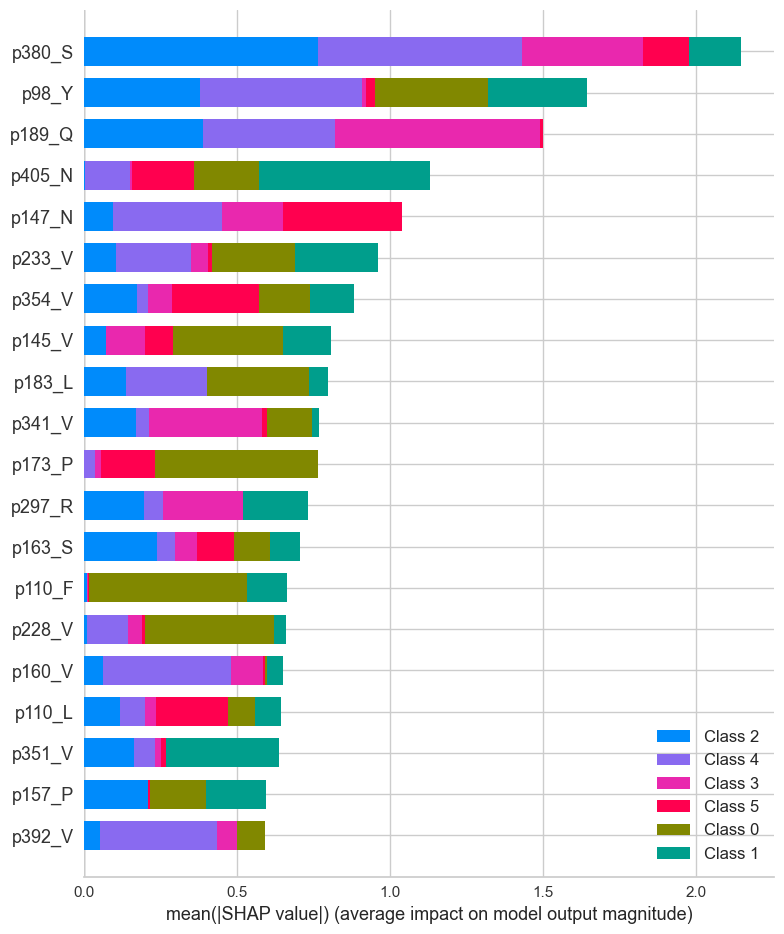

p63_N  p65_K  p65_LHGNSQVEM  p65_T  p81_P  p91_N  p91_S  p92_M  p94_K  \
Test      0      0              0      1      0      1      0      0      0   

      p98_Y  ...  p222_S  p270_V  p387_S  p389_Y  p414_R  p419_G  p420_D  \
Test      0  ...       0       0       1       1       0       0       0   

      p421_E  Label  Score  
Test       1      4  0.968  

[1 rows x 196 columns]

In [58]:
#interact//model for classification
# save pipeline
save_model(top_models[0], 'YOUR_MODEL_NAME')
# load pipeline
YOUR_MODEL_NAME = load_model('YOUR_MODEL_NAME')

#interpret_model(top_models[0])
 
predict_model(YOUR_MODEL_NAME, data = df_for_testing)

In [ ]:
#STEP 4: Translate Candidate STSs 
#Optional step IF running the classifier model, but could still be useful.
#To find CSTSs, got to the deepBreaks output folder and find the excel sheet 'avg_top_models_feature_importance'
#Sort the top model's feature importance column by 'largest-to-smallest' and take x# of those positions.
#enter list of candidate STSs below
impsites = input("Enter list CSTSs: ")
#enter desired name of output text file.
#eg - If I'm translating sites from a LRM for the rods subset of my dataset I would have the output text file be named...
#output = rod_csts.txt
output = input("Enter Name of Output File: ")
seq = input("Enter Aligned Bovine Sequence: ")
site_list = impsites.split(',')
m = 0

#take the list of important sites and translate them to the bovine standard equivalent, we do this by taking the site number and subtracting the number of '-' between the start of the sequence and the desired site. 
for sites in site_list:

    k = int(sites)    
    gaps = seq[:k].count('-')
    #print("The number of gaps is " + str(gaps))
    trans_site = k - gaps
    #print(f"For site {k} the bovine equivalent is {trans_site}") 

    with open(output, 'a') as f:
        if m == 0:
                f.write("The following sites have been translated to the standard Bovine equivalent...\nFormat is before translation --> post translation to bovine equivalent.")   
                m+=1 
        f.write(f"Site {k} == {trans_site}\n")      